In [1]:
import numpy as np
import numpy as np
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value, concatenate_graphs
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar_v2, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, FONTSIZE, FONTSIZE_MID, plot1d_errorbar, plot1d_step, set_plot_defaultstyle
import pickle
from tools.constants import NUCLEI_CHARGE, ANALYSIS_RANGE_EKIN, ISOTOPES_MASS, ISOTOPES_COLOR, ISO_LABELS
from tools.constants import DETECTOR_COLOR, ISOTOPES
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines 
import matplotlib
from tools.MassFunction import expo_func
from scipy.interpolate import UnivariateSpline
import pickle
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
import uncertainties
from tools.binnings_collection import fbinning_energy, get_bin_center
from tools.calculator import calc_rig_from_ekin, calc_ratio_and_err
from tools.constants import ISOTOPES_MASS, ISOTOPES_CHARGE, ANALYSIS_RANGE_EKIN, DETECTOR_LABEL
from tools.plottools import xaxistitle, xaxis_binning
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d, plot_histogram_2d 
import os
from tools.binnings import Binning 
import pandas as pd
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS, ISOTOPES
import uproot
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d, plot_histogram_2d 
from tools.studybeta import weighted_avg_and_std
from tools.jupytertools import *

/home/manbing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
ANALYSIS_RANGE_EKIN_OVERLAP = {"Tof": [0.4, 1.1], "NaF": [1.1, 4.0], "Agl": [4.0, 12.0]}
ANALYSIS_RANGE_EKIN = {"Tof": [0.4, 1.1], "NaF": [1.2, 4.0], "Agl": [4.2, 12.0]}

filename_hist = '/home/manbing/Documents/Data/data_LiP8/Hist2D/LiMC_deltamass_Ekin_P8B1236_finebin_All.npz'
filecounts_path = '/home/manbing/Documents/lithiumanalysis/scripts/'

fig_suffix = 'mean'
slicevalue ={'Tof':[0.45, 1.1], 'NaF':[1.0, 4.0], 'Agl':[3.5, 12.0]}
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/Study_LiBoron_energy_loss_mean'
os.makedirs(plotfile, exist_ok=True)

nuclei = 'Li'
isotopes = ISOTOPES[nuclei]

detectors = ['Tof', 'NaF', 'Agl']
def get_hist_meanstd(hist2d):
    var_xcenter = hist2d.binnings[0].bin_centers[1:-1]
    var_ycenter = hist2d.binnings[1].bin_centers[1:-1]
    avg = np.zeros(len(var_xcenter))                                                                                                                                                                               
    std = np.zeros(len(var_xcenter))  
    
    for binx in range(1, len(var_xcenter)):                                                                                                                                                                      
        ibin_fitdata = hist2d.values[binx, 1:-1]
        if sum(ibin_fitdata) != 0:                                                                                                                                                                                
            avg[binx], std[binx] = weighted_avg_and_std(var_ycenter, ibin_fitdata)                                                                                                                                 
    return avg, std     
    


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


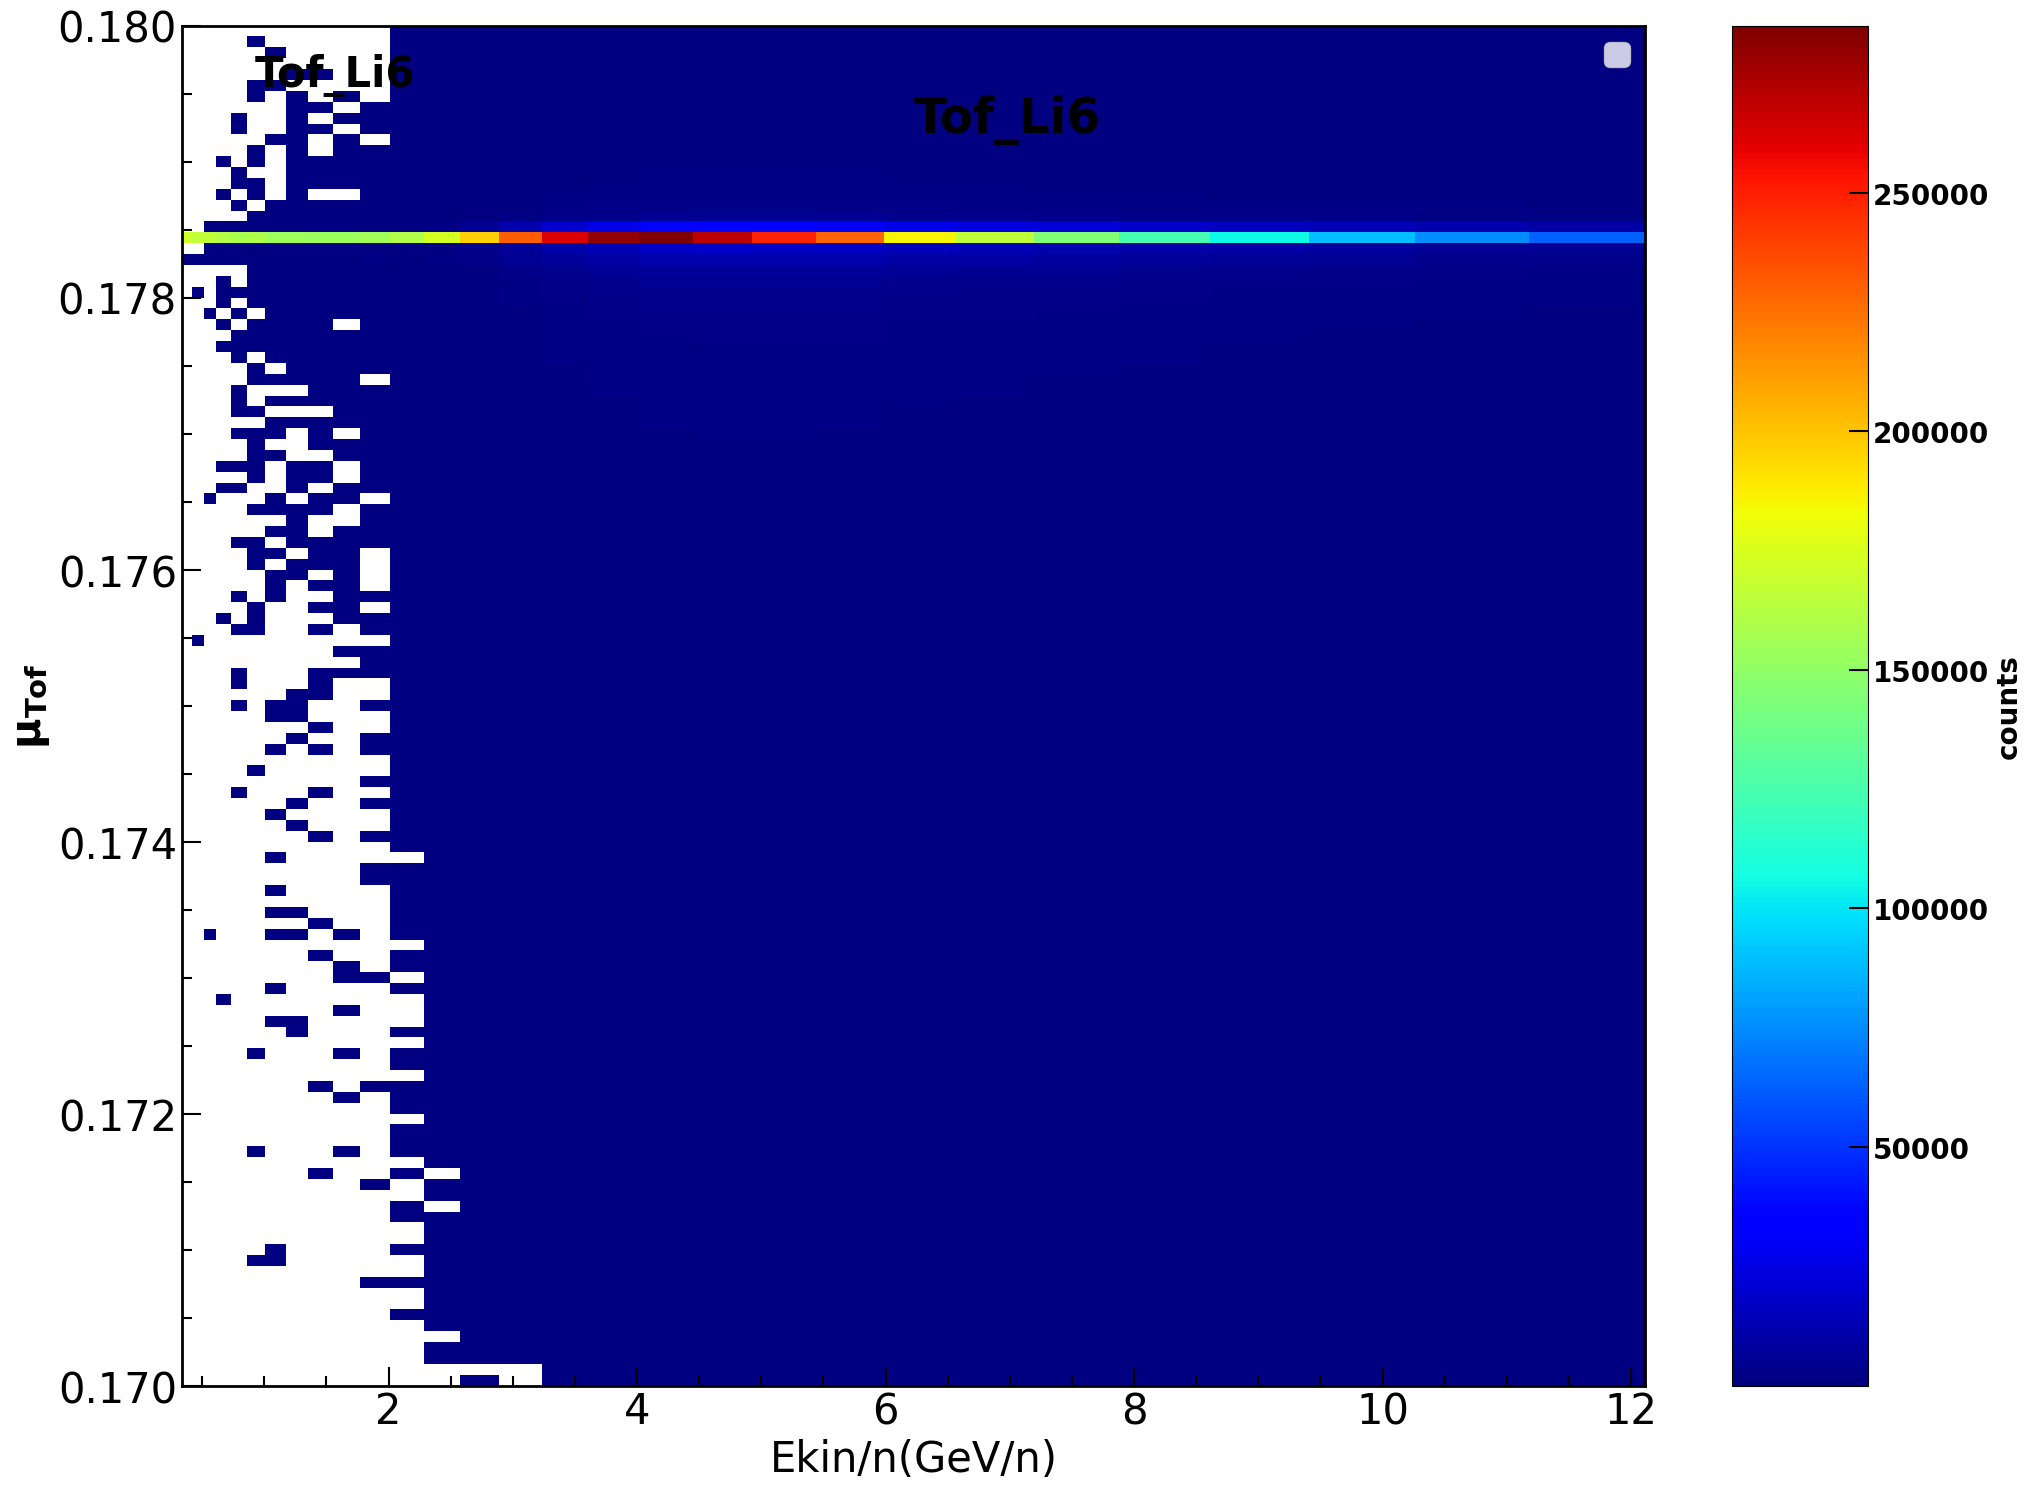

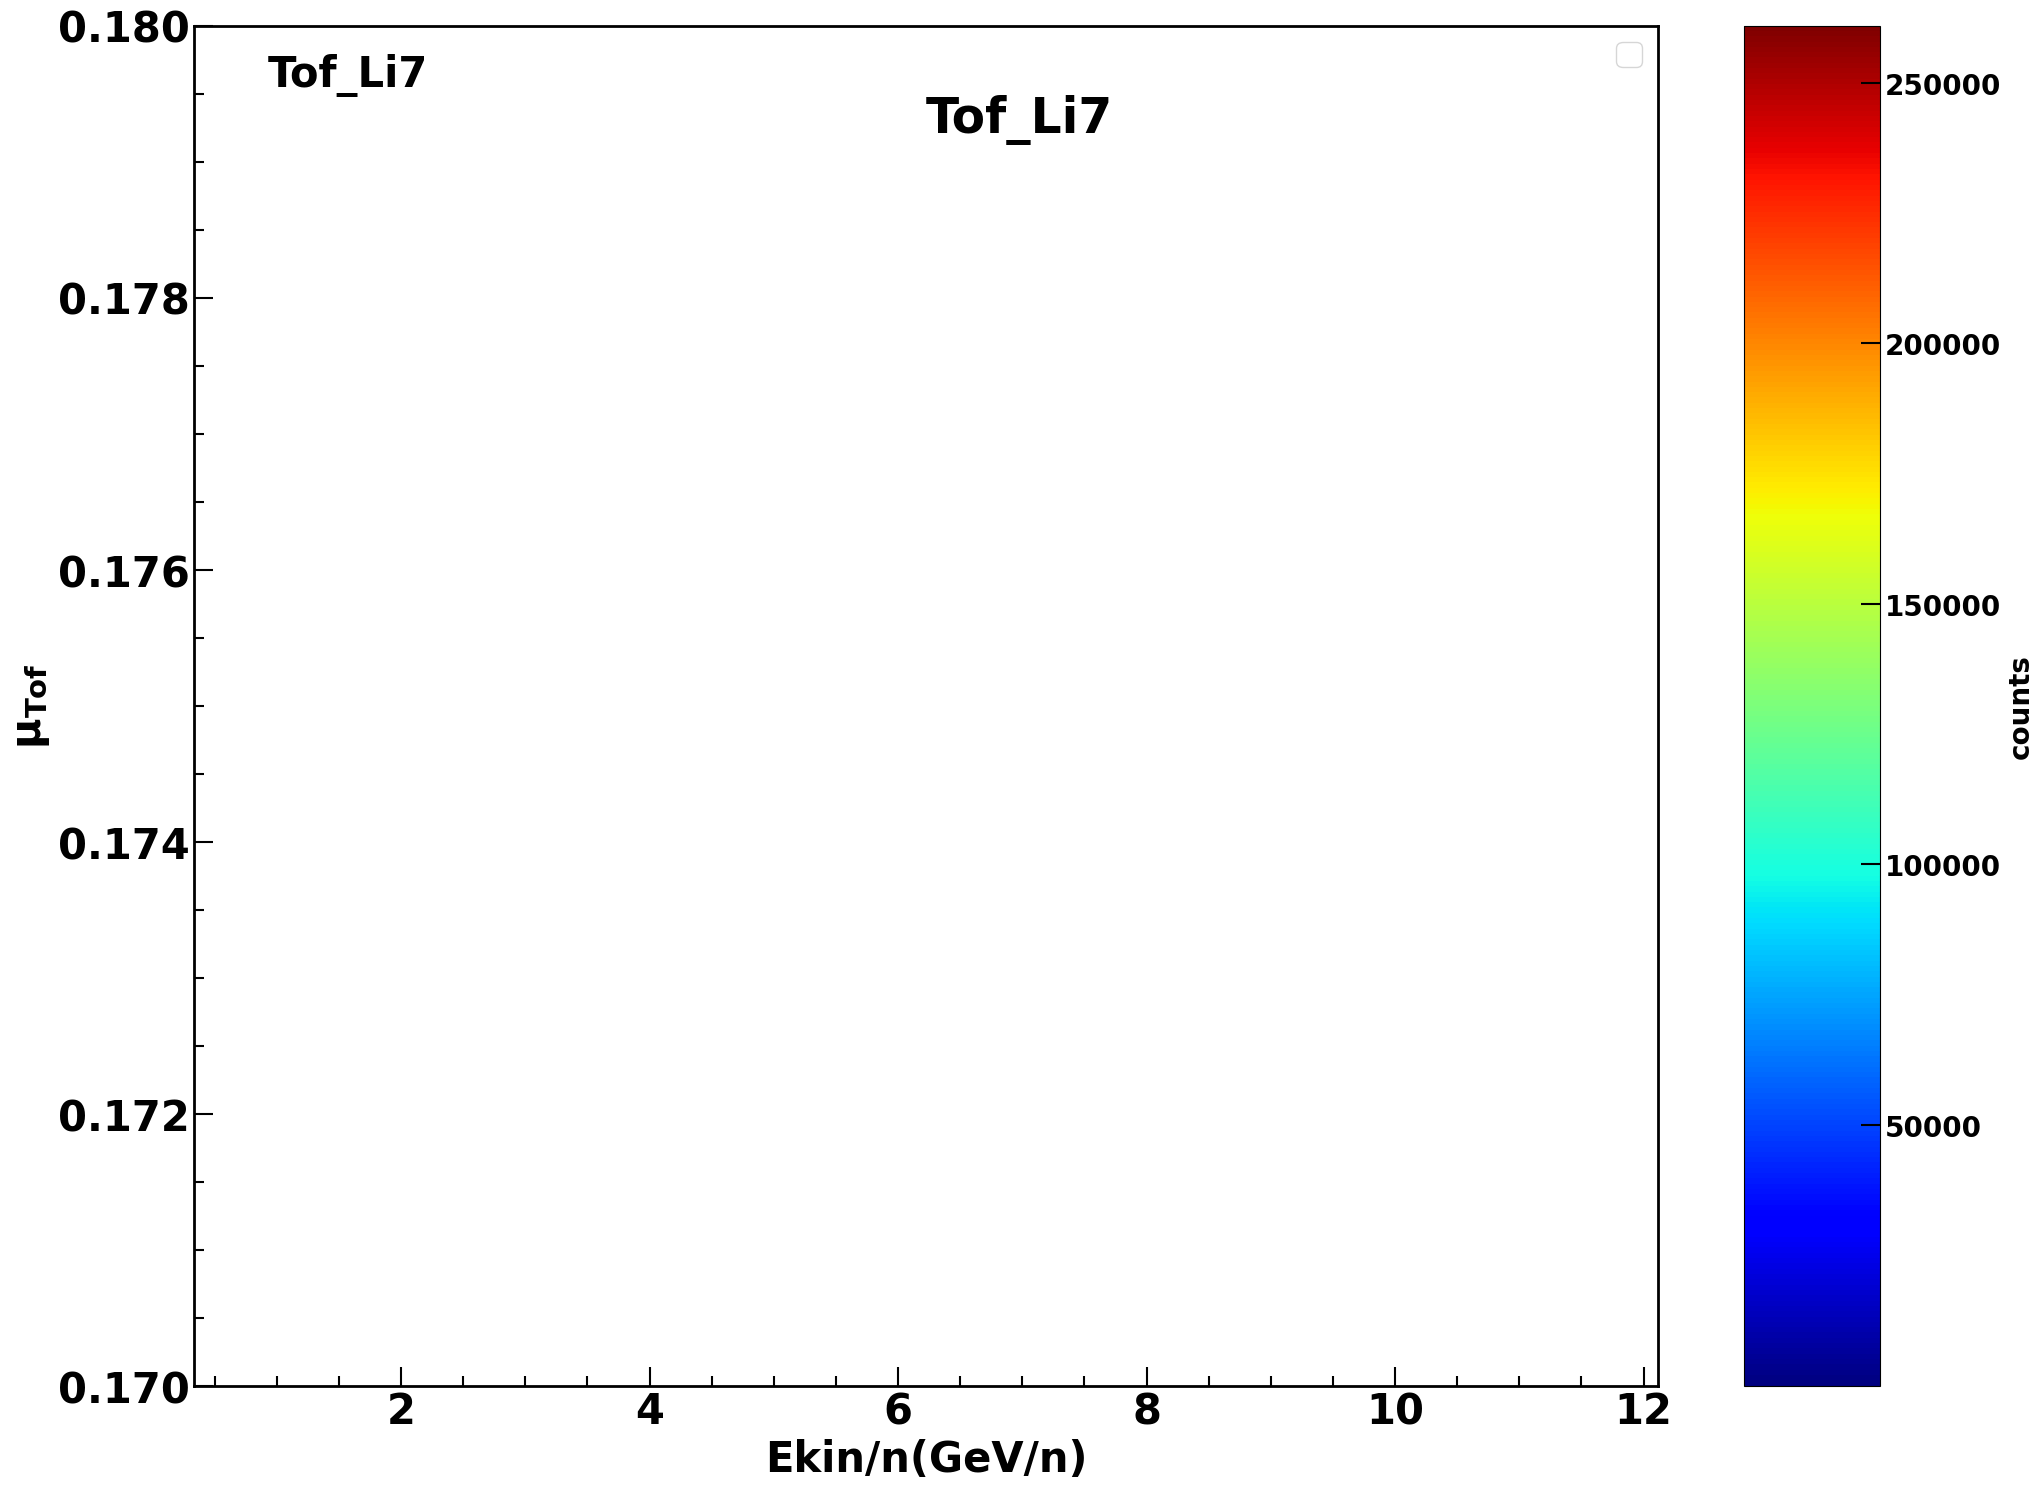

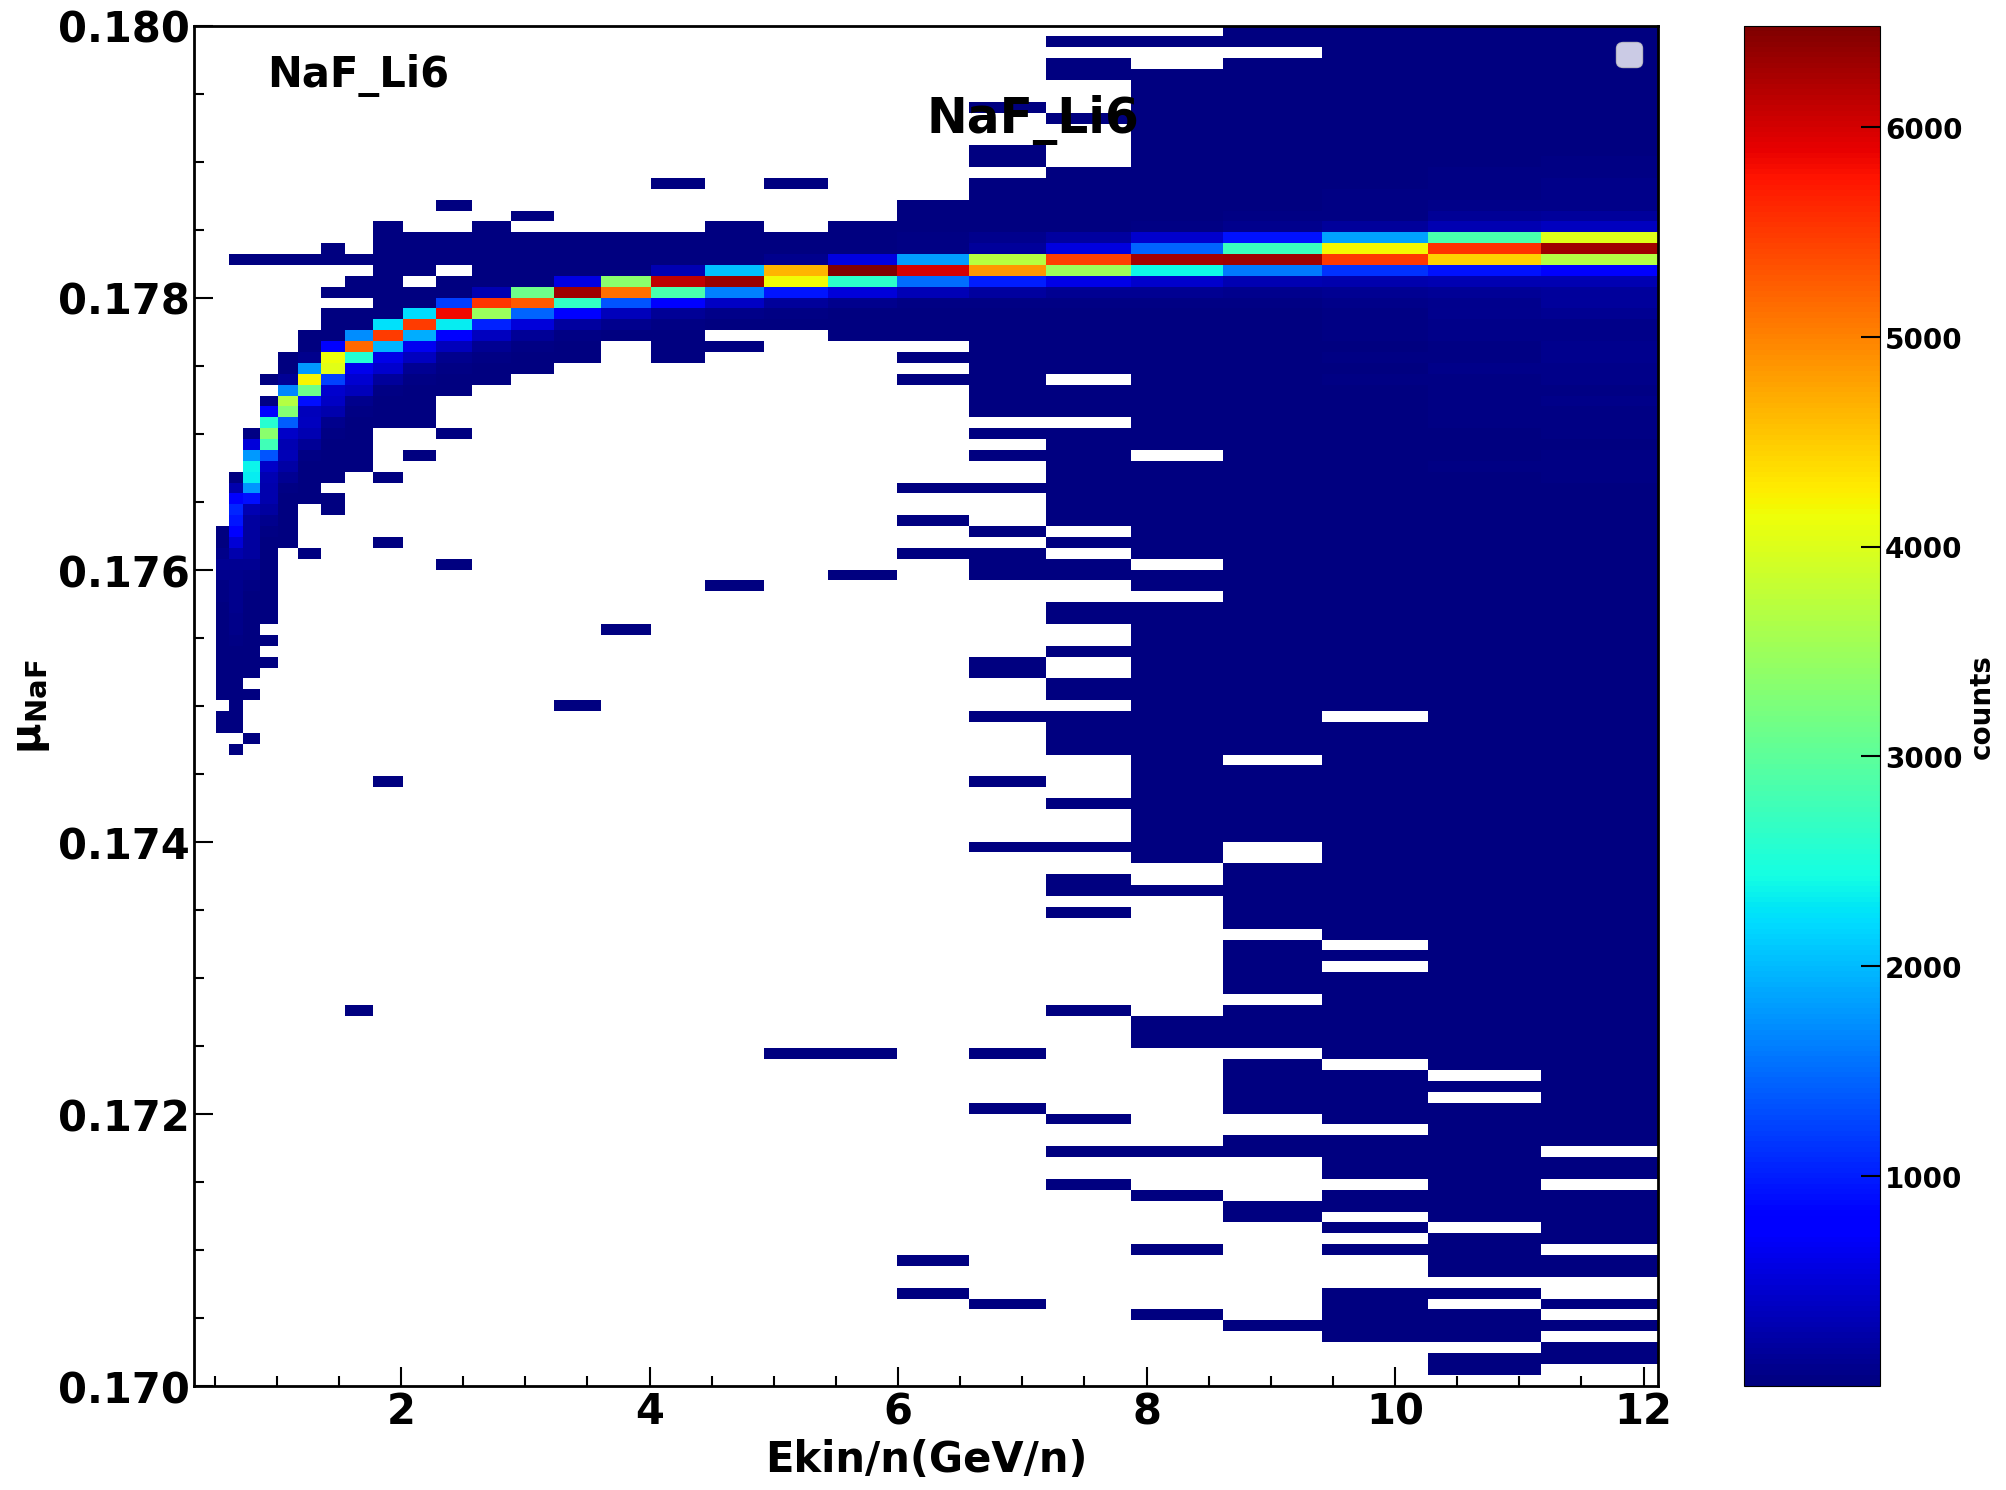

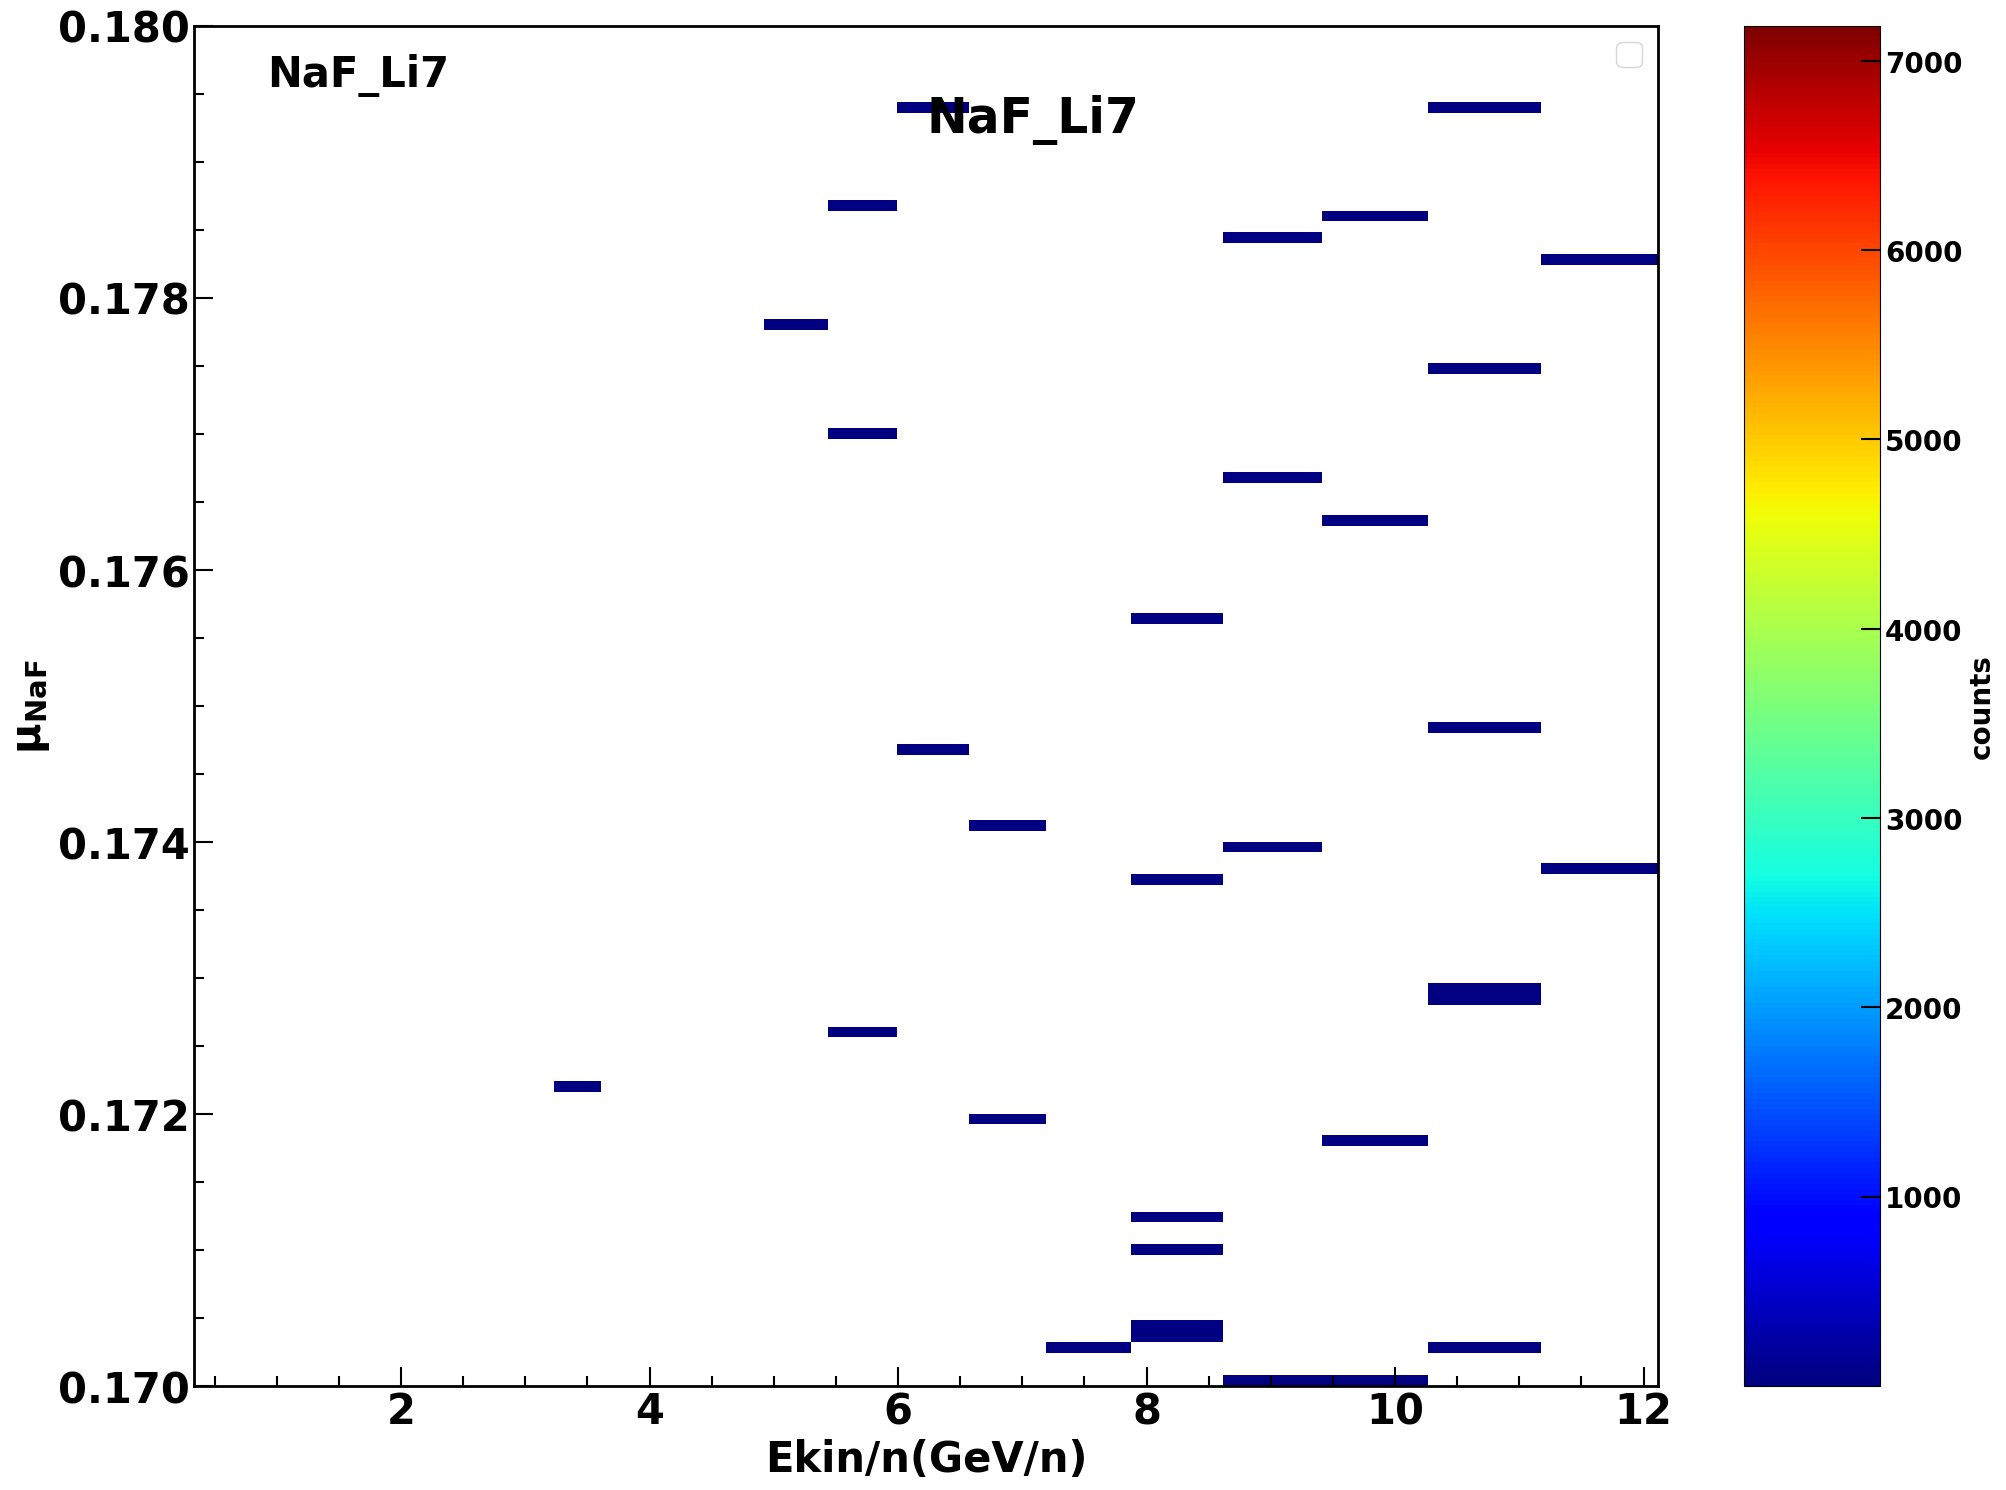

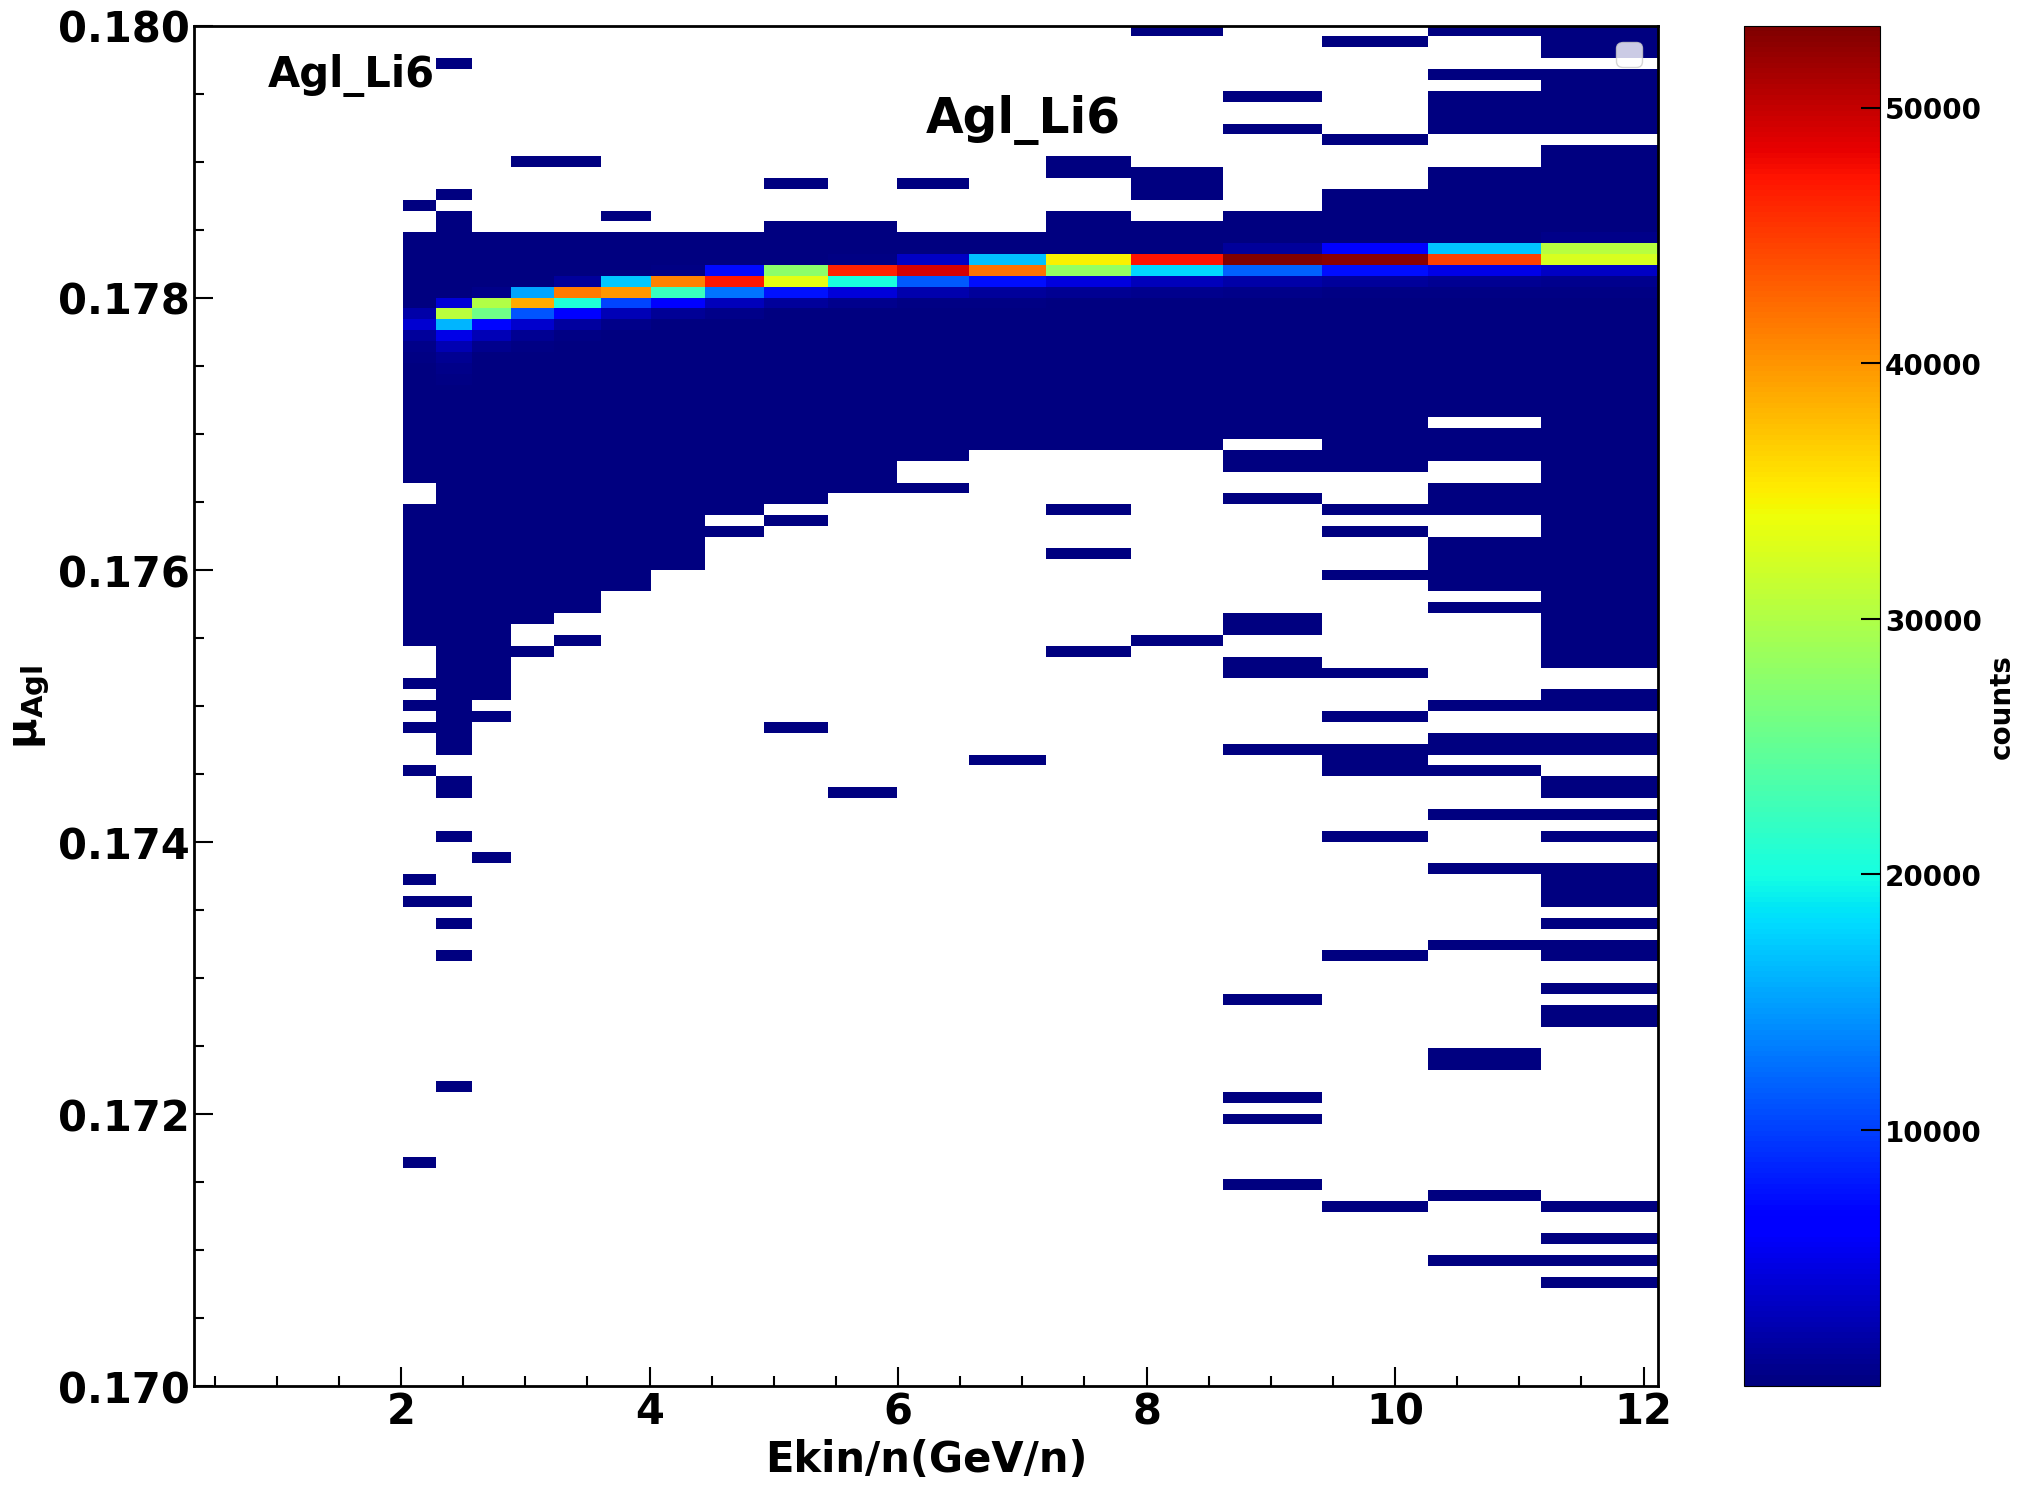

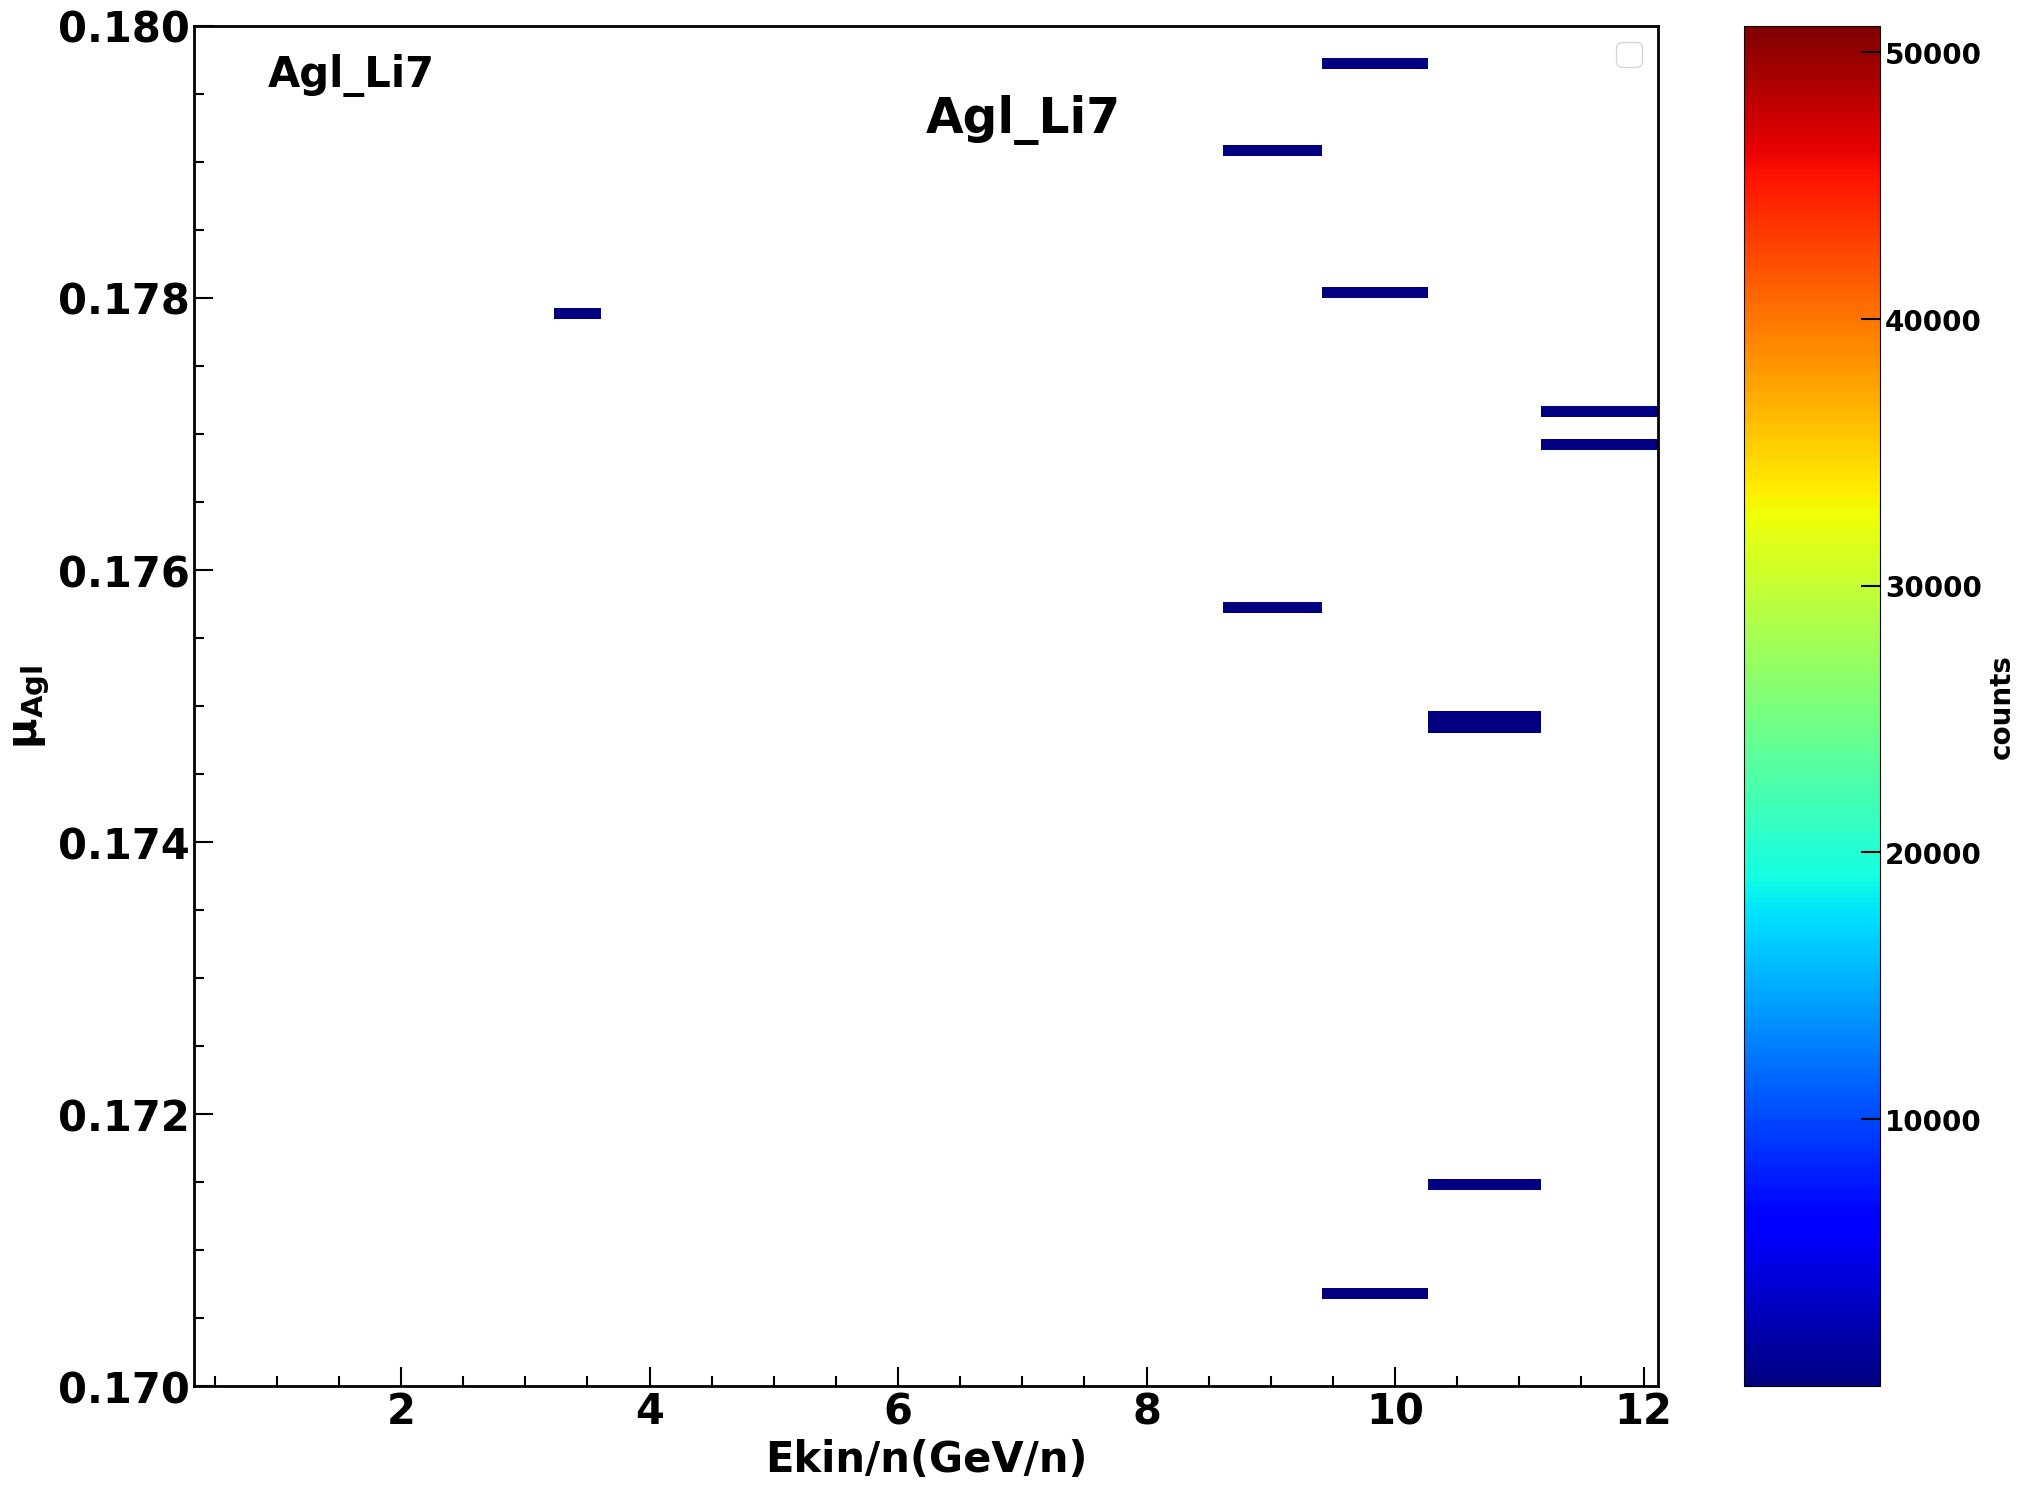

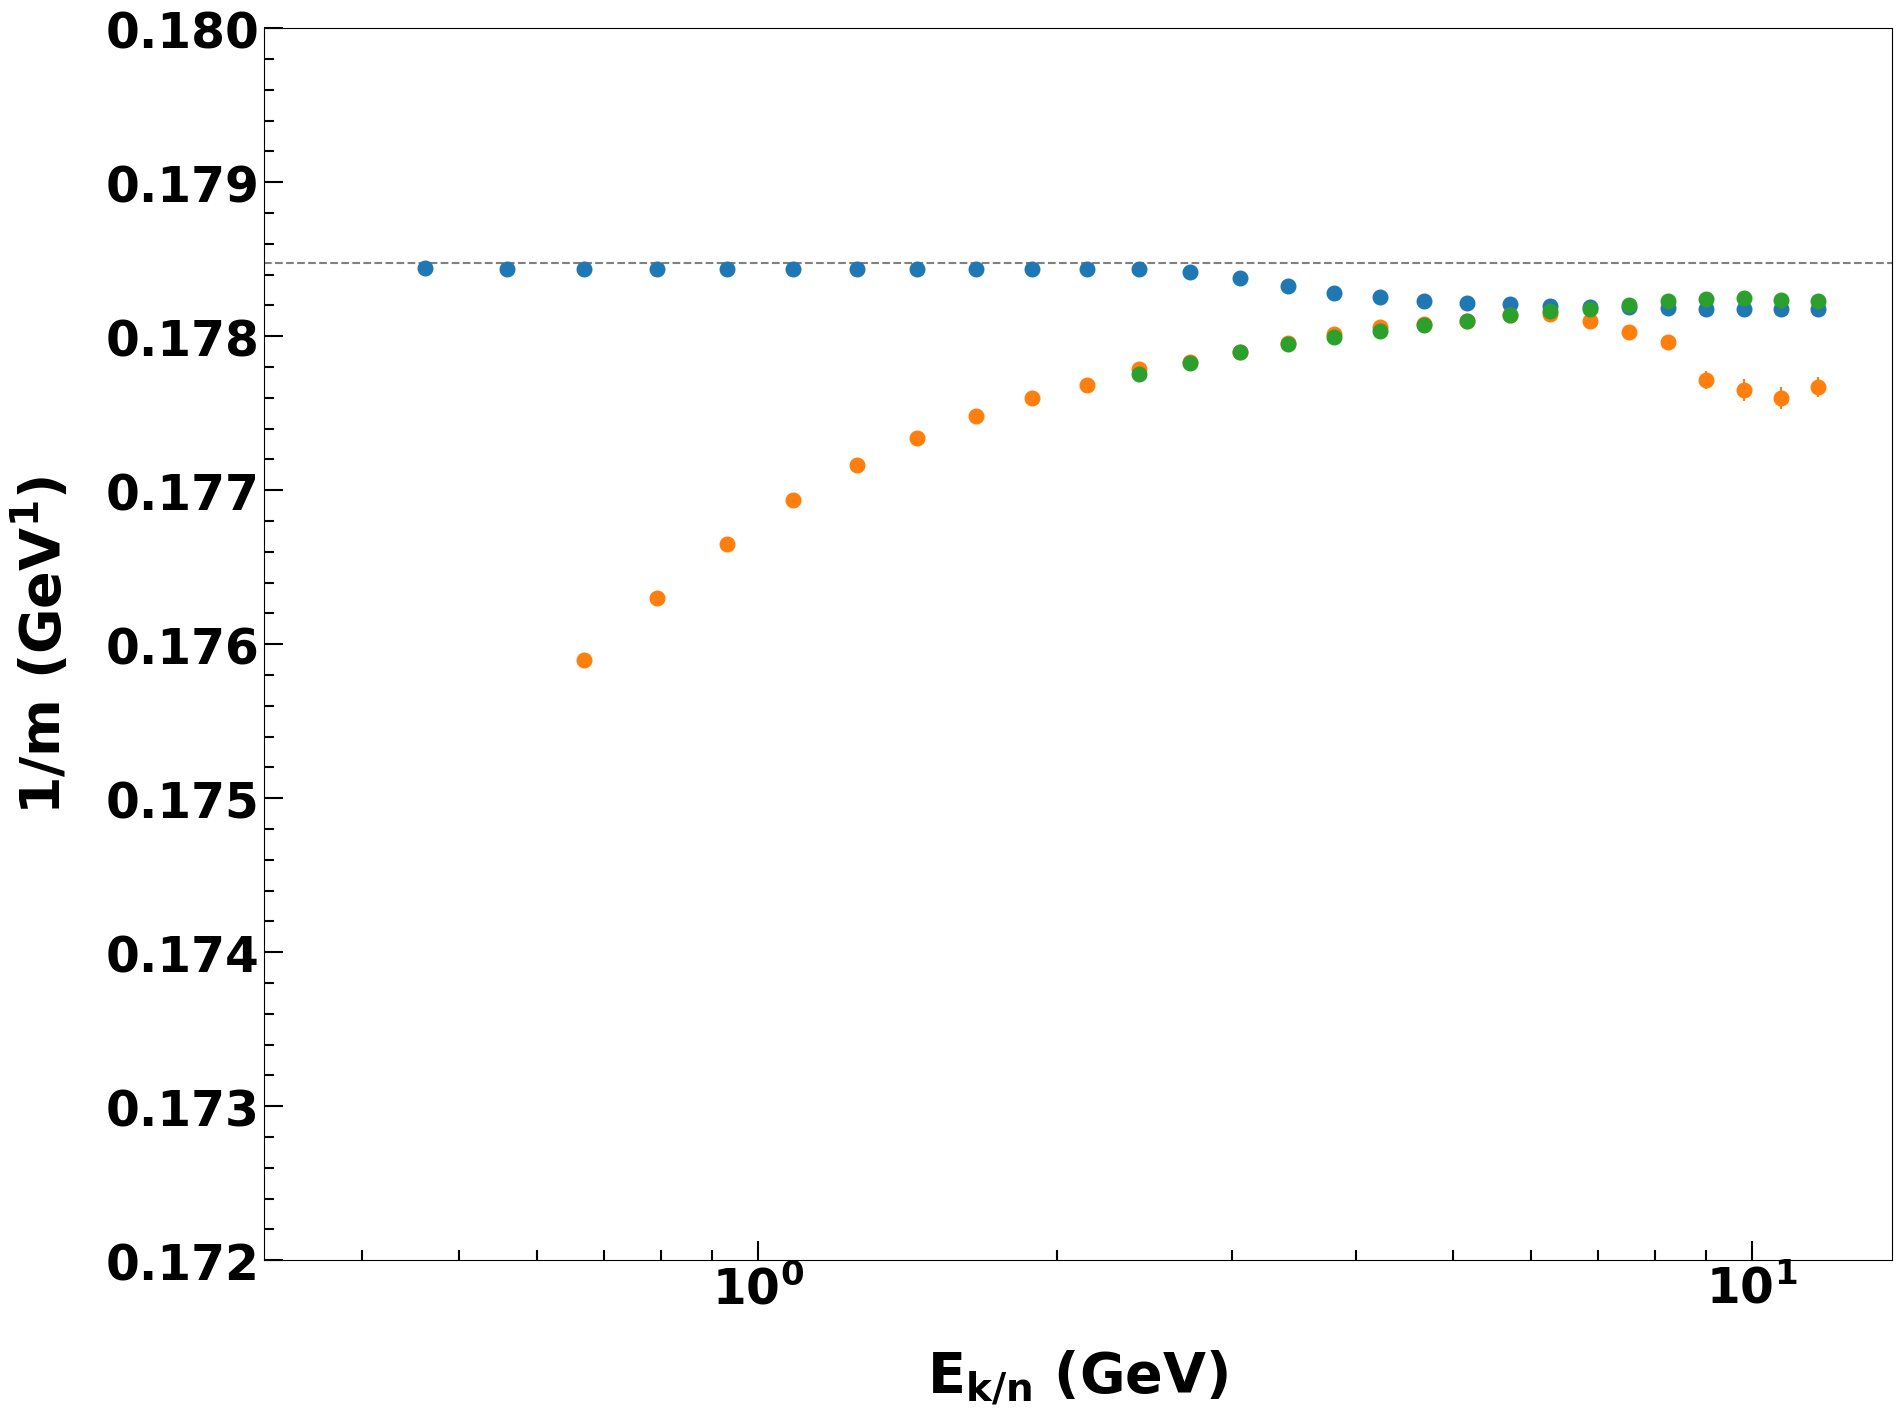

In [3]:
ylimvalue = {'Li6':[0.12, 0.2], 'Li7':[0.12, 0.16]}
df = np.load(f'{filename_hist}')
detectors = ['Tof', 'NaF', 'Agl']
hist2d= {dec: {} for dec in detectors}
hist_counts2 = {dec: {} for dec in detectors}

mean_mass = {dec: {} for dec in detectors}
graph_true_meanmass =  {dec: {} for dec in detectors}
dictsave = {}
for dec in detectors:
    for iso in isotopes:
        fig, ax1 = plt.subplots(1, 1, figsize=(21, 16))
        hist2d[dec][iso] = WeightedHistogram.from_file(df, f'{iso}MC_{dec}_truemass_atdec')    
        
        mean_mass[dec][iso], std_mass = get_hist_meanstd(hist2d[dec][iso])
        graph_true_meanmass[dec][iso] = MGraph(hist2d[dec][iso].binnings[0].bin_centers[1:-1], mean_mass[dec][iso], std_mass)
        #print(graph_true_meanmass[dec][iso])
        graph_true_meanmass[dec][iso].add_to_file(dictsave, f'graph_truemass_mean_{dec}{iso}')
        
        plot2dhist(fig, ax1, xbinning=hist2d[dec][iso].binnings[0].edges[1:-1],
                       ybinning=hist2d[dec][iso].binnings[1].edges[1:-1],
                       counts=hist2d[dec][iso].values[1:-1, 1:-1], 
                       ylabel=f"$\mathrm{{\mu_{{{dec}}} }}$", xlabel='Ekin/n(GeV/n)', zlabel="counts", zmin=None, zmax=None, 
                       setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=False)  
        ax1.text(0.05, 0.98, f"{dec}_{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left',transform=ax1.transAxes, color="black", fontweight="bold") 
        
        ax1.legend(fontsize=23)
        ax1.text(0.5, 0.95, f'{dec}_{iso}', fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
        ax1.set_ylim(ylimvalue[iso])
        ax1.set_ylim([0.17, 0.18])
        #ax1.set_ylim([0, 1.1*max(hist_counts[dec]['Be7'].values)])
        savefig_tofile(fig, plotfile, f"masstrue_{dec}_{iso}", show=True)

np.savez('/home/manbing/Documents/lithiumanalysis/slides/plots/Study_LiBoron_energy_loss_mean/graph_truemass_mean.npz', **dictsave)
fig, ax1 = plt.subplots(1, 1, figsize=(21, 16))
for dec in detectors:
    plot_graph(fig, ax1, graph_true_meanmass[dec]['Li6'], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=r"MC True")

SetAx1Axis(ax1, r'$\mathrm{E_{k/n} \ (GeV)}$',r'1/m ($\mathrm{GeV^{1}}$)', TEXTSIZE, xlimrange= None, ylimrange=[0.172, 0.18], custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False, setylog=False, setxlog=True)
ax1.axhline(y=1/ISOTOPES_MASS['Li6'], color='grey', linestyle='--', label='Li6 nominal mass')        


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


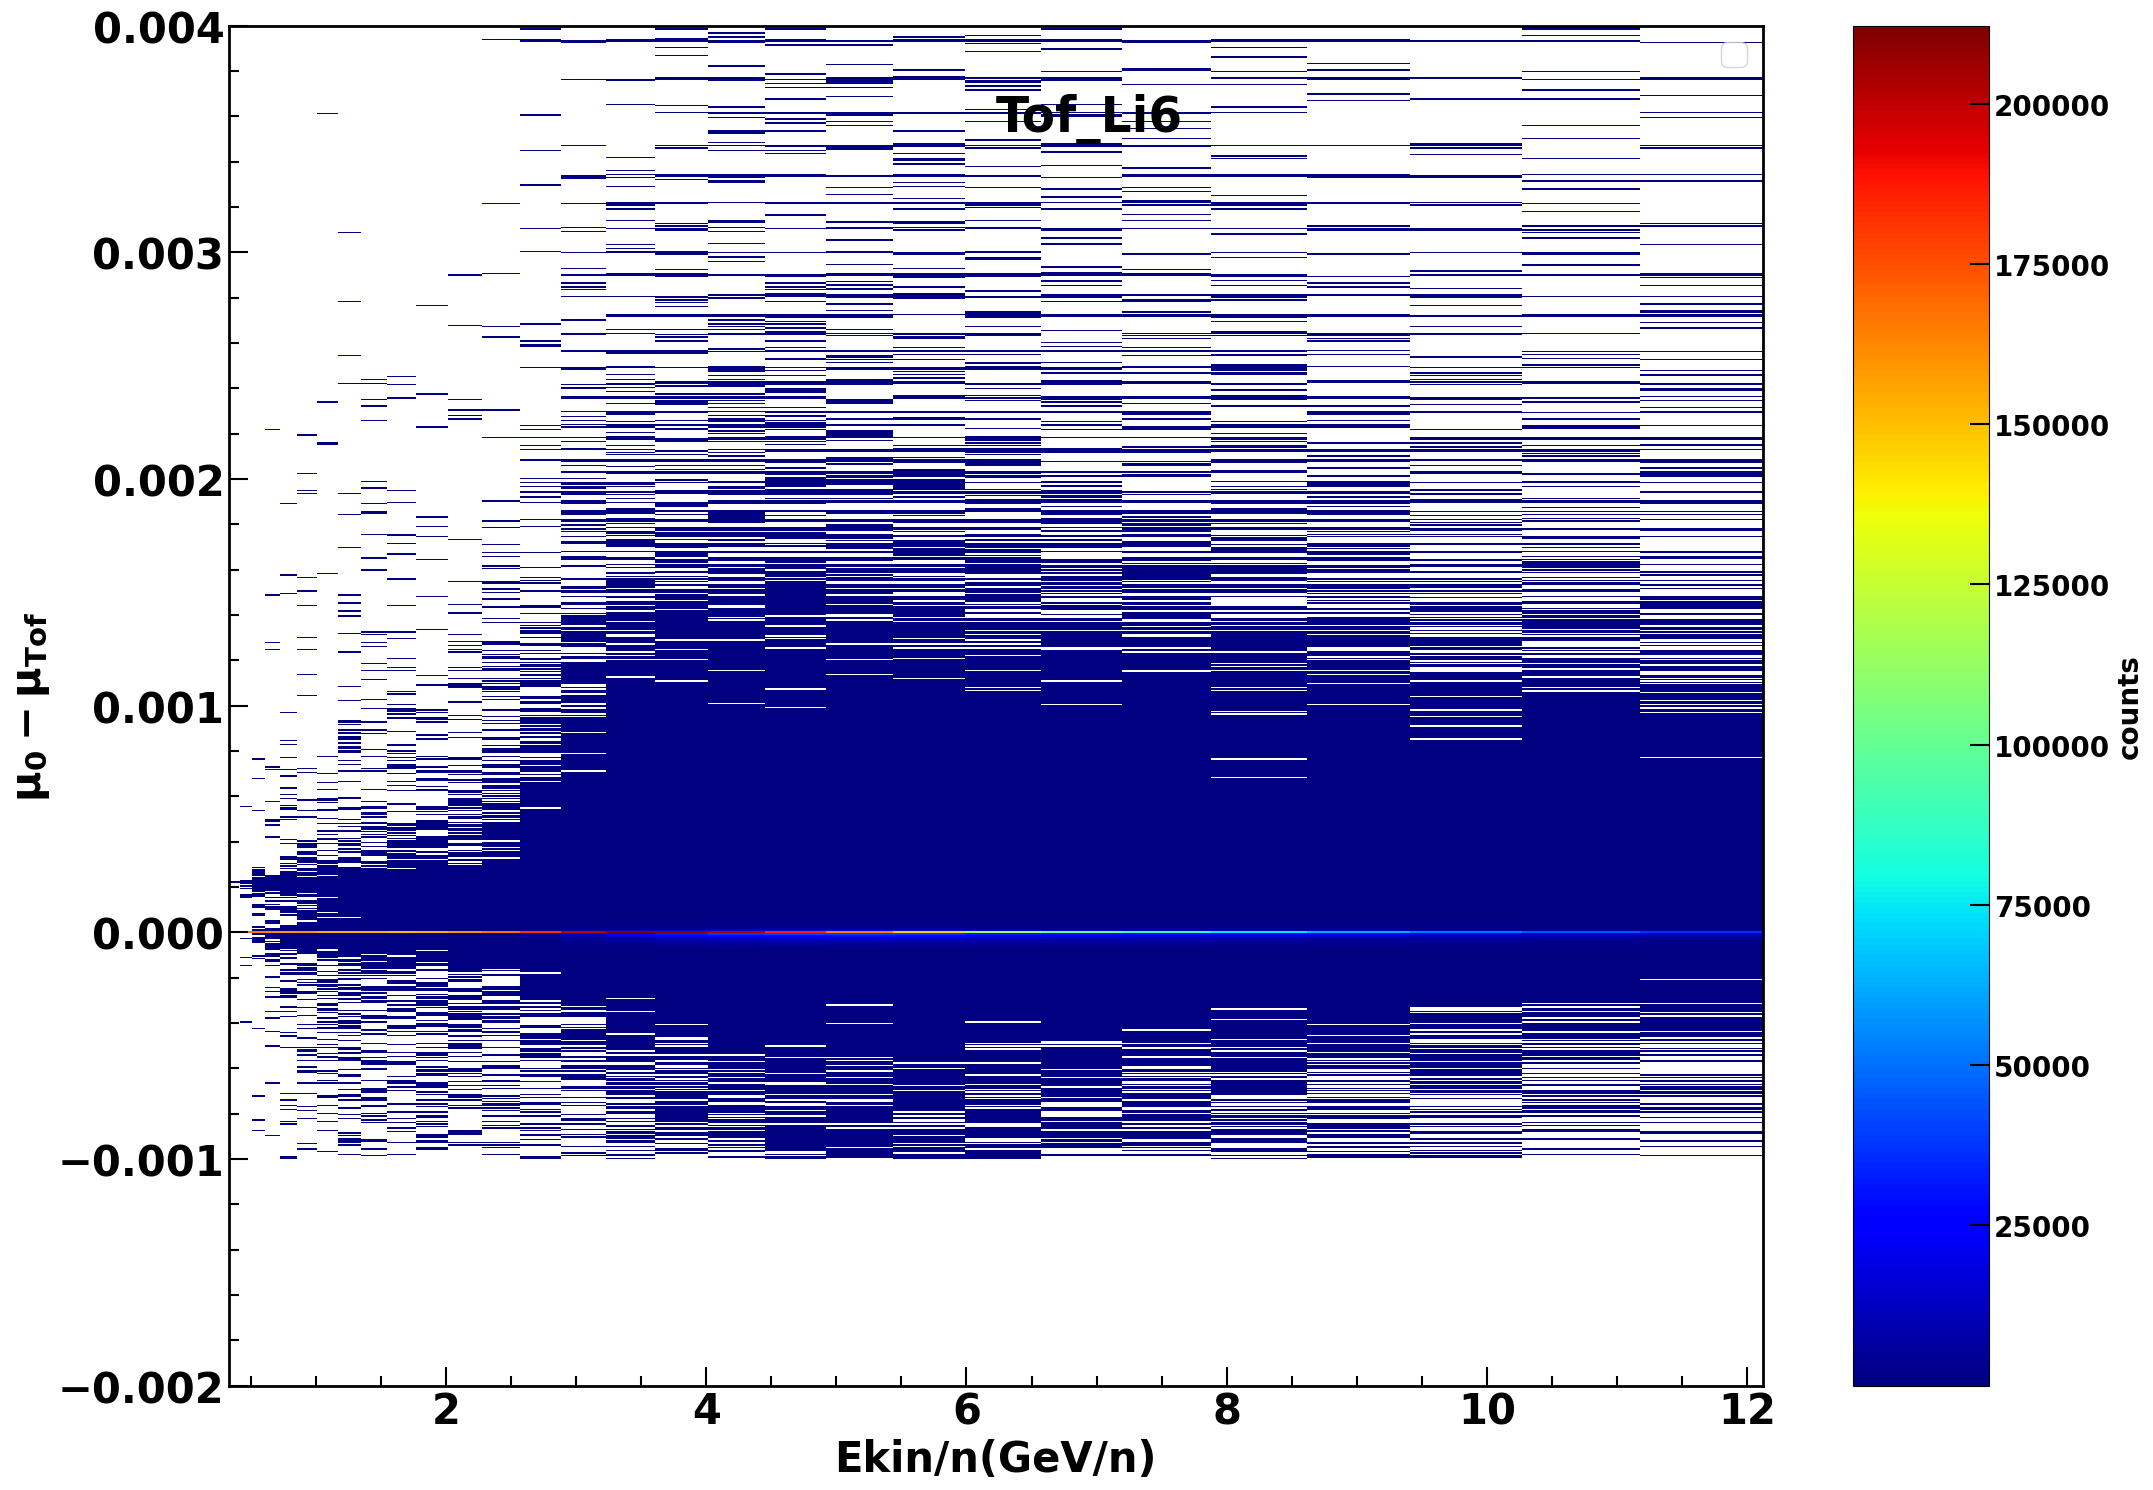

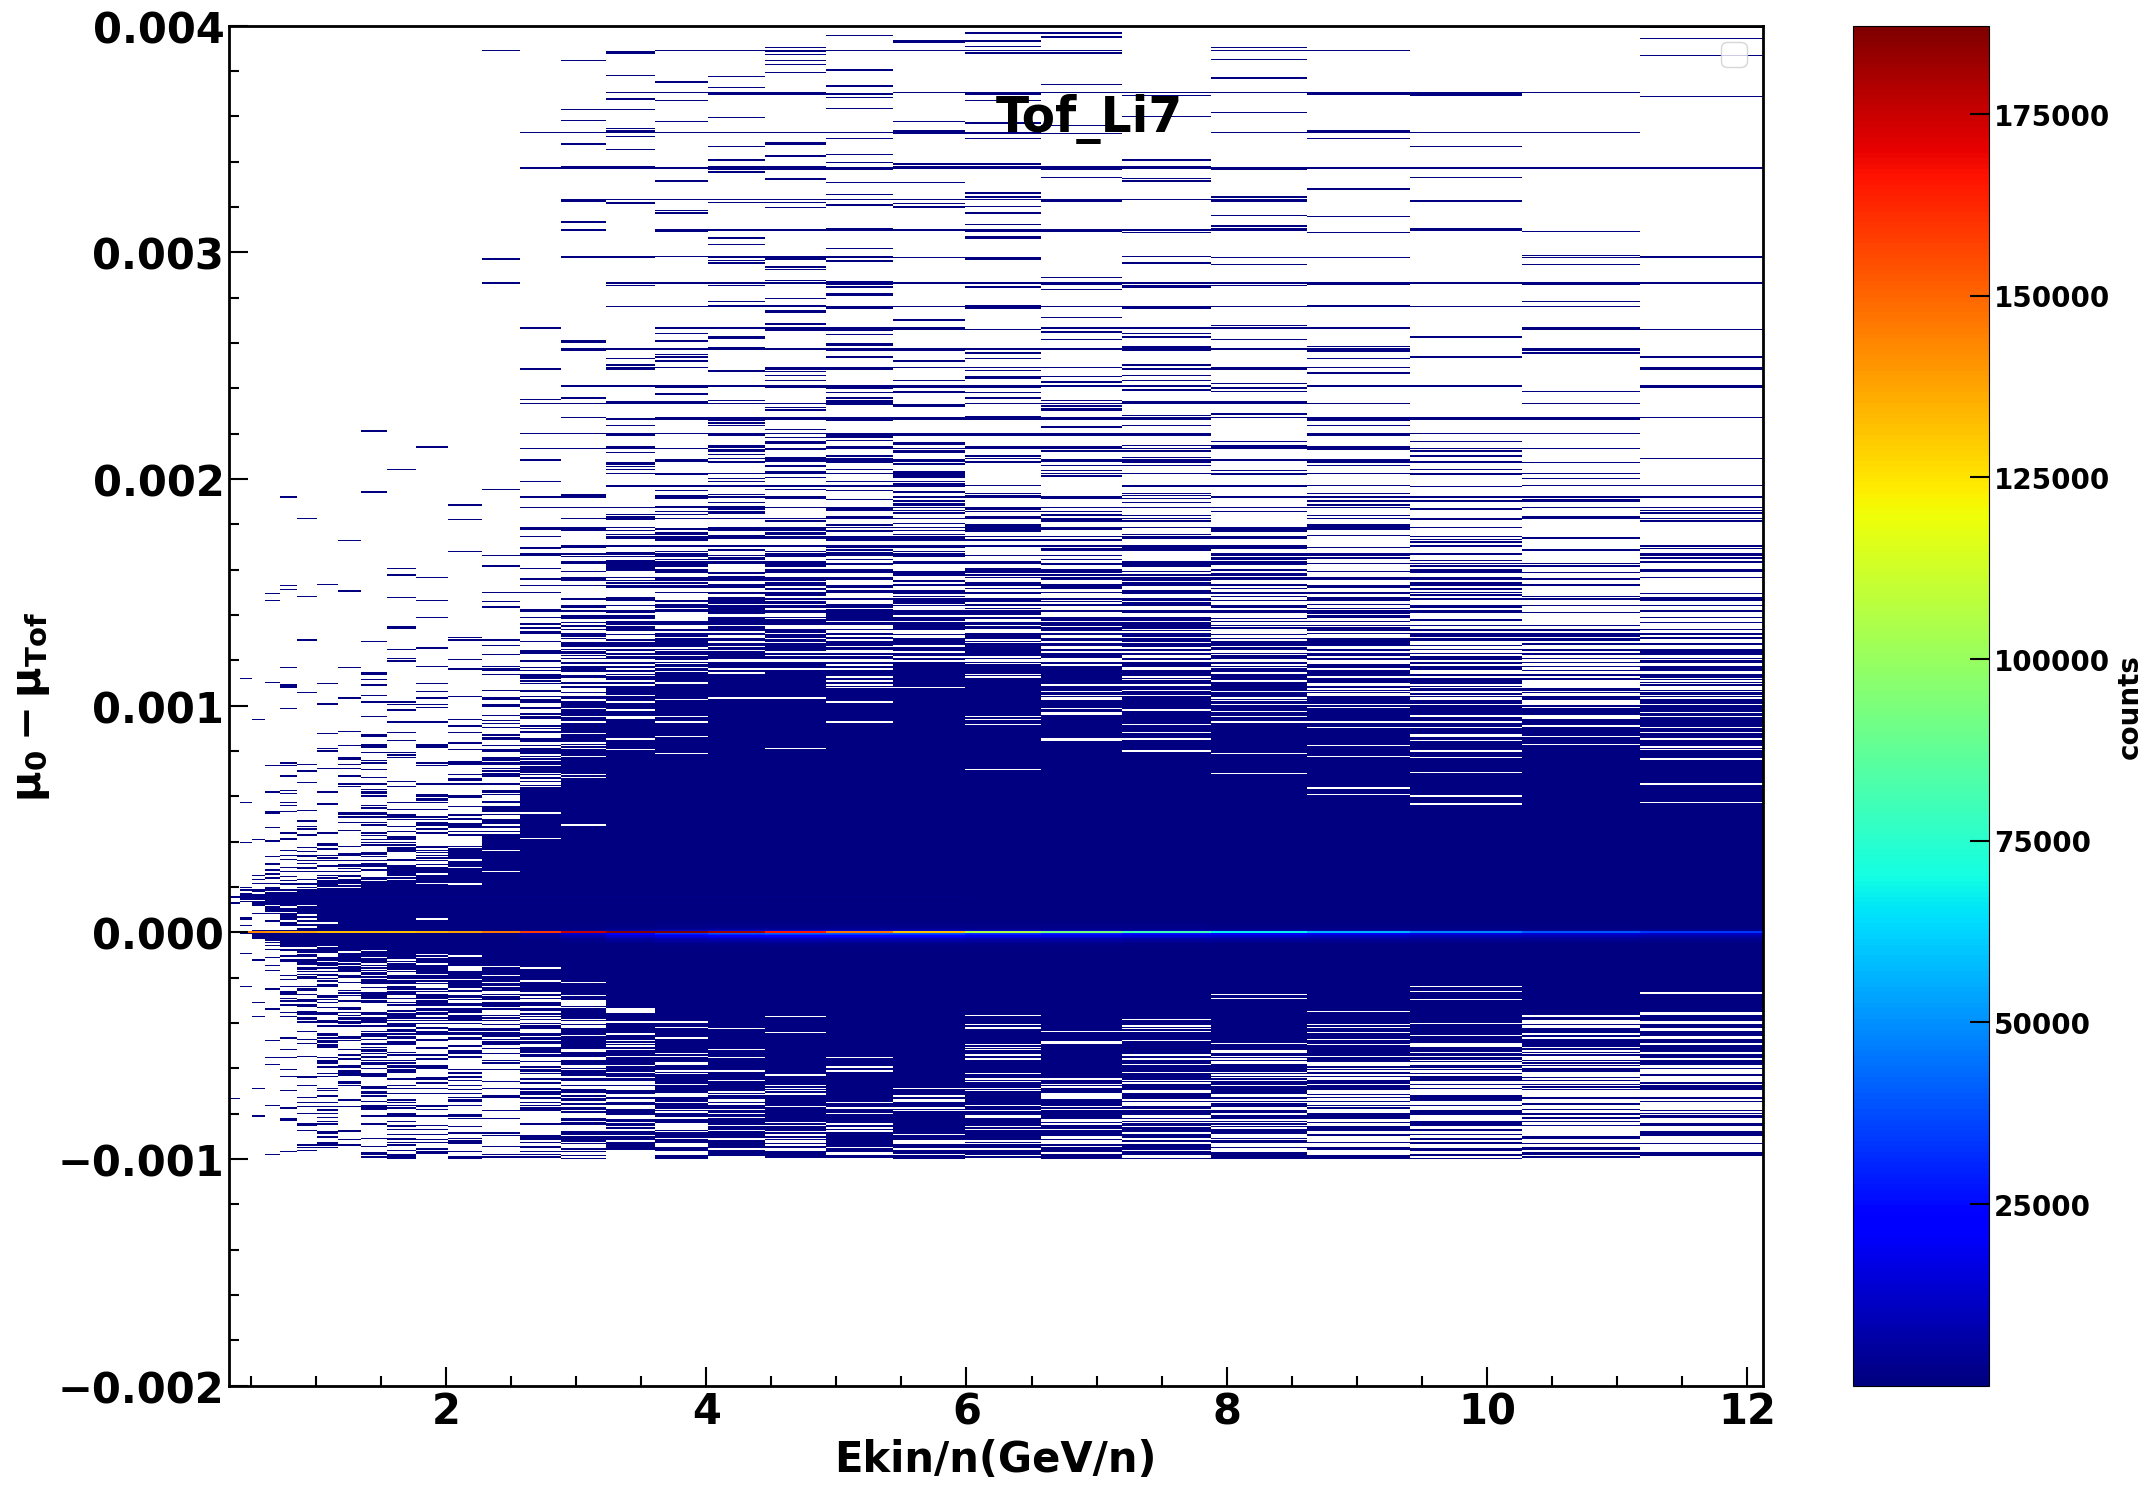

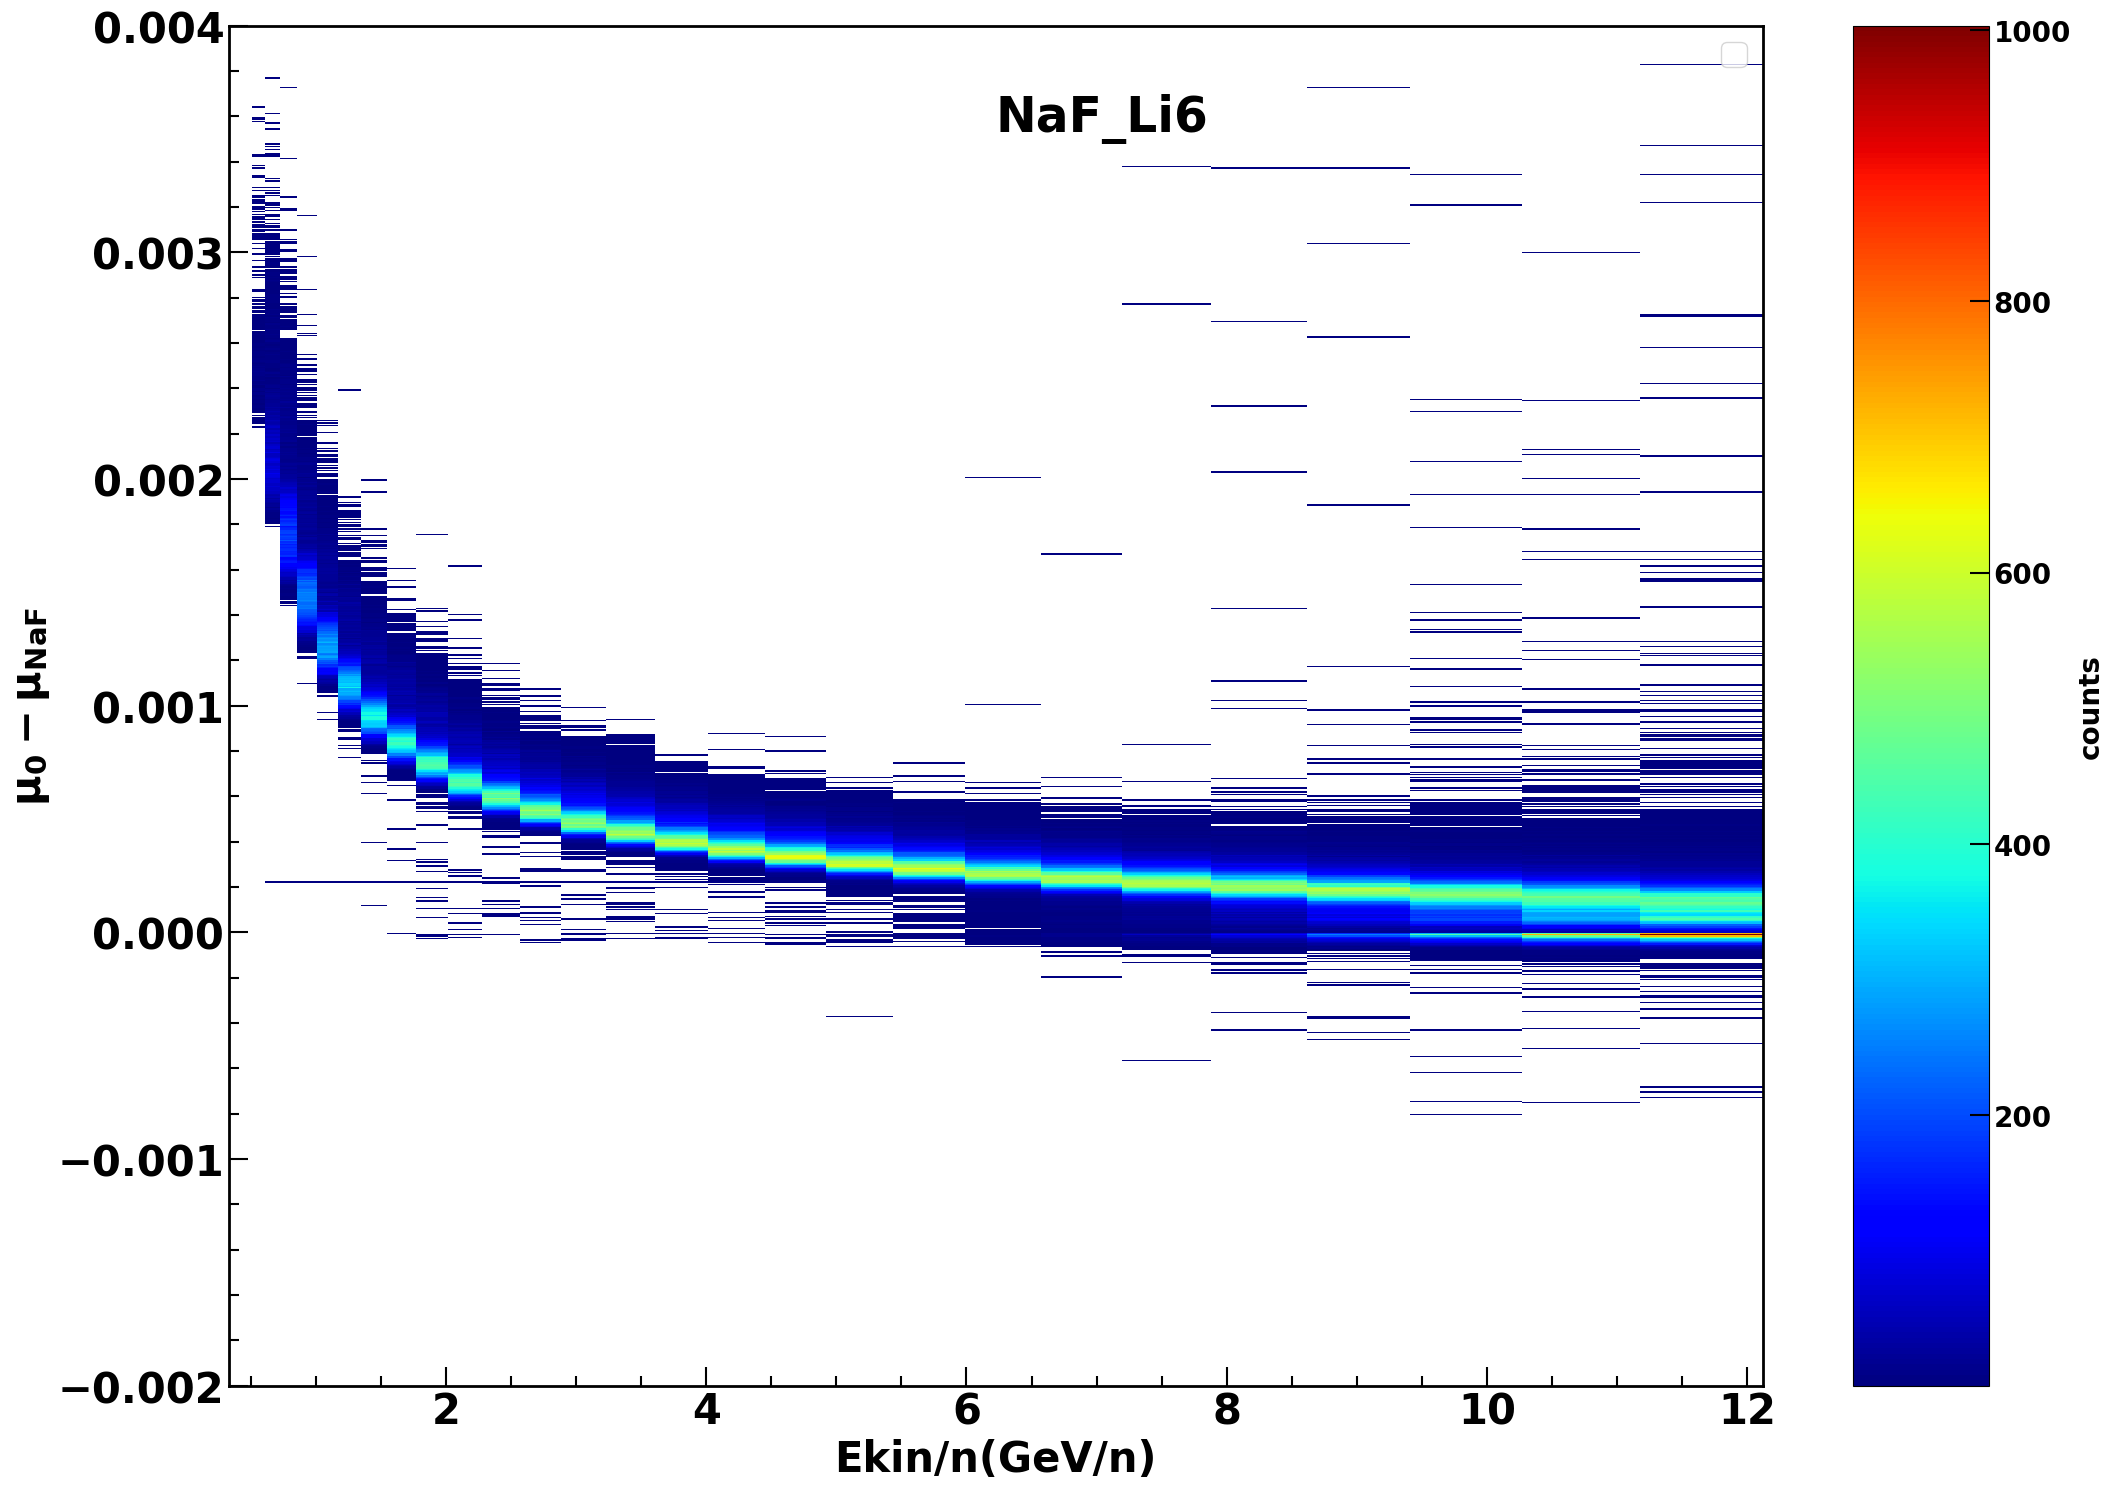

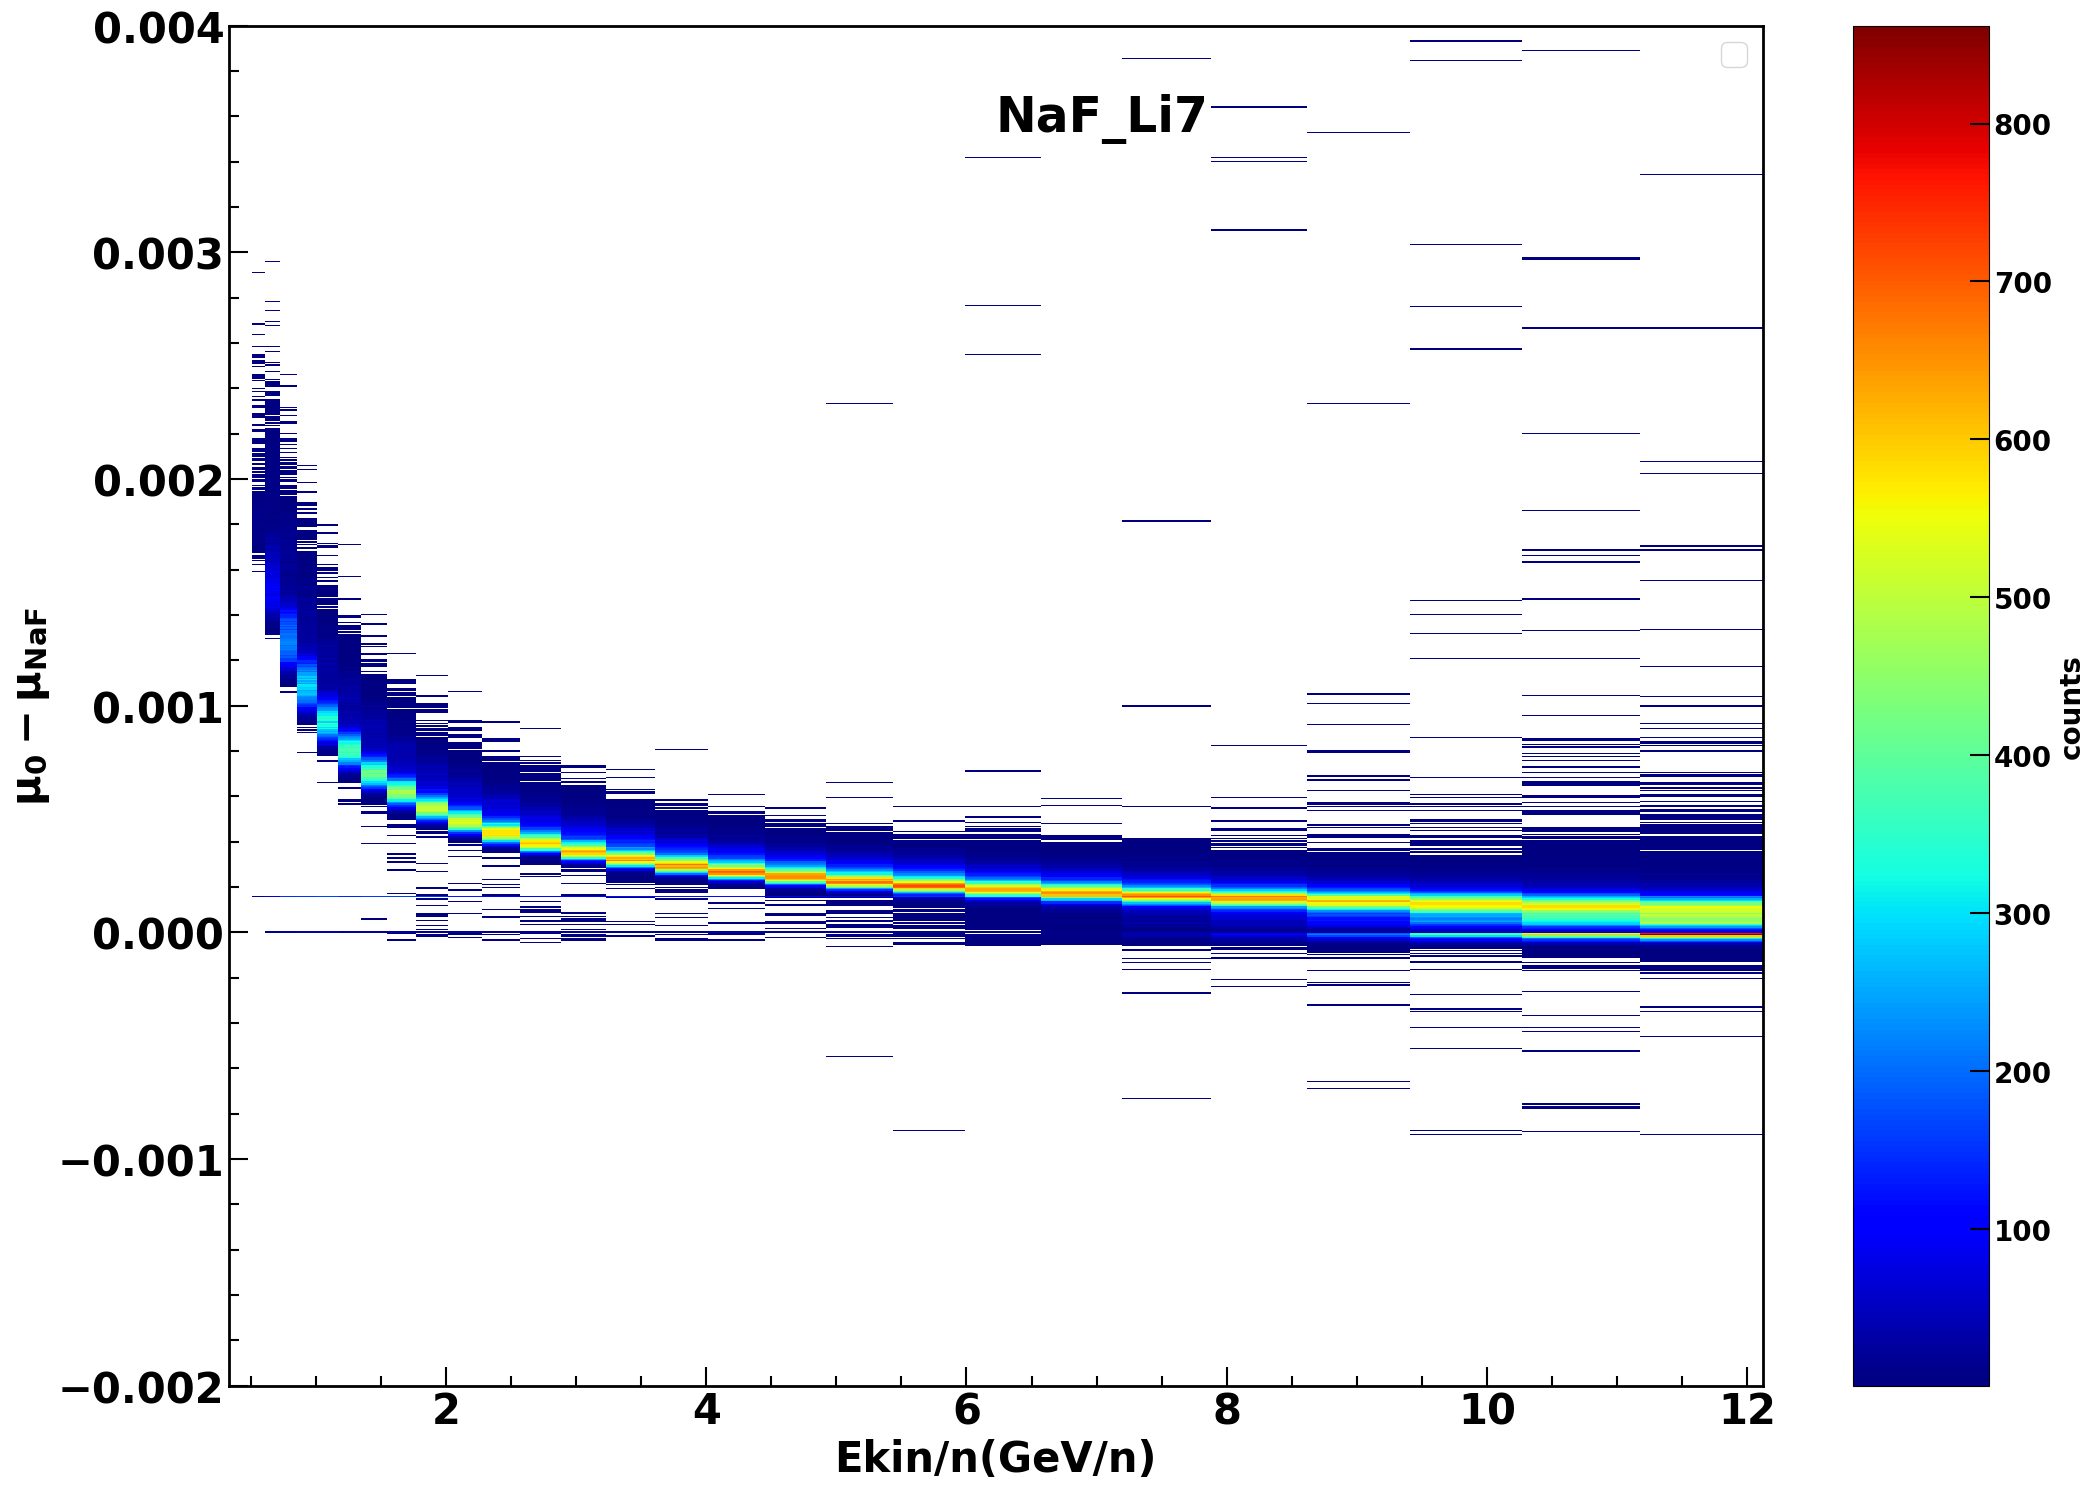

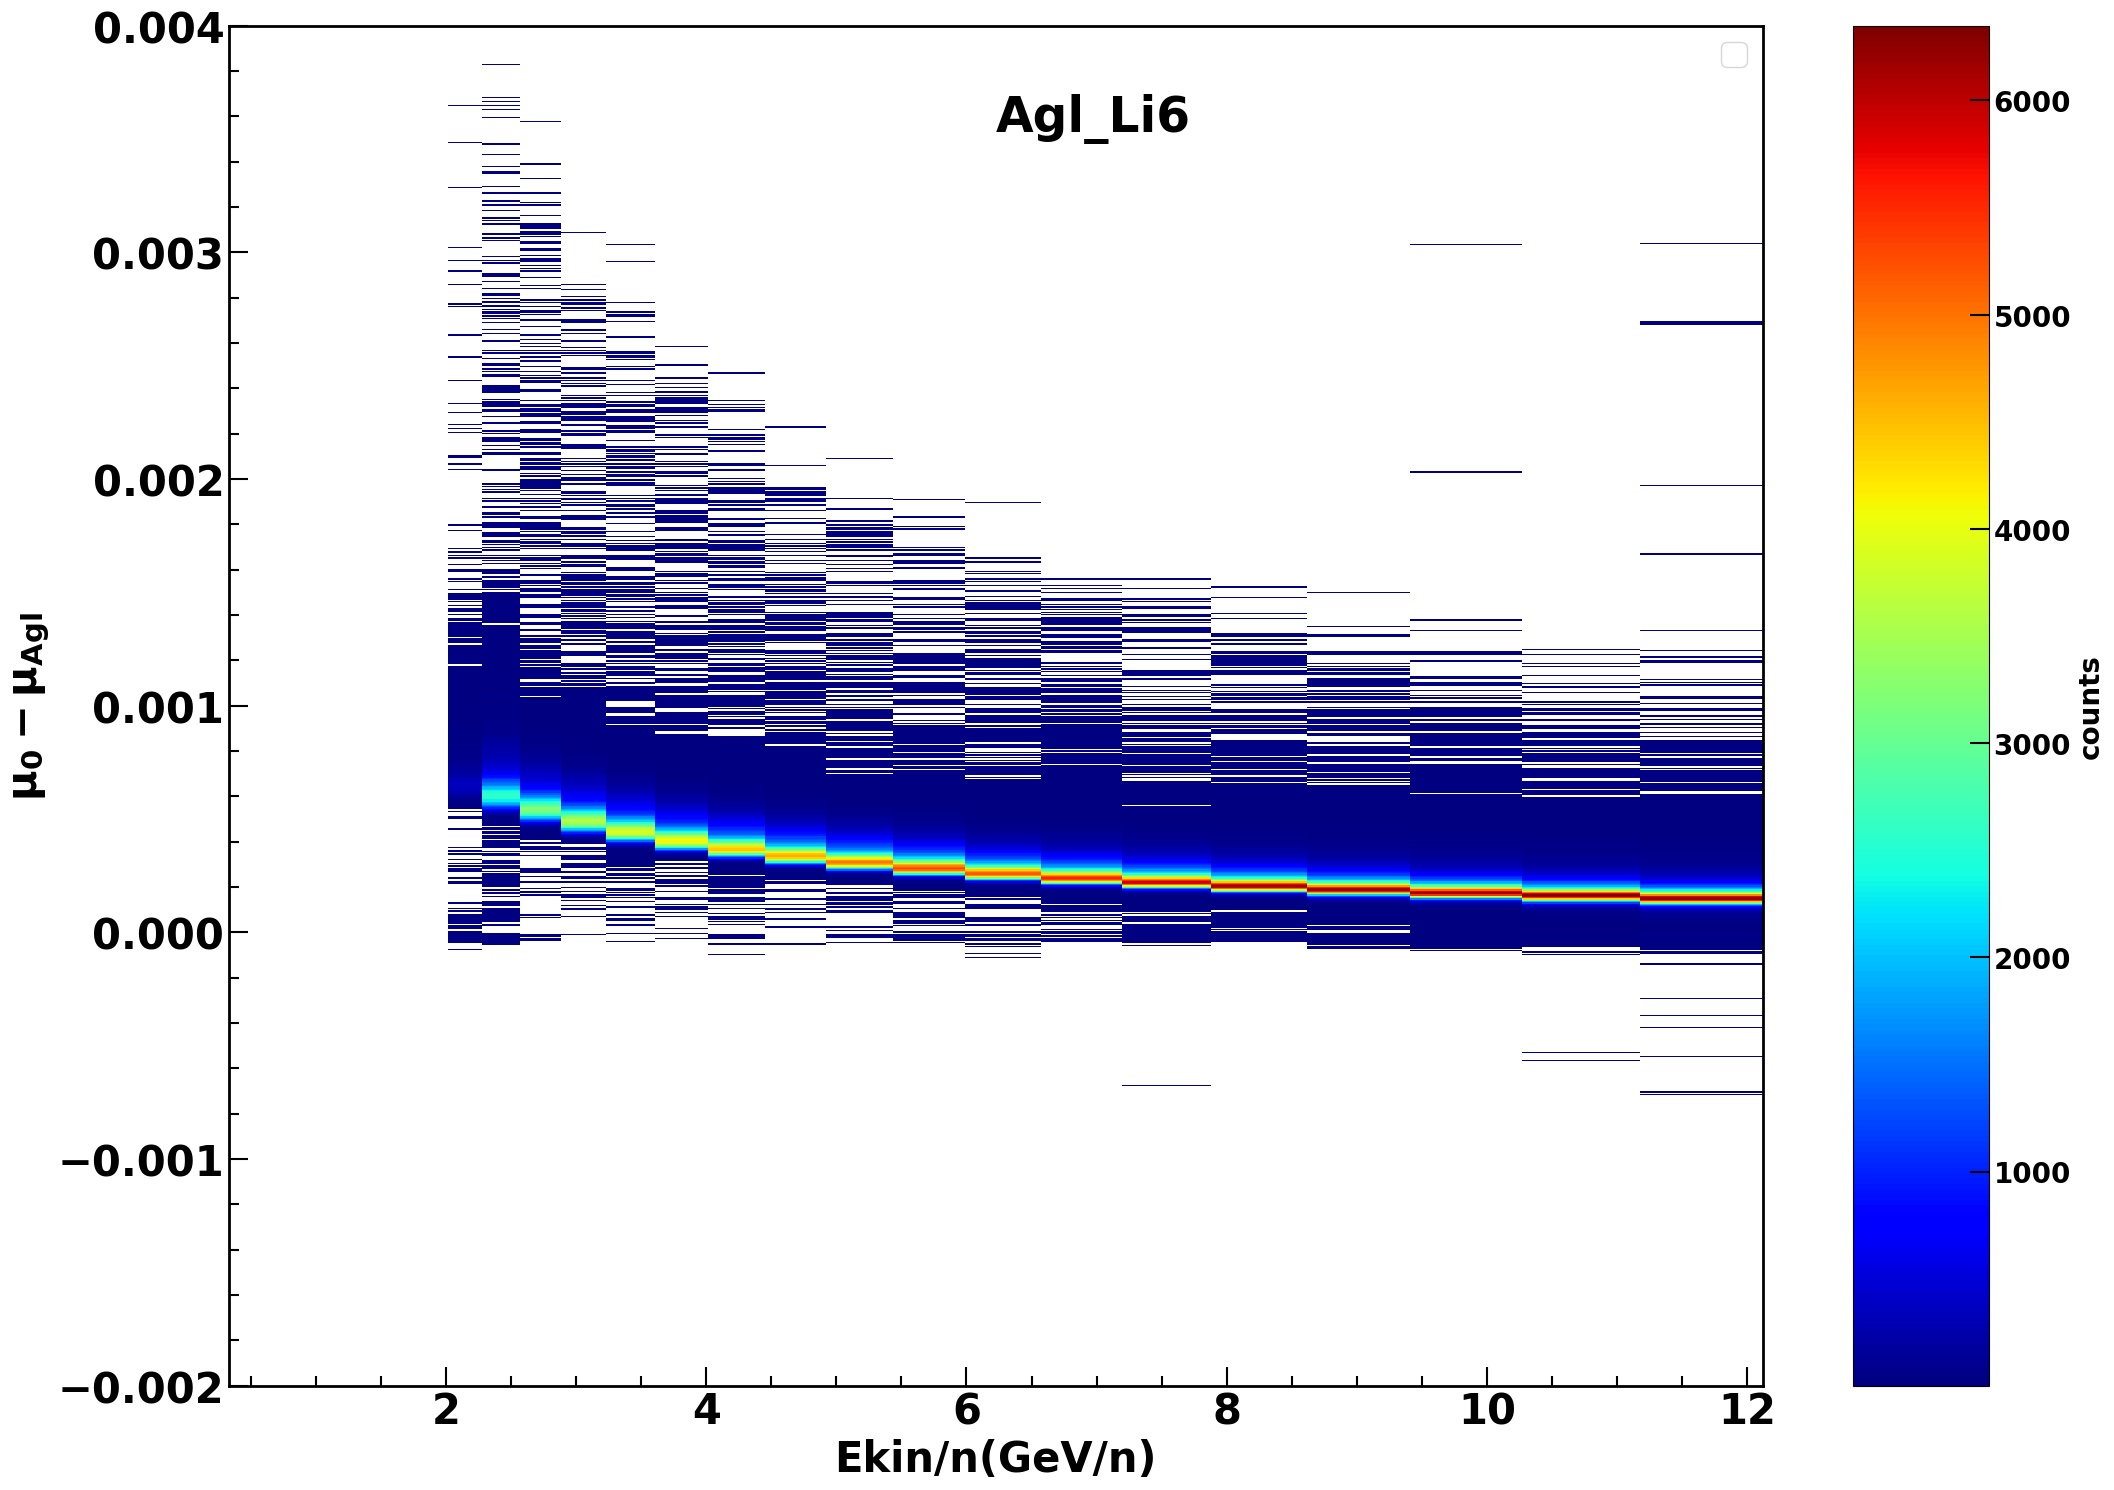

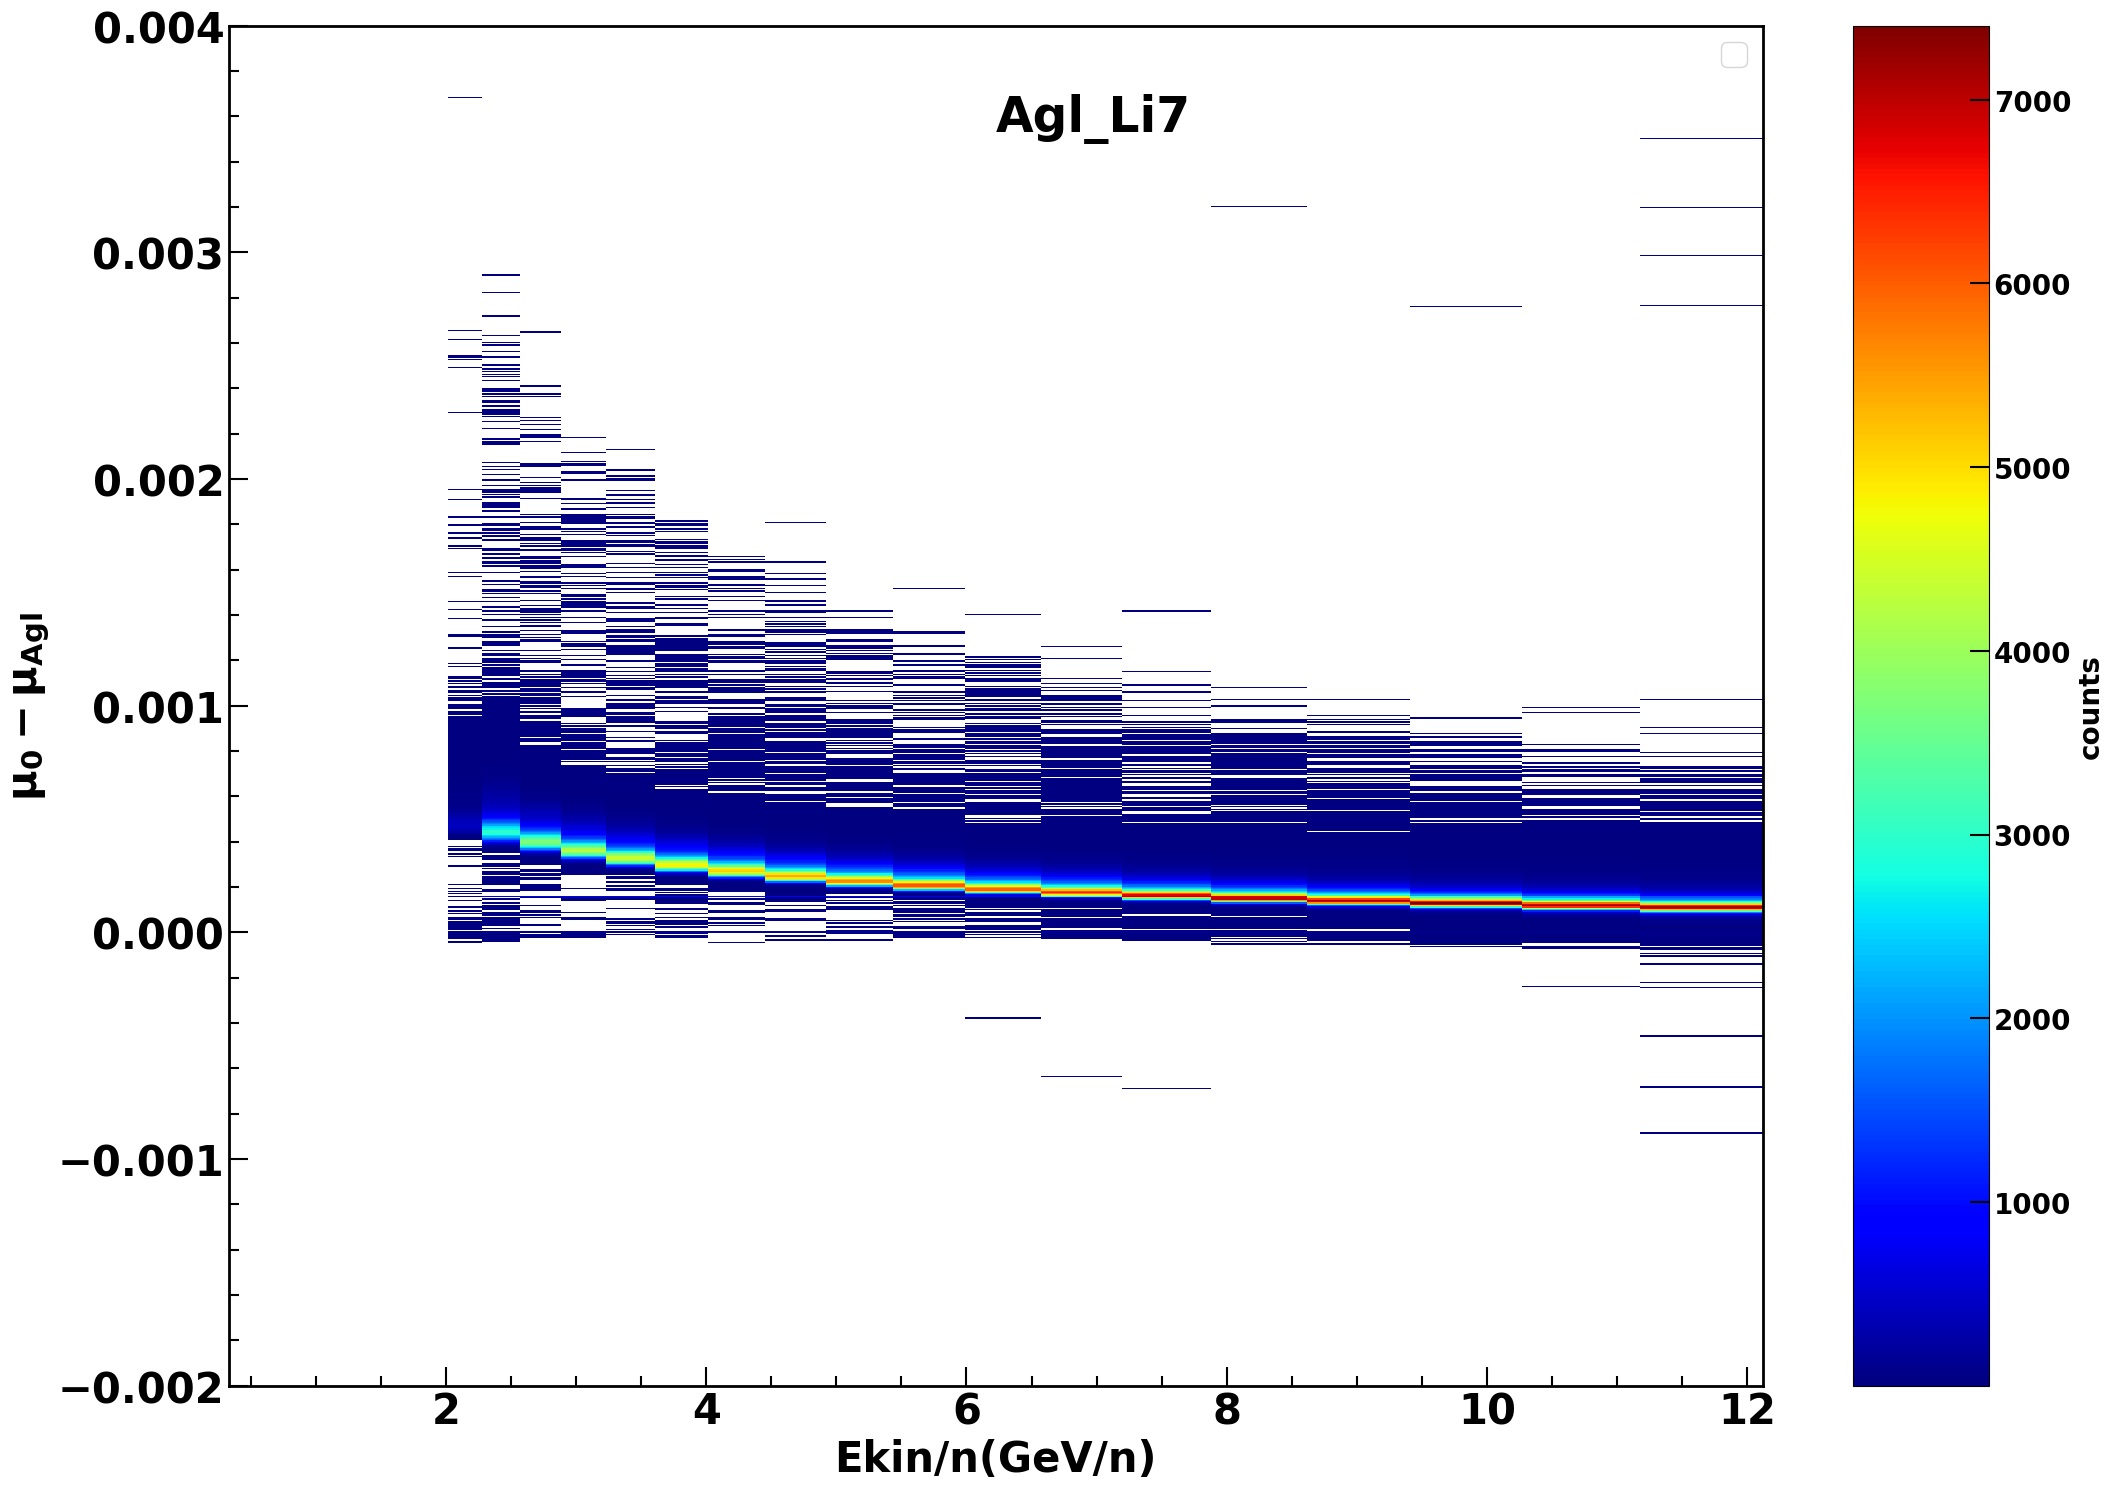

In [4]:
df = np.load(f'{filename_hist}')
detectors = ['Tof', 'NaF', 'Agl']
hist2d= {dec: {} for dec in detectors}
hist_counts2 = {dec: {} for dec in detectors}
isotopes = ISOTOPES[nuclei]
deltamass = {dec: {} for dec in detectors}
std_deltamass = {dec: {} for dec in detectors}
mpvdeltamass = {dec: {} for dec in detectors}
graph_deltamass =  {dec: {} for dec in detectors}
for dec in detectors:
    for iso in isotopes:
        fig, ax1 = plt.subplots(1, 1, figsize=(22, 16))
        hist2d[dec][iso] = WeightedHistogram.from_file(df, f'{iso}MC_{dec}_deltamass')    
        
        deltamass[dec][iso], std_deltamass[dec][iso] = get_hist_meanstd(hist2d[dec][iso])
        
        mpvdeltamass[dec][iso] = hist2d[dec][iso].binnings[1].bin_centers[np.argmax(hist2d[dec][iso].values[1:-1, 1:-1], axis=1)]
        #print(deltamass[dec][iso])
        #print(mpvdeltamass[dec][iso])
        graph_deltamass[dec][iso] = MGraph(hist2d[dec][iso].binnings[0].bin_centers[1:-1], deltamass[dec][iso], std_deltamass[dec][iso])
        
        plot2dhist(fig, ax1, xbinning=hist2d[dec][iso].binnings[0].edges[1:-1],
                      ybinning=hist2d[dec][iso].binnings[1].edges[1:-1],
                      counts=hist2d[dec][iso].values[1:-1, 1:-1], 
                       ylabel=f"$\mathrm{{\mu_{{0}}-\mu_{{{dec}}} }}$", xlabel='Ekin/n(GeV/n)', zlabel="counts", zmin=None, zmax=None, 
                       setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=False)  
        #ax1.text(0.05, 0.98, f"{dec}_{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left',transform=ax1.transAxes, color="black", fontweight="bold") 
        
        ax1.legend(fontsize=23)
        ax1.text(0.5, 0.95, f'{dec}_{iso}', fontsize=35, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
        #ax1.set_ylim(ylimvalue[iso])
        ax1.set_ylim([-0.002, 0.004])
        #ax1.set_ylim([0, 1.1*max(hist_counts[dec]['Be7'].values)])
        #plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_2009/plots_2009'
        savefig_tofile(fig, plotfile, f"deltamass_{dec}_{iso}", show=True)

/home/manbing/Documents/lithiumanalysis/slides/plots/Study_LiBoron_energy_loss_mean


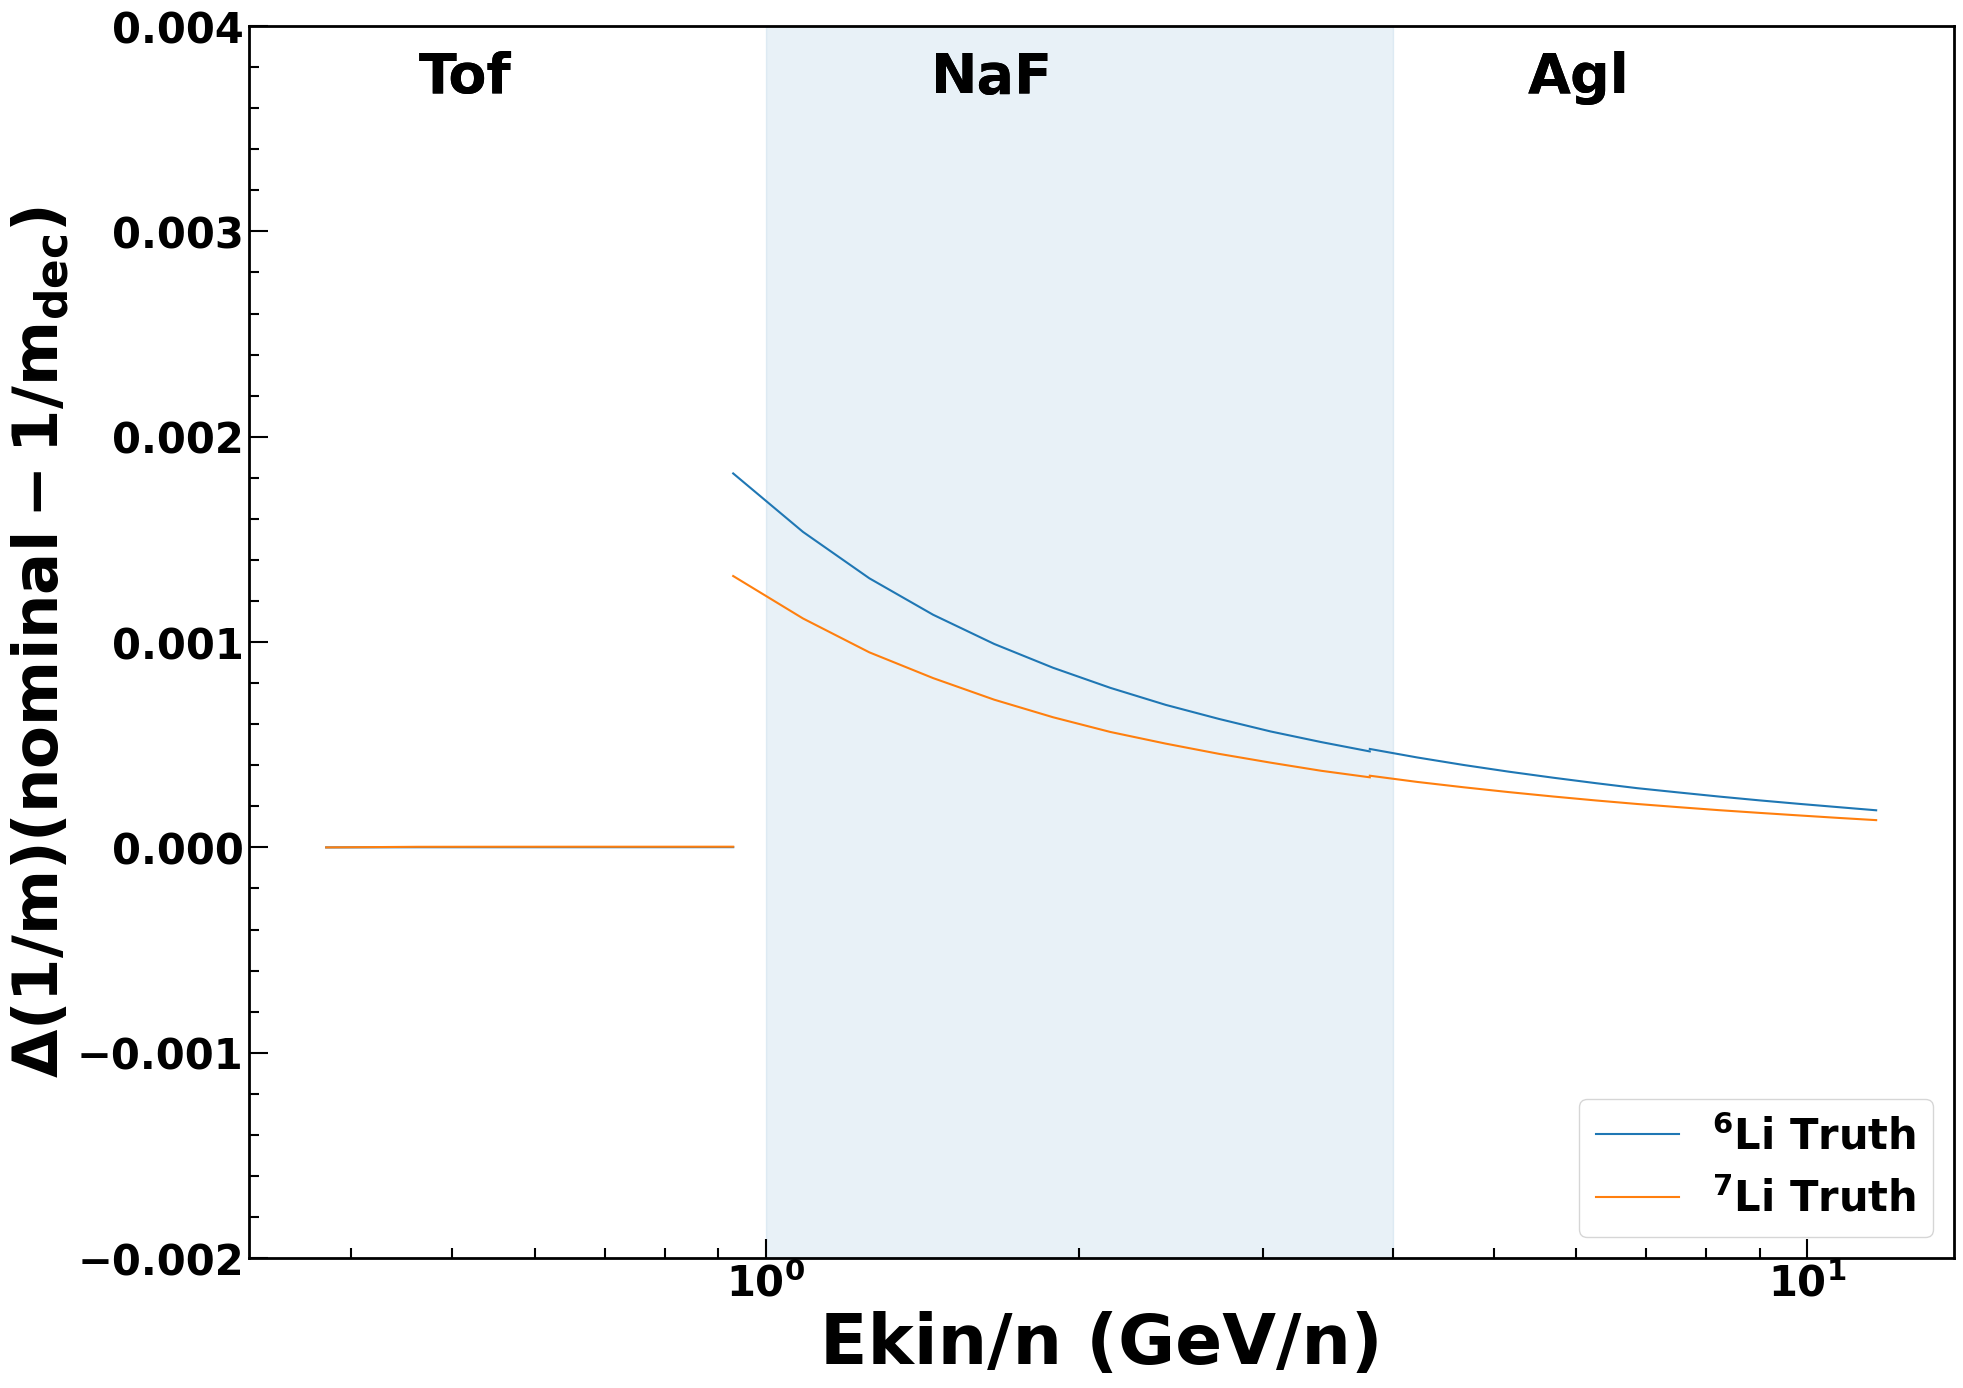

In [5]:
xlimvalue = {'Tof': [0, 1], 'NaF':[1.0, 4.0], "Agl":[4.0, 12]}
ylimvalue = {'Tof': [-0.0001, 0.0001], 'NaF':[-0.001, 0.004], "Agl":[0.00, 0.001]}

fitmcgausfile = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCMassGaus_Untuned'
graph_mean_gausfit = {dec: {} for dec in detectors}
graph_deltamass_gausfit = {dec: {} for dec in detectors}
subgraph_deltamass_gausfit = {dec: {} for dec in detectors}
#with np.load(os.path.join(fitmcgausfile, "graph_gausfit_MCMass_Be.npz")) as dfile:
#    for dec in detectors:
#        for iso in isotopes:
            #graph_mean_gausfit[dec][iso] = MGraph.from_file(dfile, f'graph_{dec}{iso}_mean')
            #graph_deltamass_gausfit[dec][iso] = MGraph(graph_mean_gausfit[dec][iso].xvalues, 1/ISOTOPES_MASS[iso]-graph_mean_gausfit[dec][iso].yvalues, graph_mean_gausfit[dec][iso].yerrs)
            #subgraph_deltamass_gausfit[dec][iso] = slice_graph_by_value(graph_deltamass_gausfit[dec][iso], xlimvalue[dec])
            
            #print(graph_mean_gausfit[dec][iso])
            #print(1/ISOTOPES_MASS[iso]-graph_mean_gausfit[dec][iso].yvalues)

xaxistext = {'Tof': 0.1, 'NaF': 0.4, 'Agl': 0.75}
fig, ax1 = plt.subplots(1, 1, figsize= (22, 16))
subgraph_deltamass = {dec: {} for dec in detectors}
for dec in detectors:
    for iso in isotopes:
        #print(graph_deltamass[dec][iso])
        
        subgraph_deltamass[dec][iso] = slice_graph_by_value( graph_deltamass[dec][iso], xlimvalue[dec])
        
        plot_graph(fig, ax1, subgraph_deltamass[dec][iso], color=ISOTOPES_COLOR[iso], style="hist", xlog=False, ylog=False, scale=None, markersize=21, label=f"{ISO_LABELS[iso]} Truth" if dec == 'Tof' else None)
        ax1.set_ylabel(f"$\mathrm{{ \Delta (1/m) (nominal -1/m_{{dec}}) }}$", fontsize=45)
        
        ax1.set_xlabel('Ekin/n (GeV/n)', fontsize=50)
        #ax1.set_ylim(ylimvalue[dec])
        ax1.set_ylim([-0.002, 0.004])
        #ax1.legend()
        set_plot_defaultstyle(ax1)
        ax1.set_xscale('log')
        ax1.legend(loc='lower right')
        ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")
        #ax1.text(0.05, 0.98, f"{DETECTOR_LABEL[dec]}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold") 
ax1.fill_betweenx(np.linspace(-0.002, 0.006, 100), 1.0, 4.0, alpha=0.1, color="tab:blue")
print(plotfile)
savefig_tofile(fig, plotfile, f"graph_deltamean_compare_mcTruthReco_Li", show=True) 


mufactorfile: {'Li7': array([0.99999066])}
{'Tof': {'Li7': array([ 1.00583761, -0.00394063, -0.00616981])}, 'NaF': {'Li7': array([ 1.00809629,  0.00119154, -0.00101847])}, 'Agl': {'Li7': array([ 1.01593406, -0.01473855,  0.00734292])}}
Tof Li7:  [0.99999066] [[8.42621267e-13]]
NaF Li7:  [ 1.00094101e+00  7.15909922e-05 -2.21707976e-04] [[ 1.80367531e-08 -2.73994864e-09 -3.44639139e-09]
 [-2.73994864e-09  3.57189728e-08 -1.64809482e-08]
 [-3.44639139e-09 -1.64809482e-08  9.98717427e-09]]
Agl Li7:  [ 1.00011585e+00  2.19481934e-04 -7.46511324e-05] [[ 1.74440820e-09 -2.64969324e-10 -3.33325865e-10]
 [-2.64969324e-10  3.45431688e-09 -1.59385609e-09]
 [-3.33325865e-10 -1.59385609e-09  9.65871903e-10]]
dict_items([('Tof', {'Li7': array([0.99999066])}), ('NaF', {'Li7': array([ 1.00094101e+00,  7.15909922e-05, -2.21707976e-04])}), ('Agl', {'Li7': array([ 1.00011585e+00,  2.19481934e-04, -7.46511324e-05])})])
/home/manbing/Documents/lithiumanalysis/slides/plots/Study_LiBoron_energy_loss_mean


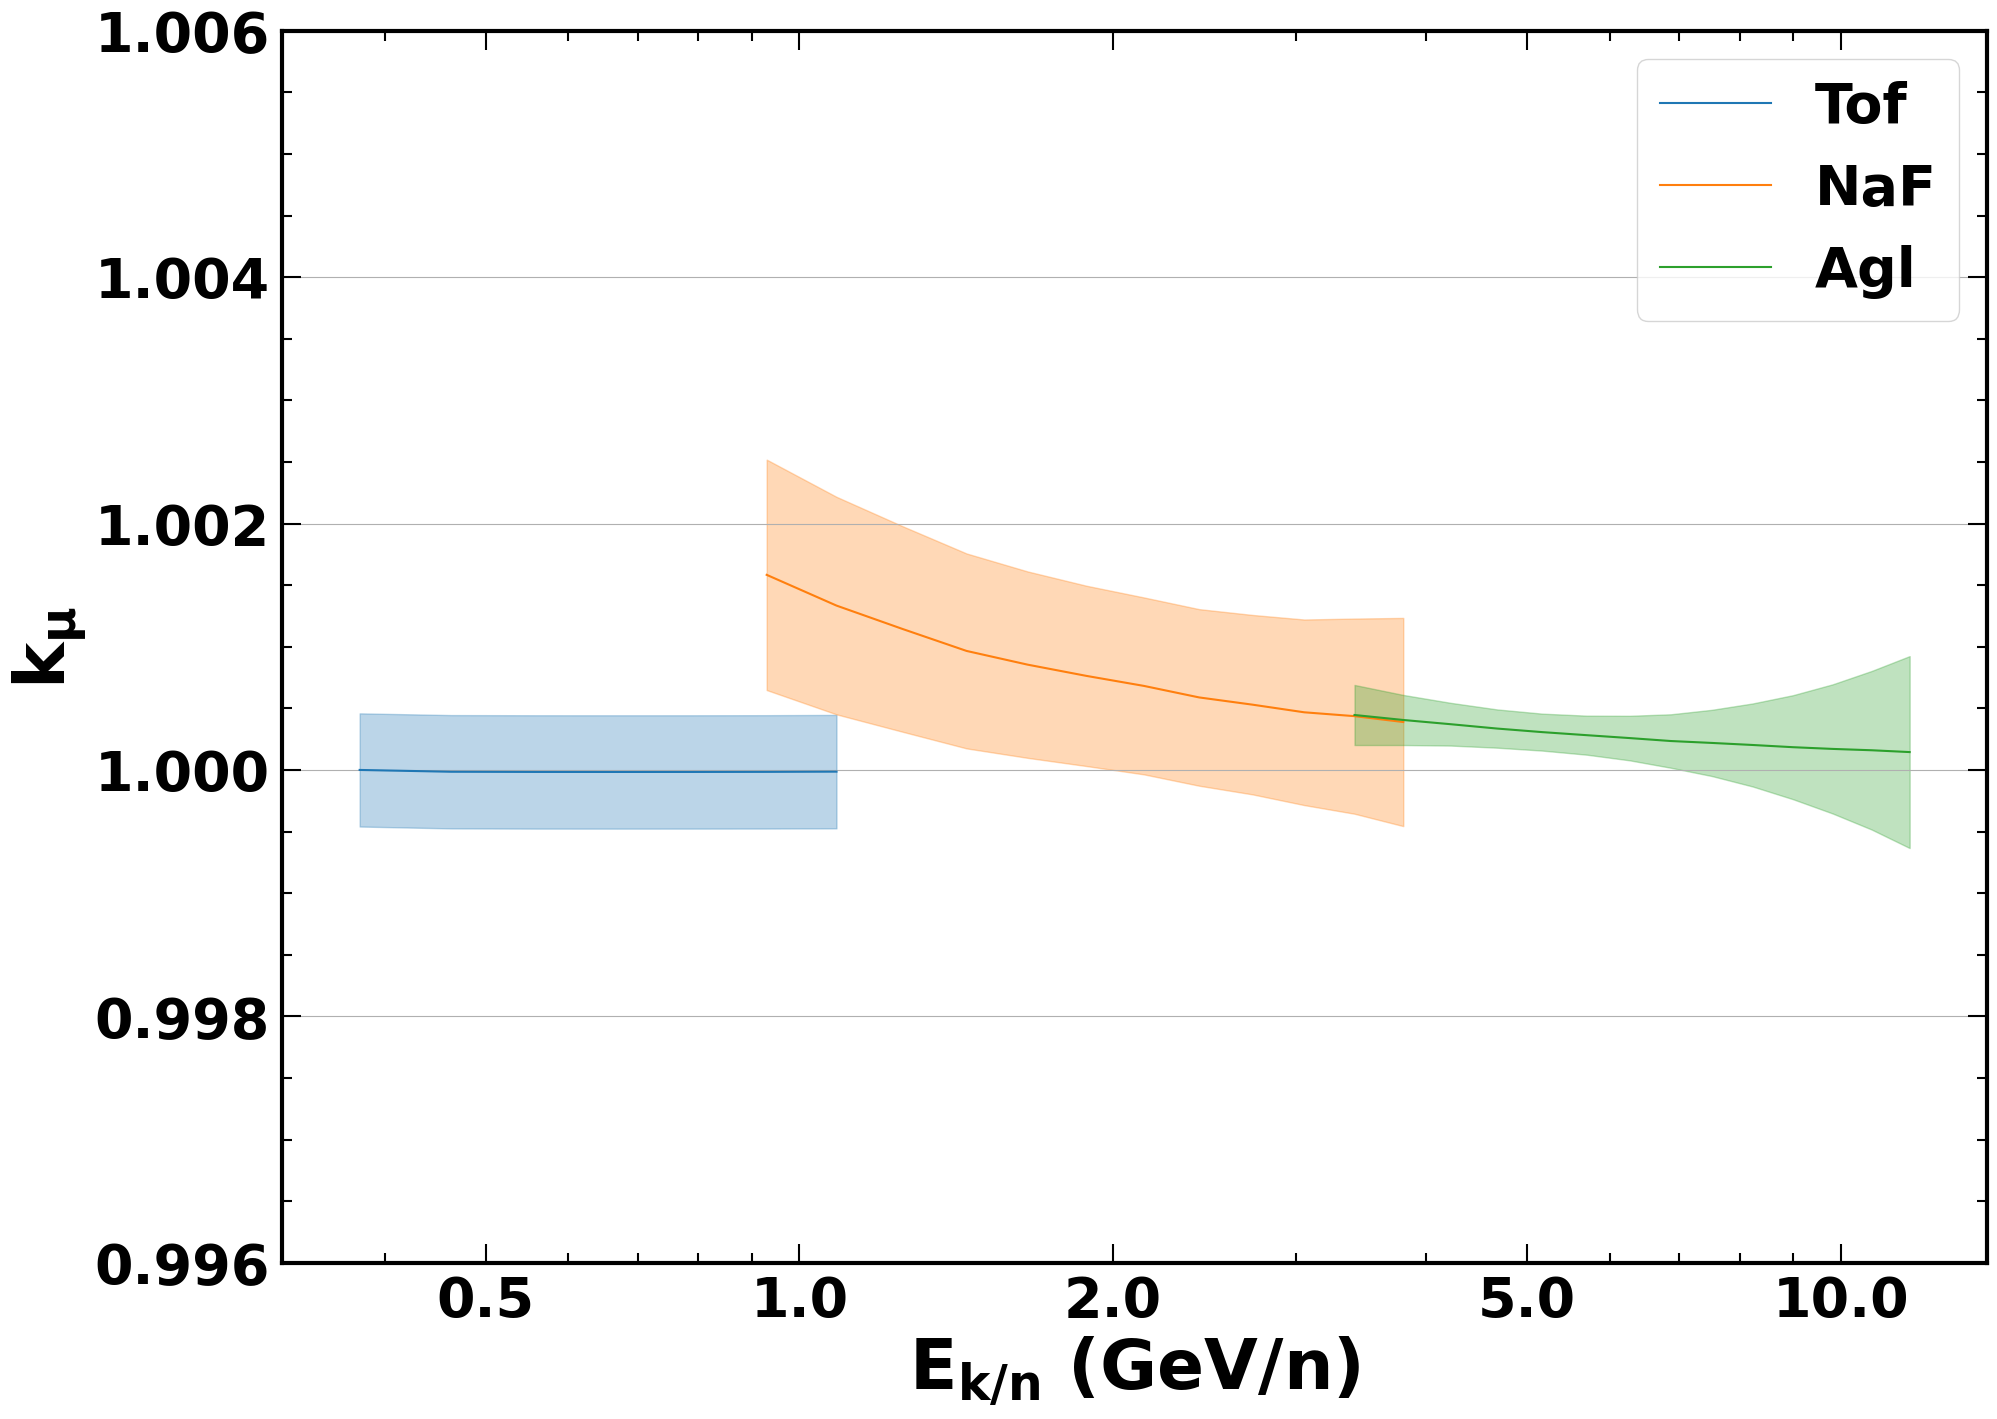

In [27]:
with open('/home/manbing/Documents/Data/data_LiP8/polypars_mufactor.pickle', 'rb') as file:                                                                                          
    mufactorfile = pickle.load(file)                                                                                                                                                                                                    
    print('mufactorfile:', mufactorfile['Tof']   )                
with open('/home/manbing/Documents/Data/data_LiP8/polypars_sigfactor.pickle', 'rb') as file:  
    sigfactorfile = pickle.load(file)     
    print(sigfactorfile)
    
with open('/home/manbing/Documents/Data/data_BeP8/FitParsRange/spline_ku_uncertainty.pickle', 'rb') as file:                                                                     
    spline_ku_err = pickle.load(file)                                                                              
    Agl_spline_ku_err = spline_ku_err['Agl'] 
    
with open('/home/manbing/Documents/Data/data_BeP8/FitParsRange/spline_ksig_uncertainty.pickle', 'rb') as file:                                                      
    spline_ksig_err = pickle.load(file)                                                                                                                              
    Agl_spline_ksig_err = spline_ksig_err['Agl'] 
    
    
graph_kmu = {}
graph_ksigma = {}
mu_kuerr = {}
sigma_ksigmaerr = {}

detectors = ['Tof', 'NaF', 'Agl']



graph_massratio= {}
graph_massratio_be10 = {}
from tools.constants import ISOTOPES_MASS
massratio = {}
subgraph_ku = {}
ANALYSISRANGE = {'Tof': [0.4, 1.1], 'NaF':[0.9, 3.8], 'Agl':[3.6, 12.0]}

for dec in detectors:
    massratio[dec] = ((1/ISOTOPES_MASS['Li7'] - deltamass[dec]['Li7'])/(1/ISOTOPES_MASS['Li6'] - deltamass[dec]['Li6']))/(ISOTOPES_MASS['Li6']/ISOTOPES_MASS['Li7'])
    graph_massratio[dec] = MGraph(graph_deltamass[dec]['Li7'].xvalues, massratio[dec], np.zeros_like(massratio[dec]))
    subgraph_ku[dec] = slice_graph_by_value(graph_massratio[dec], ANALYSISRANGE[dec])
        
fig, ax1 = plt.subplots(1, 1, figsize= (22, 16))

xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_dec = {'Tof':[1.0], 'NaF':[1.0, 0.1, 0.1], "Agl":[1.0, 0.1, 0.1]}
dict_polypars_mufactor = {dec: {} for dec in detectors}
for dec in detectors:
    mu_kuerr[dec] = spline_ku_err[dec](np.log(subgraph_ku[dec].xvalues)) *0.4
    ax1.plot(subgraph_ku[dec].xvalues, subgraph_ku[dec].yvalues, '-', color=DETECTOR_COLOR[dec], label=f'{dec}')
  
    #ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
    popt, pcov = curve_fit(poly, np.log(graph_massratio[dec].xvalues), graph_massratio[dec].yvalues, p0 = p0_dec[dec])  
    print(dec, "Li7: ", popt, pcov)
    dict_polypars_mufactor[dec]['Li7'] = popt
    ax1.fill_between(subgraph_ku[dec].xvalues, subgraph_ku[dec].yvalues-mu_kuerr[dec], subgraph_ku[dec].yvalues+mu_kuerr[dec],  color=DETECTOR_COLOR[dec], alpha=0.3)


with open('/home/manbing/Documents/Data/data_LiP8/polypars_mufactor.pickle', 'wb') as file:
    pickle.dump(dict_polypars_mufactor, file)
    

with open('/home/manbing/Documents/Data/data_LiP8/polypars_mufactor.pickle', 'rb') as file:
    loadfile = pickle.load(file)
    print(loadfile.items())
                                                                                                                                                                                                                                                         
set_plot_style(ax1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel(r"$\mathrm{E_{k/n} \ (GeV/n)}$", fontsize=50) 
#ax1.set_xscale('log')
#ax1.fill_betweenx(np.linspace(0.985, 1.018, 100), 1.0, 3.6, alpha=0.1, color="tab:blue") 
ax1.set_ylim([0.996, 1.006])
ax1.set_ylabel(r'$\mathrm{k_{\mu}}$', fontsize=50)
ax1.set_xscale('log')
ax1.legend(fontsize=40)
#ax1.legend(loc='lower right', fontsize=35)
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate0410/plots_0410'
print(plotfile)
ax1.grid(axis='y')
ax1.set_xticks([0.5, 1, 2, 5, 10])                                                                                                                                                                      
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter()) 
savefig_tofile(fig, plotfile, 'mass_meanLi6correction_alldec', 1)



In [8]:
xlimvalue = {'Tof': [0, 1], 'NaF':[1.0, 4.0], "Agl":[4.0, 12]}
ylimvalue = {'Tof': [-0.0001, 0.0001], 'NaF':[-0.001, 0.004], "Agl":[0.00, 0.001]}

fitmcgausfile = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitMCMassGaus_Untuned'
graph_mean_gausfit = {dec: {} for dec in detectors}
graph_deltamass_gausfit = {dec: {} for dec in detectors}
subgraph_deltamass_gausfit = {dec: {} for dec in detectors}
with np.load(os.path.join(fitmcgausfile, "graph_gausfit_MCMass_Be.npz")) as dfile:
    for dec in detectors:
        for iso in isotopes:
            graph_mean_gausfit[dec][iso] = MGraph.from_file(dfile, f'graph_{dec}{iso}_mean')
            graph_deltamass_gausfit[dec][iso] = MGraph(graph_mean_gausfit[dec][iso].xvalues, 1/ISOTOPES_MASS[iso]-graph_mean_gausfit[dec][iso].yvalues, graph_mean_gausfit[dec][iso].yerrs)
            subgraph_deltamass_gausfit[dec][iso] = slice_graph_by_value(graph_deltamass_gausfit[dec][iso], xlimvalue[dec])
            
            #print(graph_mean_gausfit[dec][iso])
            #print(1/ISOTOPES_MASS[iso]-graph_mean_gausfit[dec][iso].yvalues)

            

            
fitISSgausfile = '/home/manbing/Documents/lithiumanalysis/scripts/plots/BeP8/fitDataMassGaus'
graphISS_mean_gausfit = {dec: {} for dec in detectors}
graphISS_deltamass_gausfit = {dec: {} for dec in detectors}
fitDataIso = ['Be7']
with np.load(os.path.join(fitISSgausfile, "graph_gausfit_MCMass_Be.npz")) as dfile:
    for dec in detectors:
        for iso in fitDataIso:
            graphISS_mean_gausfit[dec][iso] = MGraph.from_file(dfile, f'graph_{dec}{iso}_mean')
            graphISS_deltamass_gausfit[dec][iso] = MGraph(graphISS_mean_gausfit[dec][iso].xvalues, 1/ISOTOPES_MASS[iso]-graphISS_mean_gausfit[dec][iso].yvalues, graphISS_mean_gausfit[dec][iso].yerrs)
            
isorange ={'Be7':[0.145, 0.16], 'Be9':[0.112, 0.125], 'Be10':[0.1, 0.112]}
for iso in isotopes:
    fig, ax2 = plt.subplots(1, 1, figsize= (22, 16))
    ax2.axhline(y=1/ISOTOPES_MASS[iso], color='grey', linestyle='--', label='nominal inverse mass') 
    for dec in detectors:
        
        plot_graph(fig, ax2, graph_mean_gausfit[dec][iso], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=f"{ISO_LABELS[iso]}MC {dec}")
        ax2.set_xlim([0.1, 12])
        ax2.set_ylabel('MPV (1/m)')
        ax2.set_xlabel('Ek/n (GeV/n)')
        ax2.set_ylim(isorange[iso])
        ax2.legend()
        ax2.fill_betweenx(np.linspace(-0.0005, 0.005, 100), 1.0, 4.0, alpha=0.1, color="tab:blue")
    savefig_tofile(fig, plotfile, f"graph_mean_gausfit_{iso}", show=True)    

fig, ax3 = plt.subplots(1, 1, figsize= (22, 16))
for dec in detectors:
    plot_graph(fig, ax3, graph_mean_gausfit[dec]['Be7'], color=ISOTOPES_COLOR['Be7'], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=f"{ISO_LABELS['Be7']}" if dec == 'Tof' else None )
    plot_graph(fig, ax3, graphISS_mean_gausfit[dec]['Be7'], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=f"ISS" if dec == 'Tof' else None)
    ax3.set_ylim([0.14, 0.16])
    ax3.legend()
    ax3.set_ylabel('MPV (1/m)')
    ax3.set_xlabel('Ek/n (GeV/n)')
    ax3.fill_betweenx(np.linspace(-0.0005, 0.005, 100), 1.0, 4.0, alpha=0.1, color="tab:blue")
    savefig_tofile(fig, plotfile, f"graph_mean_gausfit_Be7Vsdata", show=True) 
   

xaxistext = {'Tof': 0.1, 'NaF': 0.4, 'Agl': 0.75}
fig, ax1 = plt.subplots(1, 1, figsize= (22, 16))
subgraph_deltamass = {dec: {} for dec in detectors}
for dec in detectors:
    for iso in isotopes:
        #print(graph_deltamass[dec][iso])
        
        subgraph_deltamass[dec][iso] = slice_graph_by_value( graph_deltamass[dec][iso], xlimvalue[dec])
        
        plot_graph(fig, ax1, subgraph_deltamass[dec][iso], color=ISOTOPES_COLOR[iso], style="hist", xlog=False, ylog=False, scale=None, markersize=21, label=f"{ISO_LABELS[iso]} Truth" if dec == 'Tof' else None)
        #plot_graph(fig, ax1, subgraph_deltamass_gausfit[dec][iso], color=ISOTOPES_COLOR[iso], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=f"{ISO_LABELS[iso]}MC Reco" if dec == 'Tof' else None)
        ax1.set_ylabel(f"$\mathrm{{ \Delta (1/m) (nominal -1/m_{{dec}}) }}$", fontsize=45)
        #ax1.set_ylabel(f"$\mathrm{{\Delta m_{{gen}} }}$", fontsize=45)
        ax1.set_xlabel('Ekin/n (GeV/n)', fontsize=50)
        #ax1.set_ylim(ylimvalue[dec])
        ax1.set_ylim([-0.002, 0.004])
        #ax1.legend()
        set_plot_defaultstyle(ax1)
        ax1.set_xscale('log')
        ax1.legend(loc='lower right')
        ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")
        #ax1.text(0.05, 0.98, f"{DETECTOR_LABEL[dec]}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold") 
ax1.fill_betweenx(np.linspace(-0.002, 0.006, 100), 1.0, 4.0, alpha=0.1, color="tab:blue")
savefig_tofile(fig, plotfile, f"graph_deltamean_compare_mcTruthReco", show=True) 


KeyError: 'graph_TofLi6_mean_xvalues is not a file in the archive'

In [12]:
for ibin in range(17, 23):
    print(ibin, hist2d['Agl']['Be7'].binnings[0].bin_centers[ibin])
    hist1d =  hist2d['Agl']['Be7'].project(ibin)   
    figure, ax1 = plt.subplots(1, 1, figsize=(17, 14))
    #print(np.argmax(hist1d.values), hist1d.binnings[0].edges[np.argmax(hist1d.values)])
    #print(np.argmax(hist1d.values), hist1d.binnings[0].edges[np.argmax(hist1d.values)+1])
    plot_histogram_1d(ax1, hist1d, style="mc", color=ISOTOPES_COLOR[iso], label=f'{iso} build', scale=None, gamma=None, xlog=False, ylog=False, shade_errors=False, setscilabely=True, show_overflow=False)    

KeyError: 'Be7'

In [13]:
def get_error_massratio(massA, massB, graphA, graphB):
    # Assuming you have uncertainties for graph_fitgausmu1.yvalues and graph_fitgausmu.2yvalues
    delta_A = graphA.yerrs  # Replace with the actual uncertainty in graph_fitgausmu1.yvalues
    delta_B = graphB.yerrs  # Replace with the actual uncertainty in graph_fitgausmu.2yvalues
    A = (1/massA - graphA.yvalues)
    B = (1/massB - graphB.yvalues)
    massratio = A / B
    delta_C = massratio * ((delta_A / A)**2 + (delta_B / B)**2)**0.5
    return delta_C
    
decs = ['Tof', 'NaF', 'Agl']

massratiobe9 = {}
massratiobe10 = {}
graph_massratio_be9 = {}
graph_massratio_be10 = {}
slicevalue_trueratio ={'Tof':[0.45, 2.0], 'NaF':[0.9, 6.0], 'Agl':[3.0, 12.0]}

from tools.constants import ISOTOPES_MASS
filename = filecounts_path + 'df_ratio_mean_iter2.npz'
df_measured_ratio = np.load(f'{filename}')
graph_massratio_be9_fromfit = {}
graph_massratio_be10_fromfit = {}

massratiobe9_v2 = {}
massratiobe10_v2 = {}
massratiobe9_errv2 = {}
massratiobe10_errv2 = {}
graph_massratio_be9v2 = dict()
graph_massratio_be10v2 = {}

for dec in detectors:
    graph_massratio_be9_fromfit[dec] = MGraph.from_file(df_measured_ratio, f"graph_mass_sigma_9to7_{dec}")
    graph_massratio_be10_fromfit[dec] = MGraph.from_file(df_measured_ratio, f"graph_mass_sigma_10to7_{dec}")
    

for dec in decs:
    #massratiobe9_v2[dec] = (1/ISOTOPES_MASS['Be9'] - graph_fitgausmu[dec]['Be9'].yvalues)/(1/ISOTOPES_MASS['Be7'] - graph_fitgausmu[dec]['Be7'].yvalues)
    #massratiobe9_errv2[dec] = get_error_massratio(ISOTOPES_MASS['Be9'], ISOTOPES_MASS['Be7'], graph_fitgausmu[dec]['Be9'], graph_fitgausmu[dec]['Be7'])
    #graph_massratio_be9v2[dec] = MGraph(graph_fitgausmu[dec]['Be7'].xvalues, massratiobe9_v2[dec], massratiobe9_errv2[dec])
    #print(graph_deltamass[dec]['Be7'])
    massratiobe9[dec] = (1/ISOTOPES_MASS['Be9'] - deltamass[dec]['Be9'])/(1/ISOTOPES_MASS['Be7'] - deltamass[dec]['Be7'])
    graph_massratio_be9[dec] = MGraph(graph_deltamass[dec]['Be7'].xvalues, massratiobe9[dec], np.zeros_like(massratiobe9[dec]))
    massratiobe10[dec] = (1/ISOTOPES_MASS['Be10'] - deltamass[dec]['Be10'])/(1/ISOTOPES_MASS['Be7'] - deltamass[dec]['Be7'])
    graph_massratio_be10[dec] = MGraph(graph_deltamass[dec]['Be7'].xvalues, massratiobe10[dec], np.zeros_like(massratiobe10[dec]))
    graph_massratio_be9[dec] = slice_graph_by_value(graph_massratio_be9[dec], slicevalue_trueratio[dec])
    graph_massratio_be10[dec] = slice_graph_by_value(graph_massratio_be10[dec], slicevalue_trueratio[dec])
        
        
fig, ax1 = plt.subplots(1, 1, figsize= (22, 16))
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_dec = {'Tof':[0.7], 'NaF':[0.7, 0.1, 0.1], "Agl":[0.7, 0.1, 0.1]}

#plot_graph(fig, ax1, graph_massratio_be9Naf_gausfitmu, color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=r"$\mathrm{\mu_{be9}/\mu_{be7}, fitgaus}$")
#plot_graph(fig, ax1, graph_fitgausmu, color='red', style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=r"$\mathrm{\mu_{be9}/\mu_{be7}, fit, P8}$")
for dec in decs: 
    if dec == 'Tof':
        #plot_graph(fig, ax1, graph_massratio_be9v2[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be9}, true}$")
        ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '-', color=DETECTOR_COLOR[dec], label=f'$\mathrm{{ \mu^{{ {dec} }}_{{9}}/\mu^{{ {dec} }}_{{7}} }}$')
        plot_graph(fig, ax1, graph_massratio_be9_fromfit[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=r"$\mathrm{\mu_{be9}/\mu_{be7}, fit, P8}$")
    else:
        ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '-', color=DETECTOR_COLOR[dec], label=f'$\mathrm{{ \mu^{{ {dec} }}_{{9}}/\mu^{{ {dec} }}_{{7}} }}$')
        #plot_graph(fig, ax1, graph_massratio_be9v2[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        plot_graph(fig, ax1, graph_massratio_be9_fromfit[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21)        
        popt, pcov = curve_fit(poly, np.log(graph_massratio_be9[dec].xvalues), graph_massratio_be9[dec].yvalues, p0 = p0_dec[dec])  
        #print(dec, "be9: ", popt, pcov)
        #ax1.plot(graph_mass_sigma_9to7[dec].xvalues, poly(np.log(graph_mass_sigma_9to7[dec].xvalues), *popt), "-", color='black')                                                                          
                                                                                                                                                                                                                                                           
set_plot_defaultstyle(ax1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)") 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.75, 0.8, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'], color='grey', linestyle='--', label='nominal mass ratio') 

#ax1.axhline(y=1.0, color='orange', linestyle='--')  
#ax1.axhline(y=0.77869417, color='black', linestyle='--')  

ax1.set_ylim([0.765, 0.79])
ax1.set_xlabel('Ekin/N (GeV/n)')
ax1.set_ylabel(r'$\mathrm{\mu_{1/m} ~ ratio}$')
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=30)

#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_2009/plots_2009'
savefig_tofile(fig, plotfile, 'mass_isoratio_be9P8_compareTrue', 1)



FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/lithiumanalysis/scripts/df_ratio_mean_iter2.npz'

In [26]:
def GetFitValueLim(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fit_lower, fit_upper = get_fitpdferrorband(np.log(graph1.xvalues), polypars, upoly)
    return fit_lower, fit_upper

def get_uncertainty_spline(graphlow, graphup):
    xvector = graphlow.xvalues
    yvector = ((graphup.yvalues - graphlow.yvalues)/2)/((graphup.yvalues + graphlow.yvalues)/2)
    spline_fit = UnivariateSpline(np.log(xvector), yvector, k=3, s=5)
    return spline_fit

def GetFitValue(graph1, p0, withsigma=True):
    if withsigma:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, sigma=graph1.yerrs, p0 = p0)  
    else:
        popt, pcov = curve_fit(poly, np.log(graph1.xvalues), graph1.yvalues, p0 = p0)  
        
    polypars = uncertainties.correlated_values(popt, np.array(pcov)) 
    fity, fityerr = get_fitpdf_witherr(np.log(graph1.xvalues), polypars, upoly)
    graph_fit = MGraph(graph1.xvalues, fity, fityerr)
    return graph_fit

def getgraph_errband(graph1, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_fitlow = MGraph(graph1.xvalues,fit_lower1, np.zeros_like(fit_lower1))
    graph_fitup = MGraph(graph1.xvalues,fit_upper1, np.zeros_like(fit_upper1))
    return graph_fitlow, graph_fitup

def getgrapherr(graph1,  parname, par0, withsig=False):
    fit_lower1, fit_upper1 = GetFitValueLim(graph1, par0, withsigma=withsig)
    err1= (fit_upper1 - fit_lower1)/2 
    graph_err = MGraph(graph1.xvalues, err1, np.zeros_like(fit_upper1))
    return graph_err

def getgrapherr_fromLowUp(graphlow,  graphup):
    err= (graphup.yvalues - graphlow.yvalues)/2 
    graph_err = MGraph(graphlow.xvalues, err, np.zeros_like(err))
    return graph_err


xvalues			yvalues			yerrs
0.37825			0.7784273409511936			0.0009151445038464175
0.4631			0.7794418983609723			0.000845156801820125
0.5589999999999999			0.7782283959942254			0.0007820618094175897
0.66835			0.7804385770950909			0.0007424028623220054
0.79125			0.7786457023053365			0.0007372595153134741
0.9302999999999999			0.7792197023455838			0.0007231175265864155
1.08555			0.7784197558962499			0.0007557157172545389


xvalues			yvalues			yerrs
1.2570999999999999			0.7816997712110368			0.0015109376034912387
1.44745			0.7805852029386628			0.0014408594726569419
1.6566			0.7799532708011212			0.0014667673910760135
1.8872			0.7816700590401556			0.0014736845543398573
2.1419			0.7826761748116385			0.0014729862324586705
2.42075			0.7802979485116519			0.0014473511682238608
2.7237			0.7801912920967523			0.0014308096295360794
3.0534			0.7803793450259211			0.0015142935987091188
3.4126000000000003			0.7798722748699263			0.001554634606455396
3.8012500000000005			0.7801468705852664			0.00151325510681049

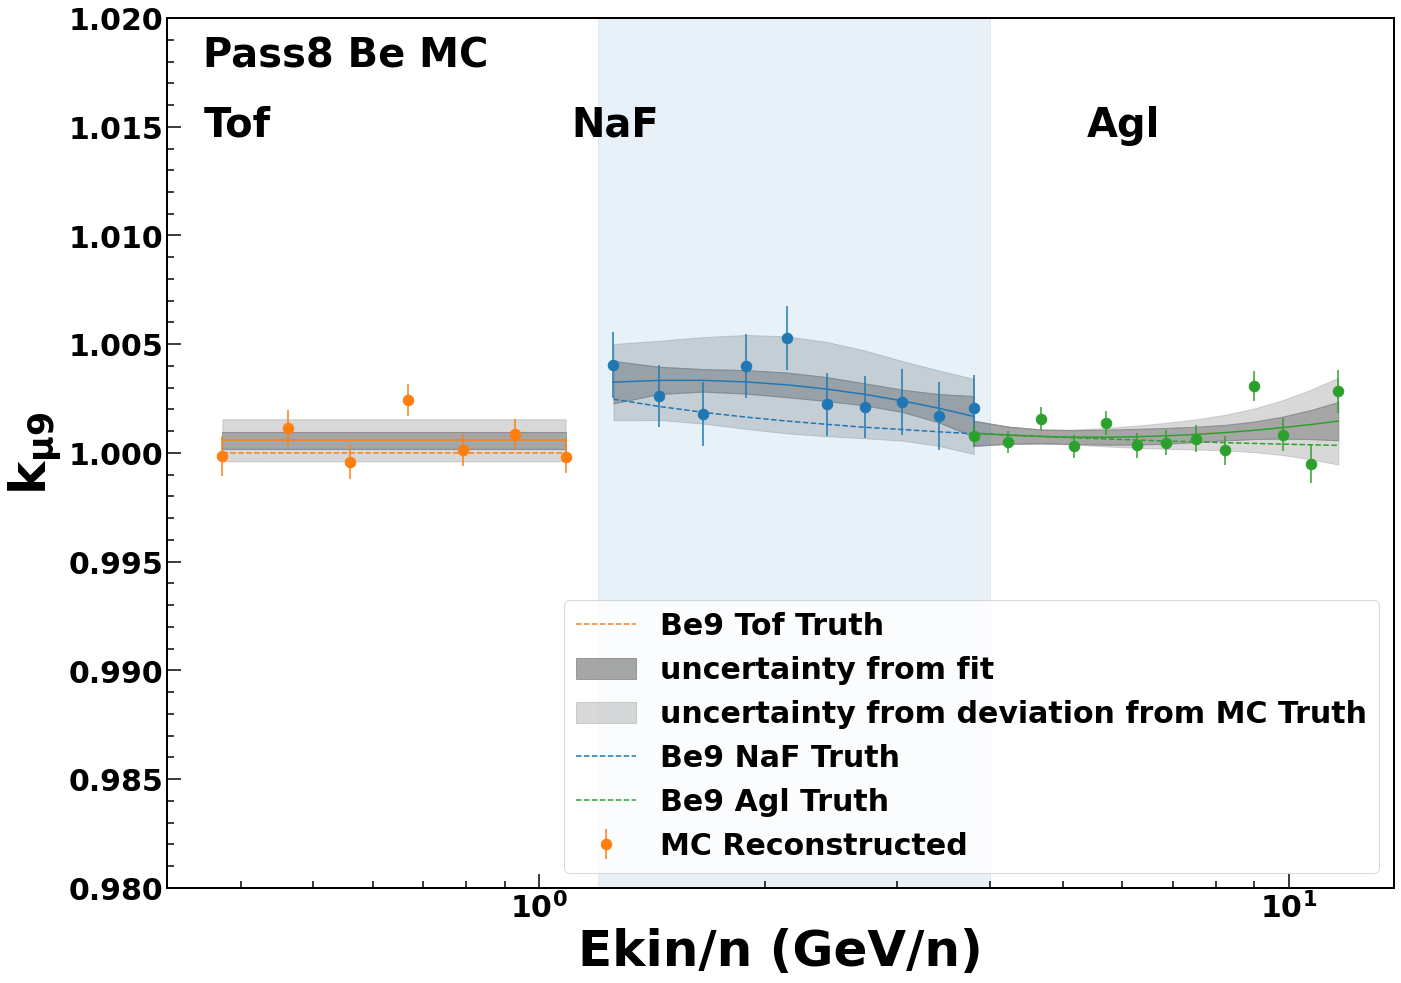

In [27]:
massratiobe9 = {}
massratiobe10 = {}
graph_massratio_be9 = {}
graph_massratio_be10 = {}
graph_massratio_be9_gausfit = {}
graph_massratio_be10_gausfit = {}

dfname = {dec: f'/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitmassgaus/df_mean_ratio_{dec}.npz' for dec in detectors}
#filename = filecounts_path + 'df_ratio_mean_iter2.npz'
dfgausfit = {dec:  np.load(f'{dfname[dec]}') for dec in detectors}
#dffit = np.load(f'{filename}')

slicevalue_trueratio = {'Tof':[0.3, 1.1], 'NaF':[1.2, 4.0], 'Agl':[4.0, 12.0]}
slicevalue_recratio = {'Tof':[0.3, 1.1], 'NaF':[1.2, 4.0], 'Agl':[4.0, 12.0]}

from tools.constants import ISOTOPES_MASS
flilename = filecounts_path + 'df_ratio_mean_iter2.npz'
df_measured_ratio = np.load(f'{filename}')
graph_massratio_be9_fromfit = {}
graph_massratio_be10_fromfit = {}

graph_ku_be9_gausfitP8 = {}
graph_ku_be10_gausfitP8 = {}
for dec in detectors:
    
    graph_ku_be9_gausfitP8[dec] = slice_graph_by_value((graph_mean_gausfit[dec]['Be9']/ graph_mean_gausfit[dec]['Be7']), slicevalue_trueratio[dec])
    graph_ku_be10_gausfitP8[dec] = slice_graph_by_value((graph_mean_gausfit[dec]['Be10']/ graph_mean_gausfit[dec]['Be7']) , slicevalue_trueratio[dec])
    print(graph_ku_be9_gausfitP8[dec])
    graph_ku_be9_gausfitP8[dec].yvalues = graph_ku_be9_gausfitP8[dec].yvalues /(ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_ku_be10_gausfitP8[dec].yvalues = graph_ku_be10_gausfitP8[dec].yvalues /(ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])
    graph_massratio_be9_fromfit[dec] = MGraph.from_file(df_measured_ratio, f"graph_mass_sigma_9to7_{dec}")
    graph_massratio_be10_fromfit[dec] = MGraph.from_file(df_measured_ratio, f"graph_mass_sigma_10to7_{dec}")
    graph_massratio_be9_gausfit[dec] = MGraph.from_file(dfgausfit[dec], f'graph_ratio_mean_be9be7_{dec}')
    graph_massratio_be10_gausfit[dec] = MGraph.from_file(dfgausfit[dec], f'graph_ratio_mean_be10be7_{dec}')
for dec in detectors:
    massratiobe9[dec] = (1/ISOTOPES_MASS['Be9'] - deltamass[dec]['Be9'])/(1/ISOTOPES_MASS['Be7'] - deltamass[dec]['Be7'])
    graph_massratio_be9[dec] = MGraph(graph_deltamass[dec]['Be7'].xvalues, massratiobe9[dec], np.zeros_like(massratiobe9[dec]))
    massratiobe10[dec] = (1/ISOTOPES_MASS['Be10'] - deltamass[dec]['Be10'])/(1/ISOTOPES_MASS['Be7'] - deltamass[dec]['Be7'])
    graph_massratio_be10[dec] = MGraph(graph_deltamass[dec]['Be7'].xvalues, massratiobe10[dec], np.zeros_like(massratiobe10[dec]))
    graph_massratio_be9[dec] = slice_graph_by_value(graph_massratio_be9[dec], slicevalue_trueratio[dec])
    graph_massratio_be10[dec] = slice_graph_by_value(graph_massratio_be10[dec], slicevalue_trueratio[dec])
    graph_massratio_be9[dec].yvalues = graph_massratio_be9[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be9_gausfit[dec].yvalues = graph_massratio_be9_gausfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be9_fromfit[dec].yvalues = graph_massratio_be9_fromfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be10[dec].yvalues = graph_massratio_be10[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10']) 
    graph_massratio_be10_gausfit[dec].yvalues = graph_massratio_be10_gausfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])
    graph_massratio_be10_fromfit[dec].yvalues = graph_massratio_be10_fromfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])
        
fig, ax1 = plt.subplots(1, 1, figsize= (22, 16))
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_dec = {'Tof':[1.0], 'NaF':[1.0, 0.1, 0.1], "Agl":[1.0, 0.1, 0.1]}
dict_polypars_mufactor = {dec: {} for dec in detectors}
graphfitku_low = {}
graphfitku_up = {}
graphfitku_maxlow = {}
graphfitku_maxup = {}

graphfitku = {}
graph_diff_TrueReco = {}
spline_ku_uncertainty = {}
for dec in detectors:
    graph_massratio_be9_fromfit[dec] = slice_graph_by_value(graph_massratio_be9_fromfit[dec], slicevalue_recratio[dec])
    graph_massratio_be9_gausfit[dec] = slice_graph_by_value(graph_massratio_be9_gausfit[dec], slicevalue_recratio[dec])
    
    ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '--', color=DETECTOR_COLOR[dec], label=f'Be9 {dec} Truth')
    if dec == 'Tof':
        
        plot_graph(fig, ax1, graph_ku_be9_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=r"MC Reconstructed")
        #plot_graph(fig, ax1, graph_ku_be10_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", marker='+', xlog=False, ylog=False, scale=None, markersize=21)   
        ax1.text(xaxistext[dec], 0.98, f"Pass8 Be MC", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")   
        ax1.text(xaxistext[dec], 0.9, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")
    else:
        plot_graph(fig, ax1, graph_ku_be9_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21)   
        #plot_graph(fig, ax1, graph_ku_be10_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", marker='+', xlog=False, ylog=False, scale=None, markersize=21)   
        ax1.text(xaxistext[dec], 0.9, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")
        
    graphfitku[dec] = GetFitValue(graph_ku_be9_gausfitP8[dec], p0_dec[dec], withsigma=True)
    graphfitku_low[dec], graphfitku_up[dec] = getgraph_errband(graph_ku_be9_gausfitP8[dec], p0_dec[dec], withsig=True)
    plot_graph(fig, ax1, graphfitku[dec], color=DETECTOR_COLOR[dec], style="hist", xlog=False, ylog=False, scale=None, markersize=21)
    ax1.fill_between(graphfitku_low[dec].xvalues, graphfitku_low[dec].yvalues, graphfitku_up[dec].yvalues,  color='grey', alpha=0.7, label=r'uncertainty from fit' if dec == 'Tof' else None)
    graph_diff_TrueReco[dec] = MGraph(graph_massratio_be9[dec].xvalues, graphfitku[dec].yvalues - graph_massratio_be9[dec].yvalues, np.zeros_like(graph_massratio_be9[dec].xvalues))
    
    ax1.fill_between(graphfitku_low[dec].xvalues, graphfitku_low[dec].yvalues-graph_diff_TrueReco[dec].yvalues, graphfitku_low[dec].yvalues,  color='grey', alpha=0.3)
    
    ax1.fill_between(graphfitku_low[dec].xvalues, graphfitku_up[dec].yvalues, graphfitku_up[dec].yvalues + graph_diff_TrueReco[dec].yvalues,  color='grey', alpha=0.3, label=r'uncertainty from deviation from MC Truth' if dec == 'Tof' else None)
    graphfitku_maxlow[dec] = MGraph(graphfitku_low[dec].xvalues, graphfitku_low[dec].yvalues-graph_diff_TrueReco[dec].yvalues, np.zeros_like(graphfitku_low[dec].xvalues))
    graphfitku_maxup[dec] = MGraph(graphfitku_up[dec].xvalues, graphfitku_up[dec].yvalues+ graph_diff_TrueReco[dec].yvalues, np.zeros_like(graphfitku_up[dec].xvalues))
    spline_ku_uncertainty[dec] = get_uncertainty_spline(graphfitku_maxlow[dec], graphfitku_maxup[dec] )
    

with open('/home/manbing/Documents/Data/data_BeP8/spline_ku_uncertainty.pickle', 'wb') as file:
    pickle.dump(spline_ku_uncertainty, file)
with open('/home/manbing/Documents/Data/data_BeP8/spline_ku_uncertainty.pickle', 'rb') as file:
    loadfile = pickle.load(file)
    print(loadfile.items())    

set_plot_defaultstyle(ax1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)", fontsize=50) 
ax1.set_ylabel(r'$\mathrm{k_{\mu9}}$', fontsize=50)
ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.98, 1.02, 100), 1.2, 4.0, alpha=0.1, color="tab:blue") 
ax1.set_ylim([0.98, 1.02])
ax1.legend(loc='lower right')
#ax1.legend(loc='lower right', fontsize=35)

savefig_tofile(fig, plotfile, 'mass_meanbe9correction', 1)


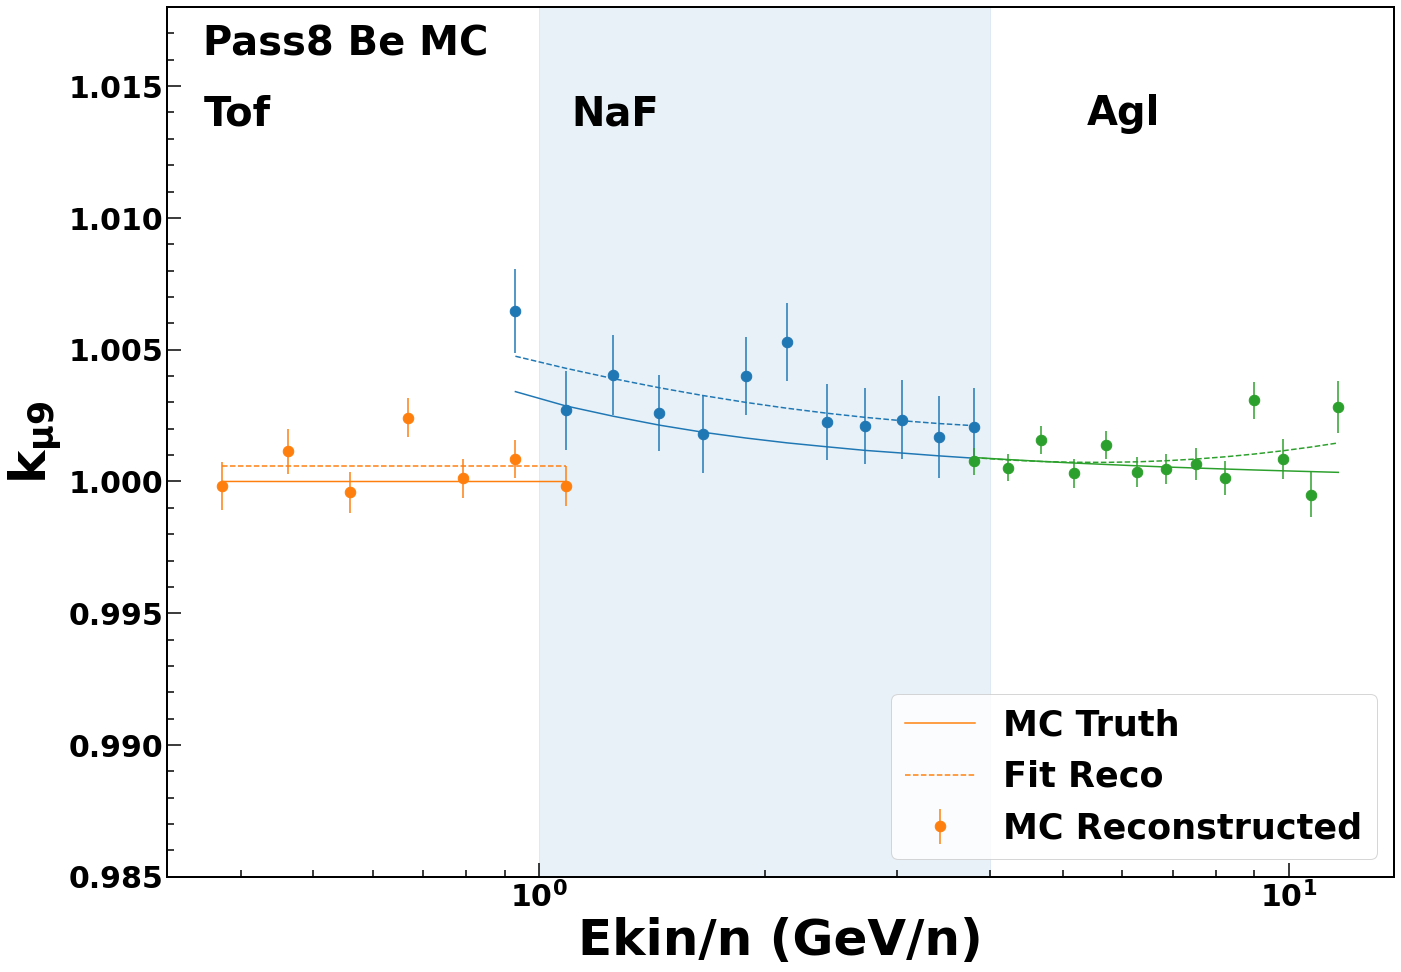

In [28]:
massratiobe9 = {}
massratiobe10 = {}
graph_massratio_be9 = {}
graph_massratio_be10 = {}
graph_massratio_be9_gausfit = {}
graph_massratio_be10_gausfit = {}

dfname = {dec: f'/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitmassgaus/df_mean_ratio_{dec}.npz' for dec in detectors}
#filename = filecounts_path + 'df_ratio_mean_iter2.npz'
dfgausfit = {dec:  np.load(f'{dfname[dec]}') for dec in detectors}
#dffit = np.load(f'{filename}')

slicevalue_trueratio ={'Tof':[0.3, 1.1], 'NaF':[1.0, 4.0], 'Agl':[4.0, 12.0]}
slicevalue_recratio ={'Tof':[0.3, 1.1], 'NaF':[1.0, 4.0], 'Agl':[4.0, 12.0]}

from tools.constants import ISOTOPES_MASS
flilename = filecounts_path + 'df_ratio_mean_iter2.npz'
df_measured_ratio = np.load(f'{filename}')
graph_massratio_be9_fromfit = {}
graph_massratio_be10_fromfit = {}

graph_ku_be9_gausfitP8 = {}
graph_ku_be10_gausfitP8 = {}
for dec in detectors:
    graph_ku_be9_gausfitP8[dec] = slice_graph_by_value((graph_mean_gausfit[dec]['Be9']/ graph_mean_gausfit[dec]['Be7']), slicevalue_trueratio[dec])
    graph_ku_be10_gausfitP8[dec] = slice_graph_by_value((graph_mean_gausfit[dec]['Be10']/ graph_mean_gausfit[dec]['Be7']) , slicevalue_trueratio[dec])
    
    graph_ku_be9_gausfitP8[dec].yvalues = graph_ku_be9_gausfitP8[dec].yvalues /(ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_ku_be10_gausfitP8[dec].yvalues = graph_ku_be10_gausfitP8[dec].yvalues /(ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])
    graph_massratio_be9_fromfit[dec] = MGraph.from_file(df_measured_ratio, f"graph_mass_sigma_9to7_{dec}")
    graph_massratio_be10_fromfit[dec] = MGraph.from_file(df_measured_ratio, f"graph_mass_sigma_10to7_{dec}")
    graph_massratio_be9_gausfit[dec] = MGraph.from_file(dfgausfit[dec], f'graph_ratio_mean_be9be7_{dec}')
    graph_massratio_be10_gausfit[dec] = MGraph.from_file(dfgausfit[dec], f'graph_ratio_mean_be10be7_{dec}')
for dec in detectors:
    massratiobe9[dec] = (1/ISOTOPES_MASS['Be9'] - deltamass[dec]['Be9'])/(1/ISOTOPES_MASS['Be7'] - deltamass[dec]['Be7'])
    graph_massratio_be9[dec] = MGraph(graph_deltamass[dec]['Be7'].xvalues, massratiobe9[dec], np.zeros_like(massratiobe9[dec]))
    massratiobe10[dec] = (1/ISOTOPES_MASS['Be10'] - deltamass[dec]['Be10'])/(1/ISOTOPES_MASS['Be7'] - deltamass[dec]['Be7'])
    graph_massratio_be10[dec] = MGraph(graph_deltamass[dec]['Be7'].xvalues, massratiobe10[dec], np.zeros_like(massratiobe10[dec]))
    graph_massratio_be9[dec] = slice_graph_by_value(graph_massratio_be9[dec], slicevalue_trueratio[dec])
    graph_massratio_be10[dec] = slice_graph_by_value(graph_massratio_be10[dec], slicevalue_trueratio[dec])
    graph_massratio_be9[dec].yvalues = graph_massratio_be9[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be9_gausfit[dec].yvalues = graph_massratio_be9_gausfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be9_fromfit[dec].yvalues = graph_massratio_be9_fromfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be10[dec].yvalues = graph_massratio_be10[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10']) 
    graph_massratio_be10_gausfit[dec].yvalues = graph_massratio_be10_gausfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])
    graph_massratio_be10_fromfit[dec].yvalues = graph_massratio_be10_fromfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])
        
fig, ax1 = plt.subplots(1, 1, figsize= (22, 16))
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_dec = {'Tof':[1.0], 'NaF':[1.0, 0.1, 0.1], "Agl":[1.0, 0.1, 0.1]}
dict_polypars_mufactor = {dec: {} for dec in detectors}
graphfitku_low = {}
graphfitku_up = {}
graphfitku = {}
for dec in detectors:
    graph_massratio_be9_fromfit[dec] = slice_graph_by_value(graph_massratio_be9_fromfit[dec], slicevalue_recratio[dec])
    graph_massratio_be9_gausfit[dec] = slice_graph_by_value(graph_massratio_be9_gausfit[dec], slicevalue_recratio[dec])
    
    ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '-', color=DETECTOR_COLOR[dec], label=f'MC Truth' if dec == 'Tof' else None)
    if dec == 'Tof':
        plot_graph(fig, ax1, graph_ku_be9_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=r"MC Reconstructed")
        #plot_graph(fig, ax1, graph_ku_be10_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", marker='+', xlog=False, ylog=False, scale=None, markersize=21)   
        ax1.text(xaxistext[dec], 0.98, f"Pass8 Be MC", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold") 
        ax1.text(xaxistext[dec], 0.9, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")
    else:
        plot_graph(fig, ax1, graph_ku_be9_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21)   
        #plot_graph(fig, ax1, graph_ku_be10_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", marker='+', xlog=False, ylog=False, scale=None, markersize=21)   
        ax1.text(xaxistext[dec], 0.9, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")
        
    graphfitku[dec] = GetFitValue(graph_ku_be9_gausfitP8[dec], p0_dec[dec], withsigma=True)
    graphfitku_low[dec], graphfitku_up[dec] = getgraph_errband(graph_ku_be9_gausfitP8[dec], p0_dec[dec], withsig=True)
    if dec == 'Tof':
        plot_graph(fig, ax1, graphfitku[dec], color=DETECTOR_COLOR[dec], style="hist", xlog=False, ylog=False, scale=None, markersize=30, linestyle='--', label='Fit Reco')
    else:
        plot_graph(fig, ax1, graphfitku[dec], color=DETECTOR_COLOR[dec], style="hist", xlog=False, ylog=False, scale=None, markersize=30, linestyle='--')
    #ax1.fill_between(graphfitku_low[dec].xvalues, graphfitku_low[dec].yvalues, graphfitku_up[dec].yvalues,  color='grey', alpha=0.3, label=r'uncertainty')
    
set_plot_defaultstyle(ax1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)", fontsize=50) 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.985, 1.018, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 

ax1.set_ylim([0.985, 1.018])
ax1.set_ylabel(r'$\mathrm{k_{\mu9}}$', fontsize=50)
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=35)
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate0410/plots_0410'
#plotfile = '/home/manbing/Documents/lithiumanalysis/thesis/images/analysis/scaleT'
savefig_tofile(fig, plotfile, 'mass_meanbe9correction_Fit', 1)

#mu_fitresult = np.array([1.0016966832122498, -0.0007740261544826998, 9.301036980402233e-05])
#ax1.plot(graph_massratio_be9['Agl'].xvalues, poly(np.log(graph_massratio_be9['Agl'].xvalues), *mu_fitresult), '--', color='black')


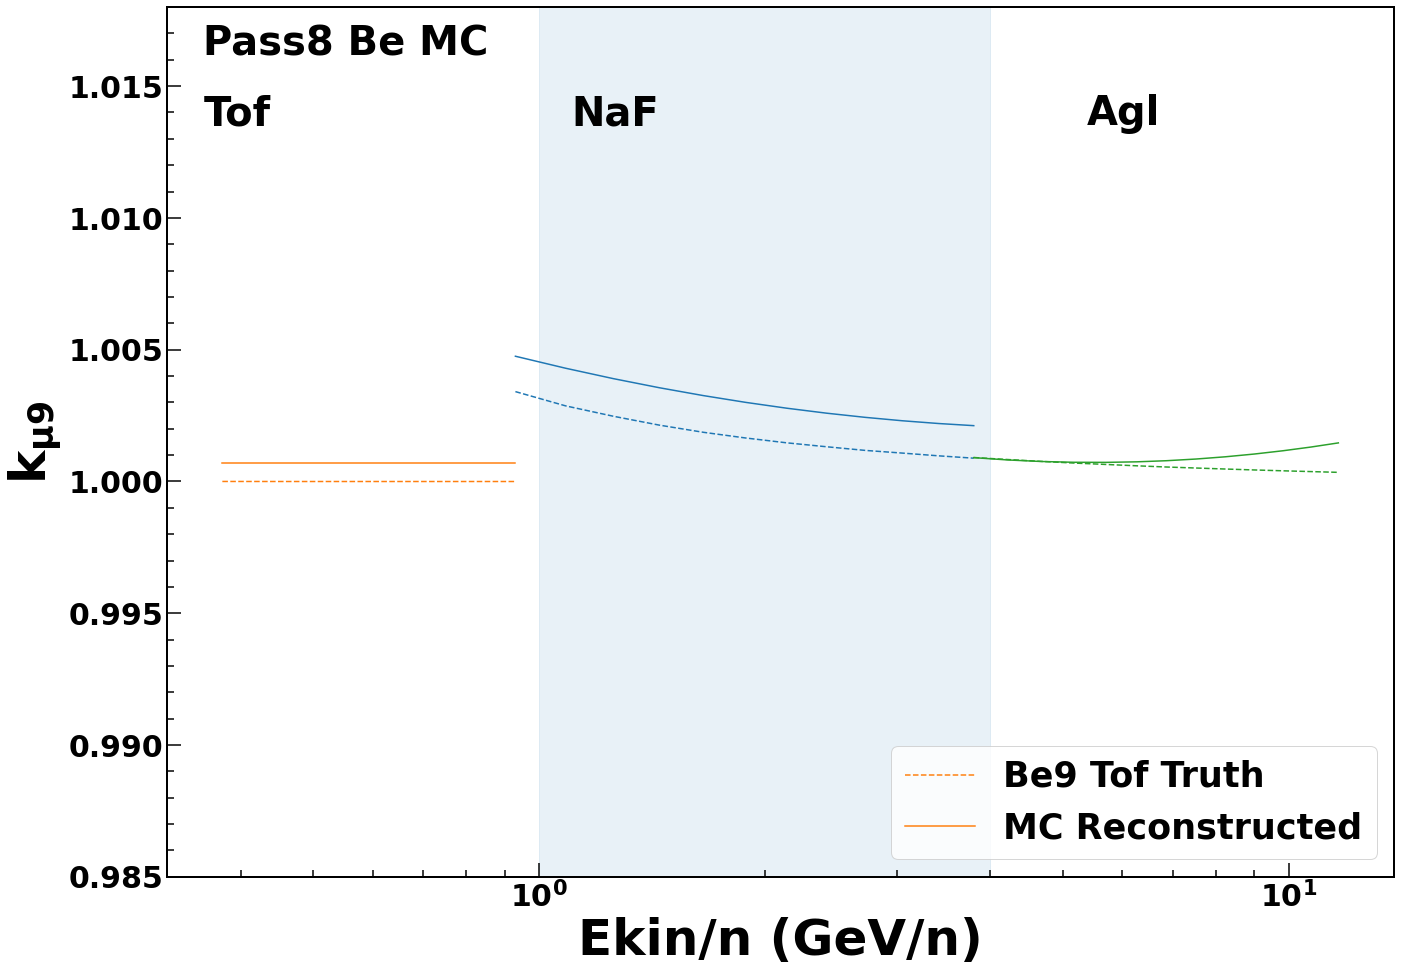

In [62]:
massratiobe9 = {}
massratiobe10 = {}
graph_massratio_be9 = {}
graph_massratio_be10 = {}
graph_massratio_be9_gausfit = {}
graph_massratio_be10_gausfit = {}

dfname = {dec: f'/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitmassgaus/df_mean_ratio_{dec}.npz' for dec in detectors}
#filename = filecounts_path + 'df_ratio_mean_iter2.npz'
dfgausfit = {dec:  np.load(f'{dfname[dec]}') for dec in detectors}
#dffit = np.load(f'{filename}')

slicevalue_trueratio ={'Tof':[0.3, 0.9], 'NaF':[1.0, 4.0], 'Agl':[4.0, 12.0]}
slicevalue_recratio ={'Tof':[0.3, 0.9], 'NaF':[1.0, 4.0], 'Agl':[4.0, 12.0]}

from tools.constants import ISOTOPES_MASS
flilename = filecounts_path + 'df_ratio_mean_iter2.npz'
df_measured_ratio = np.load(f'{filename}')
graph_massratio_be9_fromfit = {}
graph_massratio_be10_fromfit = {}

graph_ku_be9_gausfitP8 = {}
graph_ku_be10_gausfitP8 = {}
for dec in detectors:
    graph_ku_be9_gausfitP8[dec] = slice_graph_by_value((graph_mean_gausfit[dec]['Be9']/ graph_mean_gausfit[dec]['Be7']), slicevalue_trueratio[dec])
    graph_ku_be10_gausfitP8[dec] = slice_graph_by_value((graph_mean_gausfit[dec]['Be10']/ graph_mean_gausfit[dec]['Be7']) , slicevalue_trueratio[dec])
    
    graph_ku_be9_gausfitP8[dec].yvalues = graph_ku_be9_gausfitP8[dec].yvalues /(ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_ku_be10_gausfitP8[dec].yvalues = graph_ku_be10_gausfitP8[dec].yvalues /(ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])
    graph_massratio_be9_fromfit[dec] = MGraph.from_file(df_measured_ratio, f"graph_mass_sigma_9to7_{dec}")
    graph_massratio_be10_fromfit[dec] = MGraph.from_file(df_measured_ratio, f"graph_mass_sigma_10to7_{dec}")
    graph_massratio_be9_gausfit[dec] = MGraph.from_file(dfgausfit[dec], f'graph_ratio_mean_be9be7_{dec}')
    graph_massratio_be10_gausfit[dec] = MGraph.from_file(dfgausfit[dec], f'graph_ratio_mean_be10be7_{dec}')
for dec in detectors:
    massratiobe9[dec] = (1/ISOTOPES_MASS['Be9'] - deltamass[dec]['Be9'])/(1/ISOTOPES_MASS['Be7'] - deltamass[dec]['Be7'])
    graph_massratio_be9[dec] = MGraph(graph_deltamass[dec]['Be7'].xvalues, massratiobe9[dec], np.zeros_like(massratiobe9[dec]))
    massratiobe10[dec] = (1/ISOTOPES_MASS['Be10'] - deltamass[dec]['Be10'])/(1/ISOTOPES_MASS['Be7'] - deltamass[dec]['Be7'])
    graph_massratio_be10[dec] = MGraph(graph_deltamass[dec]['Be7'].xvalues, massratiobe10[dec], np.zeros_like(massratiobe10[dec]))
    graph_massratio_be9[dec] = slice_graph_by_value(graph_massratio_be9[dec], slicevalue_trueratio[dec])
    graph_massratio_be10[dec] = slice_graph_by_value(graph_massratio_be10[dec], slicevalue_trueratio[dec])
    graph_massratio_be9[dec].yvalues = graph_massratio_be9[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be9_gausfit[dec].yvalues = graph_massratio_be9_gausfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be9_fromfit[dec].yvalues = graph_massratio_be9_fromfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be10[dec].yvalues = graph_massratio_be10[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10']) 
    graph_massratio_be10_gausfit[dec].yvalues = graph_massratio_be10_gausfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])
    graph_massratio_be10_fromfit[dec].yvalues = graph_massratio_be10_fromfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])
        
fig, ax1 = plt.subplots(1, 1, figsize= (22, 16))
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_dec = {'Tof':[1.0], 'NaF':[1.0, 0.1, 0.1], "Agl":[1.0, 0.1, 0.1]}
dict_polypars_mufactor = {dec: {} for dec in detectors}
graphfitku_low = {}
graphfitku_up = {}
graphfitku = {}
for dec in detectors:
    graph_massratio_be9_fromfit[dec] = slice_graph_by_value(graph_massratio_be9_fromfit[dec], slicevalue_recratio[dec])
    graph_massratio_be9_gausfit[dec] = slice_graph_by_value(graph_massratio_be9_gausfit[dec], slicevalue_recratio[dec])
    
    ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '--', color=DETECTOR_COLOR[dec], label=f'Be9 {dec} Truth' if dec =='Tof' else None)
    if dec == 'Tof':
        #plot_graph(fig, ax1, graph_ku_be9_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=r"MC Reconstructed")
        #plot_graph(fig, ax1, graph_ku_be10_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", marker='+', xlog=False, ylog=False, scale=None, markersize=21)   
        ax1.text(xaxistext[dec], 0.98, f"Pass8 Be MC", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold") 
        ax1.text(xaxistext[dec], 0.9, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")
    else:
        #plot_graph(fig, ax1, graph_ku_be9_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21)   
        #plot_graph(fig, ax1, graph_ku_be10_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", marker='+', xlog=False, ylog=False, scale=None, markersize=21)   
        ax1.text(xaxistext[dec], 0.9, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")
        
    graphfitku[dec] = GetFitValue(graph_ku_be9_gausfitP8[dec], p0_dec[dec], withsigma=True)
    graphfitku_low[dec], graphfitku_up[dec] = getgraph_errband(graph_ku_be9_gausfitP8[dec], p0_dec[dec], withsig=True)
    if dec == 'Tof':
        plot_graph(fig, ax1, graphfitku[dec], color=DETECTOR_COLOR[dec], style="hist", xlog=False, ylog=False, scale=None, markersize=30, label='MC Reconstructed')
    else:
        plot_graph(fig, ax1, graphfitku[dec], color=DETECTOR_COLOR[dec], style="hist", xlog=False, ylog=False, scale=None, markersize=30)
    #ax1.fill_between(graphfitku_low[dec].xvalues, graphfitku_low[dec].yvalues, graphfitku_up[dec].yvalues,  color='grey', alpha=0.3, label=r'uncertainty')
    
set_plot_defaultstyle(ax1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)", fontsize=50) 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.985, 1.018, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 

ax1.set_ylim([0.985, 1.018])
ax1.set_ylabel(r'$\mathrm{k_{\mu9}}$', fontsize=50)
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=35)
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate0410/plots_0410'
savefig_tofile(fig, plotfile, 'mass_meanbe9correction_compareTruth', 1)

#mu_fitresult = np.array([1.0016966832122498, -0.0007740261544826998, 9.301036980402233e-05])
#ax1.plot(graph_massratio_be9['Agl'].xvalues, poly(np.log(graph_massratio_be9['Agl'].xvalues), *mu_fitresult), '--', color='black')


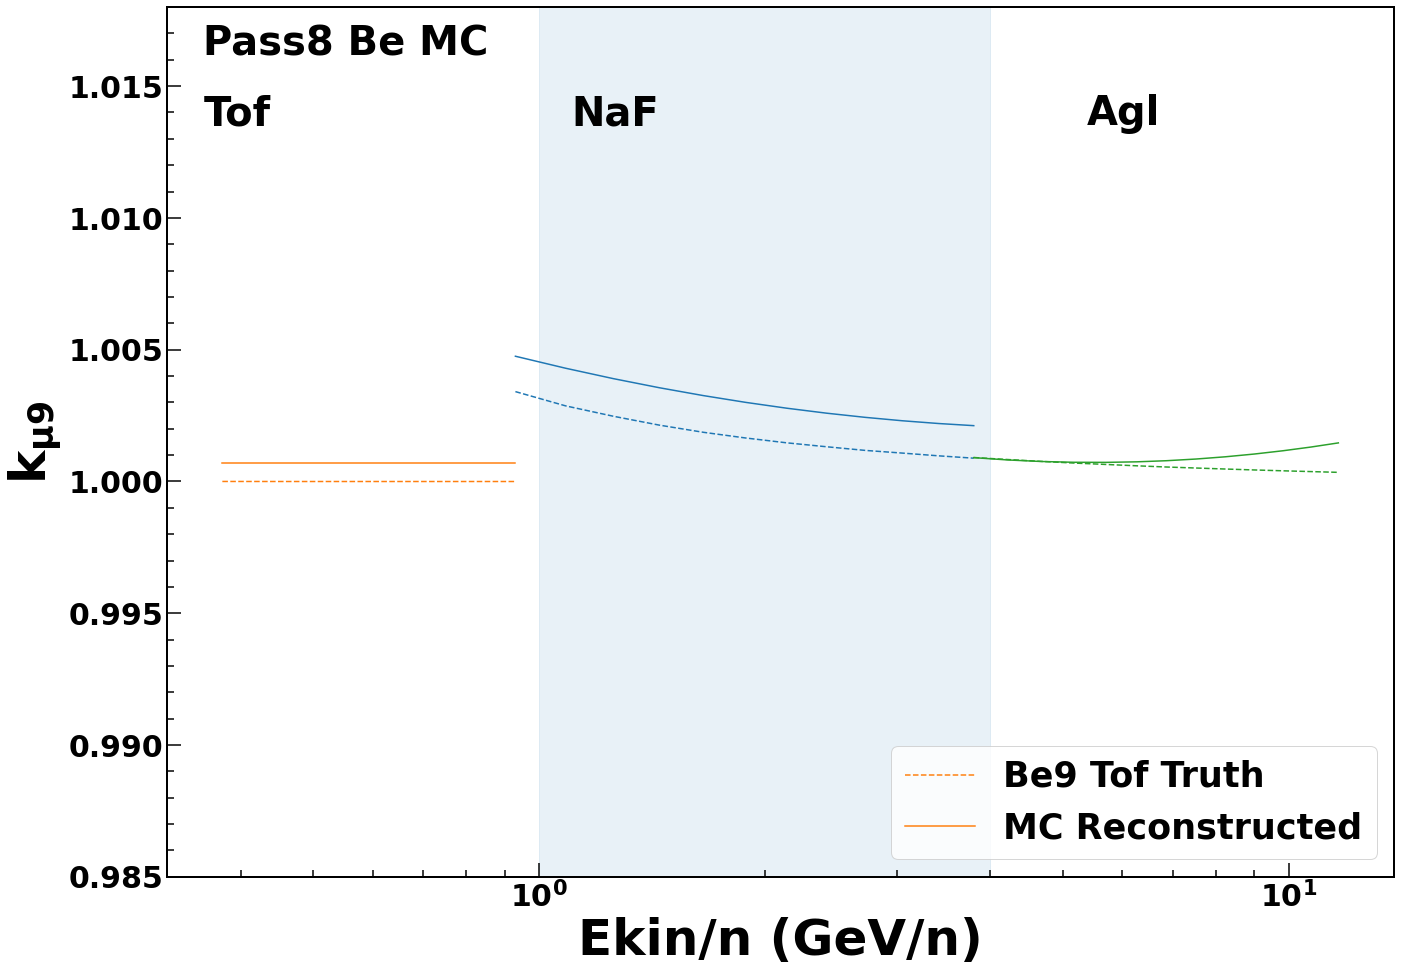

In [62]:
massratiobe9 = {}
massratiobe10 = {}
graph_massratio_be9 = {}
graph_massratio_be10 = {}
graph_massratio_be9_gausfit = {}
graph_massratio_be10_gausfit = {}

dfname = {dec: f'/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitmassgaus/df_mean_ratio_{dec}.npz' for dec in detectors}
#filename = filecounts_path + 'df_ratio_mean_iter2.npz'
dfgausfit = {dec:  np.load(f'{dfname[dec]}') for dec in detectors}
#dffit = np.load(f'{filename}')

slicevalue_trueratio ={'Tof':[0.3, 0.9], 'NaF':[1.0, 4.0], 'Agl':[4.0, 12.0]}
slicevalue_recratio ={'Tof':[0.3, 0.9], 'NaF':[1.0, 4.0], 'Agl':[4.0, 12.0]}

from tools.constants import ISOTOPES_MASS
flilename = filecounts_path + 'df_ratio_mean_iter2.npz'
df_measured_ratio = np.load(f'{filename}')
graph_massratio_be9_fromfit = {}
graph_massratio_be10_fromfit = {}

graph_ku_be9_gausfitP8 = {}
graph_ku_be10_gausfitP8 = {}
for dec in detectors:
    graph_ku_be9_gausfitP8[dec] = slice_graph_by_value((graph_mean_gausfit[dec]['Be9']/ graph_mean_gausfit[dec]['Be7']), slicevalue_trueratio[dec])
    graph_ku_be10_gausfitP8[dec] = slice_graph_by_value((graph_mean_gausfit[dec]['Be10']/ graph_mean_gausfit[dec]['Be7']) , slicevalue_trueratio[dec])
    
    graph_ku_be9_gausfitP8[dec].yvalues = graph_ku_be9_gausfitP8[dec].yvalues /(ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_ku_be10_gausfitP8[dec].yvalues = graph_ku_be10_gausfitP8[dec].yvalues /(ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])
    graph_massratio_be9_fromfit[dec] = MGraph.from_file(df_measured_ratio, f"graph_mass_sigma_9to7_{dec}")
    graph_massratio_be10_fromfit[dec] = MGraph.from_file(df_measured_ratio, f"graph_mass_sigma_10to7_{dec}")
    graph_massratio_be9_gausfit[dec] = MGraph.from_file(dfgausfit[dec], f'graph_ratio_mean_be9be7_{dec}')
    graph_massratio_be10_gausfit[dec] = MGraph.from_file(dfgausfit[dec], f'graph_ratio_mean_be10be7_{dec}')
for dec in detectors:
    massratiobe9[dec] = (1/ISOTOPES_MASS['Be9'] - deltamass[dec]['Be9'])/(1/ISOTOPES_MASS['Be7'] - deltamass[dec]['Be7'])
    graph_massratio_be9[dec] = MGraph(graph_deltamass[dec]['Be7'].xvalues, massratiobe9[dec], np.zeros_like(massratiobe9[dec]))
    massratiobe10[dec] = (1/ISOTOPES_MASS['Be10'] - deltamass[dec]['Be10'])/(1/ISOTOPES_MASS['Be7'] - deltamass[dec]['Be7'])
    graph_massratio_be10[dec] = MGraph(graph_deltamass[dec]['Be7'].xvalues, massratiobe10[dec], np.zeros_like(massratiobe10[dec]))
    graph_massratio_be9[dec] = slice_graph_by_value(graph_massratio_be9[dec], slicevalue_trueratio[dec])
    graph_massratio_be10[dec] = slice_graph_by_value(graph_massratio_be10[dec], slicevalue_trueratio[dec])
    graph_massratio_be9[dec].yvalues = graph_massratio_be9[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be9_gausfit[dec].yvalues = graph_massratio_be9_gausfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be9_fromfit[dec].yvalues = graph_massratio_be9_fromfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be10[dec].yvalues = graph_massratio_be10[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10']) 
    graph_massratio_be10_gausfit[dec].yvalues = graph_massratio_be10_gausfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])
    graph_massratio_be10_fromfit[dec].yvalues = graph_massratio_be10_fromfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])
        
fig, ax1 = plt.subplots(1, 1, figsize= (22, 16))
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_dec = {'Tof':[1.0], 'NaF':[1.0, 0.1, 0.1], "Agl":[1.0, 0.1, 0.1]}
dict_polypars_mufactor = {dec: {} for dec in detectors}
graphfitku_low = {}
graphfitku_up = {}
graphfitku = {}
for dec in detectors:
    graph_massratio_be9_fromfit[dec] = slice_graph_by_value(graph_massratio_be9_fromfit[dec], slicevalue_recratio[dec])
    graph_massratio_be9_gausfit[dec] = slice_graph_by_value(graph_massratio_be9_gausfit[dec], slicevalue_recratio[dec])
    
    ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '--', color=DETECTOR_COLOR[dec], label=f'Be9 {dec} Truth' if dec =='Tof' else None)
    if dec == 'Tof':
        #plot_graph(fig, ax1, graph_ku_be9_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=r"MC Reconstructed")
        #plot_graph(fig, ax1, graph_ku_be10_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", marker='+', xlog=False, ylog=False, scale=None, markersize=21)   
        ax1.text(xaxistext[dec], 0.98, f"Pass8 Be MC", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold") 
        ax1.text(xaxistext[dec], 0.9, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")
    else:
        #plot_graph(fig, ax1, graph_ku_be9_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21)   
        #plot_graph(fig, ax1, graph_ku_be10_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", marker='+', xlog=False, ylog=False, scale=None, markersize=21)   
        ax1.text(xaxistext[dec], 0.9, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")
        
    graphfitku[dec] = GetFitValue(graph_ku_be9_gausfitP8[dec], p0_dec[dec], withsigma=True)
    graphfitku_low[dec], graphfitku_up[dec] = getgraph_errband(graph_ku_be9_gausfitP8[dec], p0_dec[dec], withsig=True)
    if dec == 'Tof':
        plot_graph(fig, ax1, graphfitku[dec], color=DETECTOR_COLOR[dec], style="hist", xlog=False, ylog=False, scale=None, markersize=30, label='MC Reconstructed')
    else:
        plot_graph(fig, ax1, graphfitku[dec], color=DETECTOR_COLOR[dec], style="hist", xlog=False, ylog=False, scale=None, markersize=30)
    #ax1.fill_between(graphfitku_low[dec].xvalues, graphfitku_low[dec].yvalues, graphfitku_up[dec].yvalues,  color='grey', alpha=0.3, label=r'uncertainty')
    
set_plot_defaultstyle(ax1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)", fontsize=50) 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.985, 1.018, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 

ax1.set_ylim([0.985, 1.018])
ax1.set_ylabel(r'$\mathrm{k_{\mu9}}$', fontsize=50)
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=35)
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate0410/plots_0410'
savefig_tofile(fig, plotfile, 'mass_meanbe9correction_compareTruth', 1)

#mu_fitresult = np.array([1.0016966832122498, -0.0007740261544826998, 9.301036980402233e-05])
#ax1.plot(graph_massratio_be9['Agl'].xvalues, poly(np.log(graph_massratio_be9['Agl'].xvalues), *mu_fitresult), '--', color='black')


Tof be9:  [0.99999847] [[9.45493989e-14]]
Tof be10:  [0.9999912] [[3.12342518e-12]]
NaF be9:  [ 1.00312616e+00 -2.90241607e-03  9.23137989e-04] [[ 6.56607050e-10 -1.60726263e-09  8.53897584e-10]
 [-1.60726263e-09  6.87547972e-09 -4.52745942e-09]
 [ 8.53897584e-10 -4.52745942e-09  3.25157120e-09]]
NaF be10:  [ 1.00444382 -0.00413819  0.00131102] [[ 1.24595934e-09 -3.04985805e-09  1.62029726e-09]
 [-3.04985805e-09  1.30467538e-08 -8.59122708e-09]
 [ 1.62029726e-09 -8.59122708e-09  6.17015401e-09]]
Agl be9:  [ 1.00221816e+00 -1.24934979e-03  1.98915728e-04] [[ 7.59453213e-10 -8.14126480e-10  2.11260272e-10]
 [-8.14126480e-10  8.80254681e-10 -2.30068975e-10]
 [ 2.11260272e-10 -2.30068975e-10  6.05347515e-11]]
Agl be10:  [ 1.00314848e+00 -1.78447593e-03  2.84191988e-04] [[ 1.63052132e-09 -1.74793235e-09  4.53580472e-10]
 [-1.74793235e-09  1.88993781e-09 -4.93969578e-10]
 [ 4.53580472e-10 -4.93969578e-10  1.29971781e-10]]
dict_items([('Tof', {'Be9': array([0.99999847]), 'Be10': array([0.9999

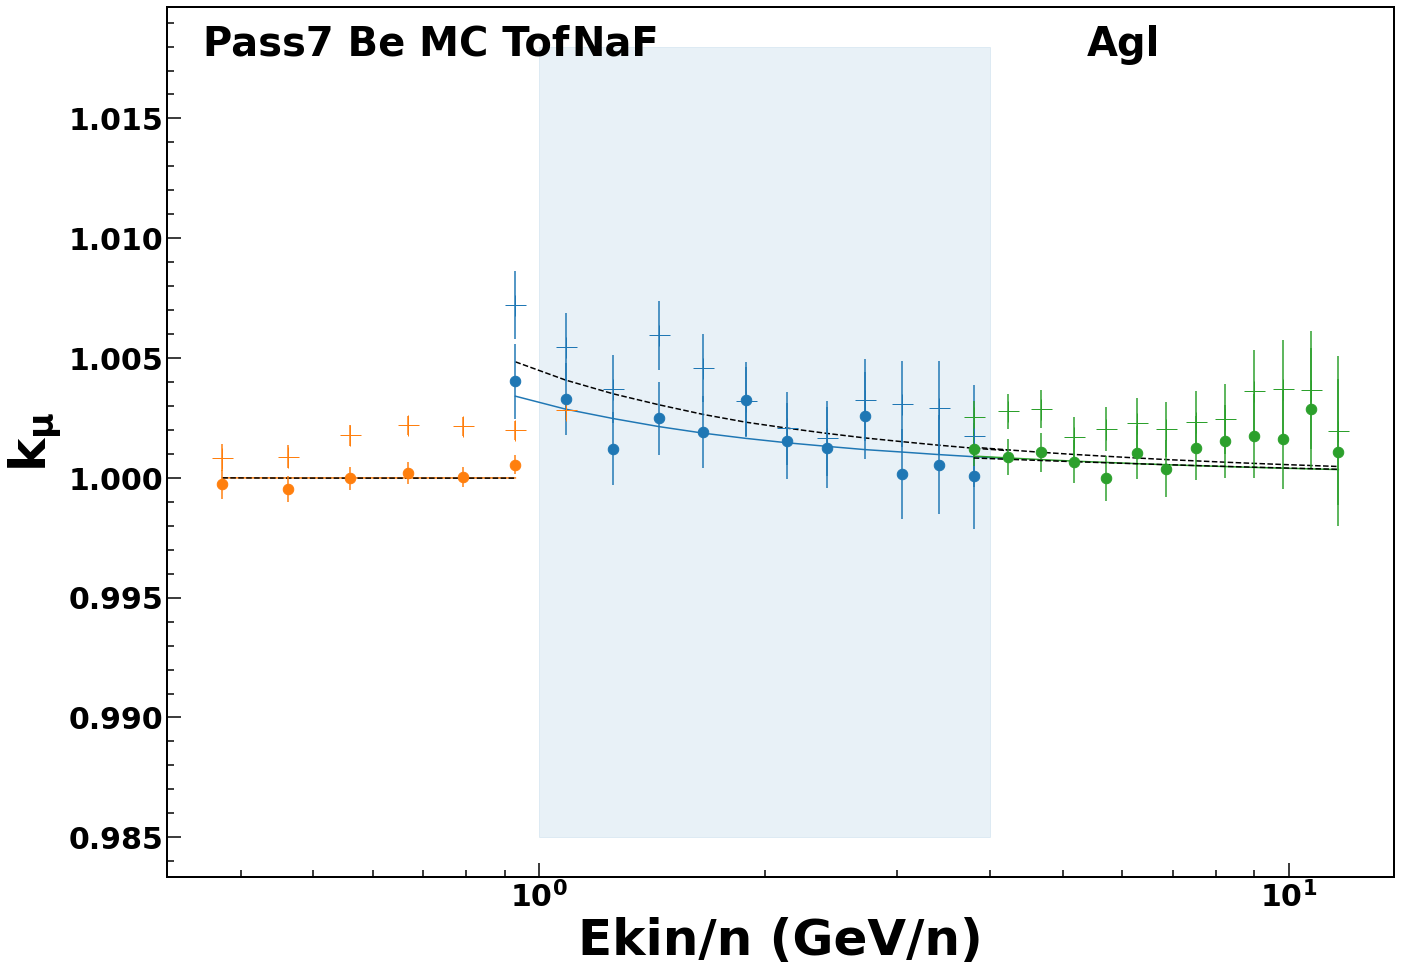

In [182]:
massratiobe9 = {}
massratiobe10 = {}
graph_massratio_be9 = {}
graph_massratio_be10 = {}
graph_massratio_be9_gausfit = {}
graph_massratio_be10_gausfit = {}

dfname = {dec: f'/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitmassgaus/df_mean_ratio_{dec}.npz' for dec in detectors}
#filename = filecounts_path + 'df_ratio_mean_iter2.npz'
dfgausfit = {dec:  np.load(f'{dfname[dec]}') for dec in detectors}
#dffit = np.load(f'{filename}')

slicevalue_trueratio ={'Tof':[0.3, 0.9], 'NaF':[1.0, 4.1], 'Agl':[4.0, 12.0]}
slicevalue_recratio ={'Tof':[0.3, 0.9], 'NaF':[1.0, 4.0], 'Agl':[4.0, 12.0]}

from tools.constants import ISOTOPES_MASS
filename = filecounts_path + 'df_ratio_mean_iter2.npz'
df_measured_ratio = np.load(f'{filename}')
graph_massratio_be9_fromfit = {}
graph_massratio_be10_fromfit = {}

graph_ku_be9_gausfitP8 = {}
graph_ku_be10_gausfitP8 = {}
for dec in detectors:
    graph_ku_be9_gausfitP8[dec] = slice_graph_by_value((graph_mean_gausfit[dec]['Be9']/ graph_mean_gausfit[dec]['Be7']), slicevalue_trueratio[dec])
    graph_ku_be10_gausfitP8[dec] = slice_graph_by_value((graph_mean_gausfit[dec]['Be10']/ graph_mean_gausfit[dec]['Be7']) , slicevalue_trueratio[dec])
    
    graph_ku_be9_gausfitP8[dec].yvalues = graph_ku_be9_gausfitP8[dec].yvalues /(ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_ku_be10_gausfitP8[dec].yvalues = graph_ku_be10_gausfitP8[dec].yvalues /(ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])    
    graph_massratio_be9_fromfit[dec] = MGraph.from_file(df_measured_ratio, f"graph_mass_sigma_9to7_{dec}")
    graph_massratio_be10_fromfit[dec] = MGraph.from_file(df_measured_ratio, f"graph_mass_sigma_10to7_{dec}")
    graph_massratio_be9_gausfit[dec] = MGraph.from_file(dfgausfit[dec], f'graph_ratio_mean_be9be7_{dec}')
    graph_massratio_be10_gausfit[dec] = MGraph.from_file(dfgausfit[dec], f'graph_ratio_mean_be10be7_{dec}')
for dec in detectors:
    massratiobe9[dec] = (1/ISOTOPES_MASS['Be9'] - deltamass[dec]['Be9'])/(1/ISOTOPES_MASS['Be7'] - deltamass[dec]['Be7'])
    graph_massratio_be9[dec] = MGraph(graph_deltamass[dec]['Be7'].xvalues, massratiobe9[dec], np.zeros_like(massratiobe9[dec]))
    massratiobe10[dec] = (1/ISOTOPES_MASS['Be10'] - deltamass[dec]['Be10'])/(1/ISOTOPES_MASS['Be7'] - deltamass[dec]['Be7'])
    graph_massratio_be10[dec] = MGraph(graph_deltamass[dec]['Be7'].xvalues, massratiobe10[dec], np.zeros_like(massratiobe10[dec]))
    graph_massratio_be9[dec] = slice_graph_by_value(graph_massratio_be9[dec], slicevalue_trueratio[dec])
    graph_massratio_be10[dec] = slice_graph_by_value(graph_massratio_be10[dec], slicevalue_trueratio[dec])
    graph_massratio_be9[dec].yvalues = graph_massratio_be9[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be9_gausfit[dec].yvalues = graph_massratio_be9_gausfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be9_fromfit[dec].yvalues = graph_massratio_be9_fromfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'])
    graph_massratio_be10[dec].yvalues = graph_massratio_be10[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10']) 
    graph_massratio_be10_gausfit[dec].yvalues = graph_massratio_be10_gausfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])
    graph_massratio_be10_fromfit[dec].yvalues = graph_massratio_be10_fromfit[dec].yvalues / (ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'])
        
fig, ax1 = plt.subplots(1, 1, figsize= (22, 16))
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_dec = {'Tof':[1.0], 'NaF':[1.0, 0.1, 0.1], "Agl":[1.0, 0.1, 0.1]}
dict_polypars_mufactor = {dec: {} for dec in detectors}
for dec in detectors:
    graph_massratio_be9_fromfit[dec] = slice_graph_by_value(graph_massratio_be9_fromfit[dec], slicevalue_recratio[dec])
    graph_massratio_be9_gausfit[dec] = slice_graph_by_value(graph_massratio_be9_gausfit[dec], slicevalue_recratio[dec])
  
    ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '-', color=DETECTOR_COLOR[dec], label=f'Be9 {dec} Generated')
    ax1.plot(graph_massratio_be10[dec].xvalues, graph_massratio_be10[dec].yvalues, '--', color='black', label=f'Be10 {dec} Generated')
    #plot_graph(fig, ax1, graph_ku_be9_gausfitP8[dec], color='grey', style="EP", markerfacecolor='none', xlog=False, ylog=False, scale=None, markersize=21, label=r"MC Reconstructed")
    #plot_graph(fig, ax1, graph_ku_be10_gausfitP8[dec], color='grey', style="EP", markerfacecolor='none', xlog=False, ylog=False, scale=None, markersize=21, label=r"MC Reconstructed")
    if dec == 'Tof':
        #plot_graph(fig, ax1, graph_massratio_be9[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be9}, true}$")
        #ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '-', color=DETECTOR_COLOR[dec])
        plot_graph(fig, ax1, graph_massratio_be9_gausfit[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=r"MC Reconstructed")
        plot_graph(fig, ax1, graph_massratio_be10_gausfit[dec], color=DETECTOR_COLOR[dec], style="EP", marker='+', xlog=False, ylog=False, scale=None, markersize=21, label=r"MC Reconstructed")
        #plot_graph(fig, ax1, graph_ku_be9_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=r"MC Reconstructed")
        #plot_graph(fig, ax1, graph_ku_be10_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", marker='+', xlog=False, ylog=False, scale=None, markersize=21, label=r"MC Reconstructed")
        ax1.text(xaxistext[dec], 0.98, f"Pass7 Be MC {dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      

    else:
        #ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '-', color=DETECTOR_COLOR[dec])
        #plot_graph(fig, ax1, graph_massratio_be9[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        plot_graph(fig, ax1, graph_massratio_be9_gausfit[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21)   
        plot_graph(fig, ax1, graph_massratio_be10_gausfit[dec], color=DETECTOR_COLOR[dec], style="EP", marker='+', xlog=False, ylog=False, scale=None, markersize=21) 
        #plot_graph(fig, ax1, graph_ku_be9_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21)   
        #plot_graph(fig, ax1, graph_ku_be10_gausfitP8[dec], color=DETECTOR_COLOR[dec], style="EP", marker='+', xlog=False, ylog=False, scale=None, markersize=21)   
        ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
    popt, pcov = curve_fit(poly, np.log(graph_massratio_be9[dec].xvalues), graph_massratio_be9[dec].yvalues, p0 = p0_dec[dec])  
    print(dec, "be9: ", popt, pcov)
    dict_polypars_mufactor[dec]['Be9'] = popt
    
    #ax1.plot(graph_massratio_be9[dec].xvalues, poly(np.log(graph_massratio_be9[dec].xvalues), *popt), '--', color='black')
    popt10, pcov10 = curve_fit(poly, np.log(graph_massratio_be10[dec].xvalues), graph_massratio_be10[dec].yvalues, p0 = p0_dec[dec])  
    print(dec, "be10: ", popt10, pcov10)
    dict_polypars_mufactor[dec]['Be10'] = popt10
    

with open('/home/manbing/Documents/Data/data_BeP8/polypars_mufactor.pickle', 'wb') as file:
    pickle.dump(dict_polypars_mufactor, file)
    

with open('/home/manbing/Documents/Data/data_BeP8/polypars_mufactor.pickle', 'rb') as file:
    loadfile = pickle.load(file)
    print(loadfile.items())
                                                                                                                                                                                                                                                         
set_plot_defaultstyle(ax1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)", fontsize=50) 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.985, 1.018, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
#ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'], color='orange', linestyle='--') 
#ax1.axhline(y=1.0, color='orange', linestyle='--')  
#ax1.axhline(y=0.77869417, color='black', linestyle='--')  
#ax1.set_ylim([0.985, 1.018])
ax1.set_ylabel(r'$\mathrm{k_{\mu}}$', fontsize=50)
ax1.set_xscale('log')
#ax1.legend(loc='lower right', fontsize=35)
#plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate0410/plots_0410'
#savefig_tofile(fig, plotfile, 'mass_meanbe9correction', 1)

mu_fitresult = np.array([1.0016966832122498, -0.0007740261544826998, 9.301036980402233e-05])
ax1.plot(graph_massratio_be9['Agl'].xvalues, poly(np.log(graph_massratio_be9['Agl'].xvalues), *mu_fitresult), '--', color='black')


Tof be10:  [9.99991343e-01 1.95566274e-05 2.78509067e-05] [[5.79056690e-12 2.28386358e-11 1.84014484e-11]
 [2.28386358e-11 1.20023712e-10 1.08182239e-10]
 [1.84014484e-11 1.08182239e-10 1.03752829e-10]]
NaF be10:  [ 1.00444382 -0.00413819  0.00131103] [[ 1.24599875e-09 -3.05000857e-09  1.62039416e-09]
 [-3.05000857e-09  1.30472846e-08 -8.59155584e-09]
 [ 1.62039416e-09 -8.59155584e-09  6.17035329e-09]]
Agl be10:  [ 1.00314848e+00 -1.78447412e-03  2.84191522e-04] [[ 1.63068168e-09 -1.74807522e-09  4.53611927e-10]
 [-1.74807522e-09  1.89005887e-09 -4.93994761e-10]
 [ 4.53611927e-10 -4.93994761e-10  1.29976654e-10]]


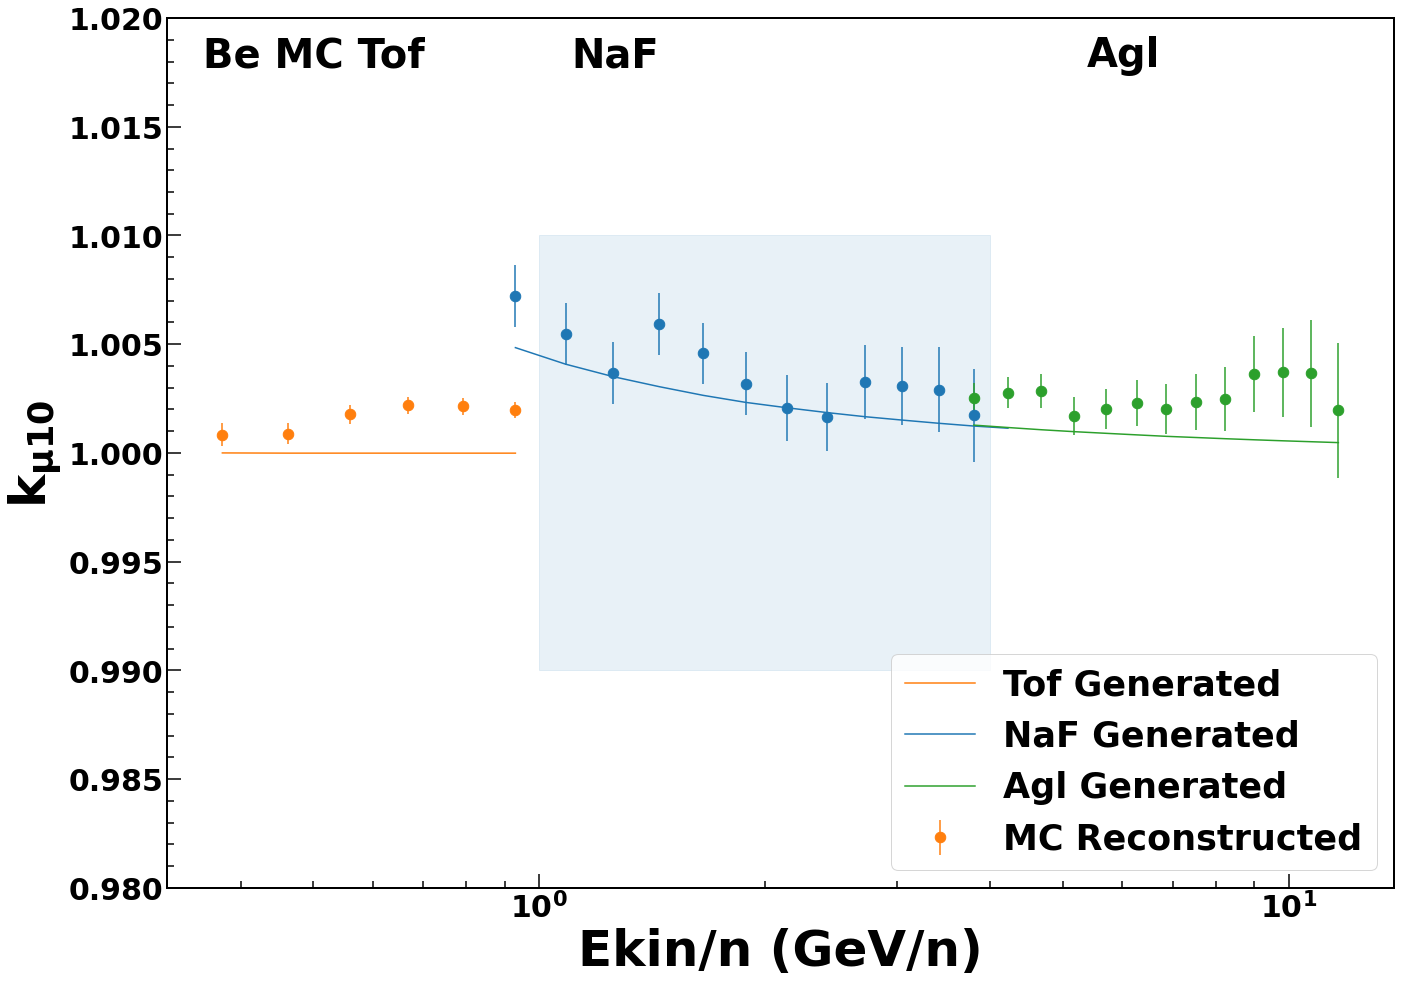

In [38]:

    
        
fig, ax1 = plt.subplots(1, 1, figsize= (22, 16))
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_dec = {'Tof':[0.7, 0.1, 0.1], 'NaF':[0.7, 0.1, 0.1], "Agl":[0.7, 0.1, 0.1]}
for dec in detectors:
    graph_massratio_be10_fromfit[dec] = slice_graph_by_value(graph_massratio_be10_fromfit[dec], slicevalue_recratio[dec])
    graph_massratio_be10_gausfit[dec] = slice_graph_by_value(graph_massratio_be10_gausfit[dec], slicevalue_recratio[dec])
    ax1.plot(graph_massratio_be10[dec].xvalues, graph_massratio_be10[dec].yvalues, '-', color=DETECTOR_COLOR[dec], label=f'{dec} Generated')
    if dec == 'Tof':
        #plot_graph(fig, ax1, graph_massratio_be9[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be9}, true}$")
        #ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '-', color=DETECTOR_COLOR[dec])
        plot_graph(fig, ax1, graph_massratio_be10_gausfit[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=r"MC Reconstructed")
        ax1.text(xaxistext[dec], 0.98, f"Be MC {dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      

    else:
        #ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '-', color=DETECTOR_COLOR[dec])
        #plot_graph(fig, ax1, graph_massratio_be9[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        plot_graph(fig, ax1, graph_massratio_be10_gausfit[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21)   
        ax1.text(xaxistext[dec], 0.98, f"{dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
    popt, pcov = curve_fit(poly, np.log(graph_massratio_be10[dec].xvalues), graph_massratio_be10[dec].yvalues, p0 = p0_dec[dec])  
    print(dec, "be10: ", popt, pcov)
    #ax1.plot(graph_massratio_be9_gausfit[dec].xvalues, poly(np.log(graph_massratio_be9_gausfit[dec].xvalues), *popt), "-", color='black')                                                                          
                                                                                                                                                                                                                                                         
set_plot_defaultstyle(ax1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)", fontsize=50) 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.99, 1.01, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
#ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'], color='orange', linestyle='--') 

#ax1.axhline(y=1.0, color='orange', linestyle='--')  
#ax1.axhline(y=0.77869417, color='black', linestyle='--')  

ax1.set_ylim([0.98, 1.02])
ax1.set_ylabel(r'$\mathrm{k_{\mu10}}$', fontsize=50)
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=35)
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate0410/plots_0410'
savefig_tofile(fig, plotfile, 'mass_meanbe9correction', 1)



In [73]:
scale_factor_name = {'Tof': {iso: f'muscale_{iso}' for iso in isotopes[1:]},                                                                                                                                                                  
                         'NaF': {iso: [f'muscale_{iso}_{a}' for a in ['a', 'b', 'c']] for iso in isotopes[1:]},                                                                                                                                   
                         'Agl': {iso: [f'muscale_{iso}_{a}' for a in ['a', 'b', 'c']] for iso in isotopes[1:]}}     
print(scale_factor_name)

{'Tof': {'Be9': 'muscale_Be9', 'Be10': 'muscale_Be10'}, 'NaF': {'Be9': ['muscale_Be9_a', 'muscale_Be9_b', 'muscale_Be9_c'], 'Be10': ['muscale_Be10_a', 'muscale_Be10_b', 'muscale_Be10_c']}, 'Agl': {'Be9': ['muscale_Be9_a', 'muscale_Be9_b', 'muscale_Be9_c'], 'Be10': ['muscale_Be10_a', 'muscale_Be10_b', 'muscale_Be10_c']}}


Tof be10:  [7.00670813e-01 3.81830371e-06 1.08900543e-05] [[ 4.50093301e-13  3.56351035e-13 -2.78984079e-13]
 [ 3.56351035e-13  9.16322774e-12  1.02344273e-11]
 [-2.78984079e-13  1.02344273e-11  1.39409390e-11]]
NaF be10:  [ 0.70375996 -0.00266401  0.00072569] [[ 1.18511166e-09 -2.33826340e-09  9.92954436e-10]
 [-2.33826340e-09  7.36992172e-09 -3.76307348e-09]
 [ 9.92954436e-10 -3.76307348e-09  2.08167684e-09]]
Agl be10:  [ 7.02933539e-01 -1.29998334e-03  2.11533217e-04] [[ 7.19481098e-10 -7.96450481e-10  2.11755003e-10]
 [-7.96450481e-10  8.91809533e-10 -2.39307255e-10]
 [ 2.11755003e-10 -2.39307255e-10  6.47569884e-11]]


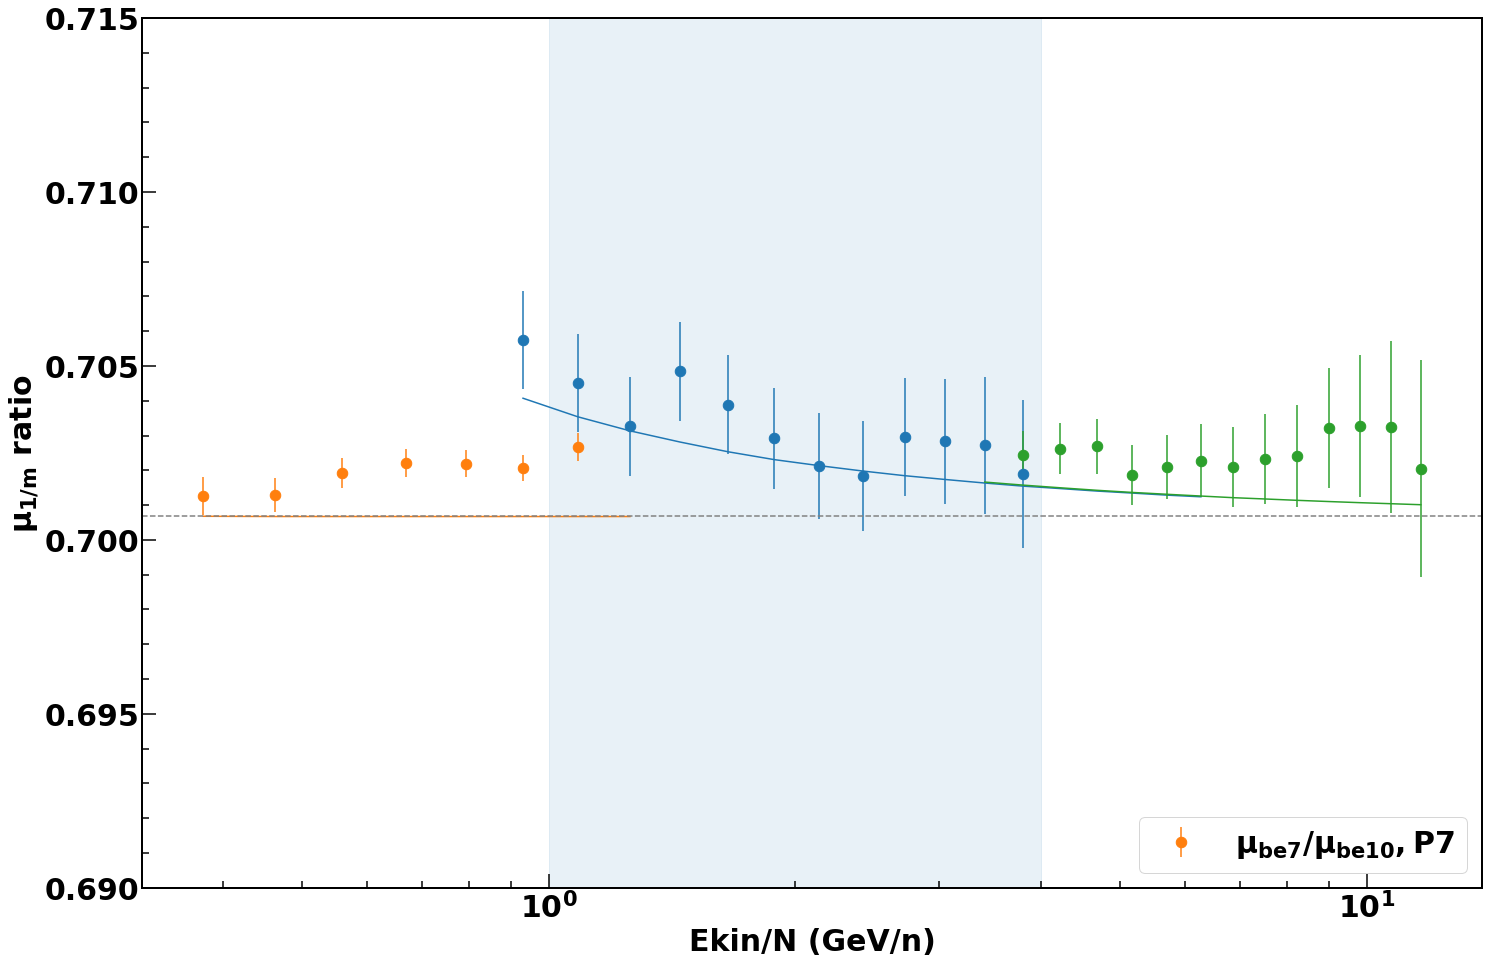

In [26]:
fig, ax1 = plt.subplots(1, 1, figsize= (24, 16))
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_dec = {'Tof':[0.7, 0.01, 0.01], 'NaF':[0.7, 0.01, 0.01], "Agl":[0.7, 0.01, 0.01]}

for dec in detectors: 
    if dec == 'Tof':
        #plot_graph(fig, ax1, graph_massratio_be9[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be9}, true}$")
        ax1.plot(graph_massratio_be10[dec].xvalues, graph_massratio_be10[dec].yvalues, '-', color=DETECTOR_COLOR[dec])
        #graph_massratio_be10_gausfit[dec].yvalues = graph_massratio_be10_gausfit[dec].yvalues * 0.9995
        plot_graph(fig, ax1, graph_massratio_be10_gausfit[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=r"$\mathrm{\mu_{be7}/\mu_{be10}, P7}$")
    else:
        ax1.plot(graph_massratio_be10[dec].xvalues, graph_massratio_be10[dec].yvalues, '-', color=DETECTOR_COLOR[dec])
        #plot_graph(fig, ax1, graph_massratio_be9[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        plot_graph(fig, ax1, graph_massratio_be10_gausfit[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21)        
        
    popt, pcov = curve_fit(poly, np.log(graph_massratio_be10[dec].xvalues), graph_massratio_be10[dec].yvalues, p0 = p0_dec[dec])  
    print(dec, "be10: ", popt, pcov)
    #ax1.plot(graph_massratio_be10_gausfit[dec].xvalues, poly(np.log(graph_massratio_be10_gausfit[dec].xvalues), *popt), "--", color='black')                                                                          
                                                                                                                                                                                                                                                           
set_plot_defaultstyle(ax1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])              


ax1.set_xlabel("Ekin/n (GeV/n)") 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.68, 0.8, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'], color='grey', linestyle='--') 

#ax1.axhline(y=1.0, color='orange', linestyle='--')  
#ax1.axhline(y=0.77869417, color='black', linestyle='--')  

ax1.set_ylim([0.69, 0.715])
ax1.set_xlabel('Ekin/N (GeV/n)')
ax1.set_ylabel(r'$\mathrm{\mu_{1/m} ~ ratio}$')
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=30)

savefig_tofile(fig, plotdir, 'mass_ratio_be10_fitgausP7', 1)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


KeyError: 'Be7'

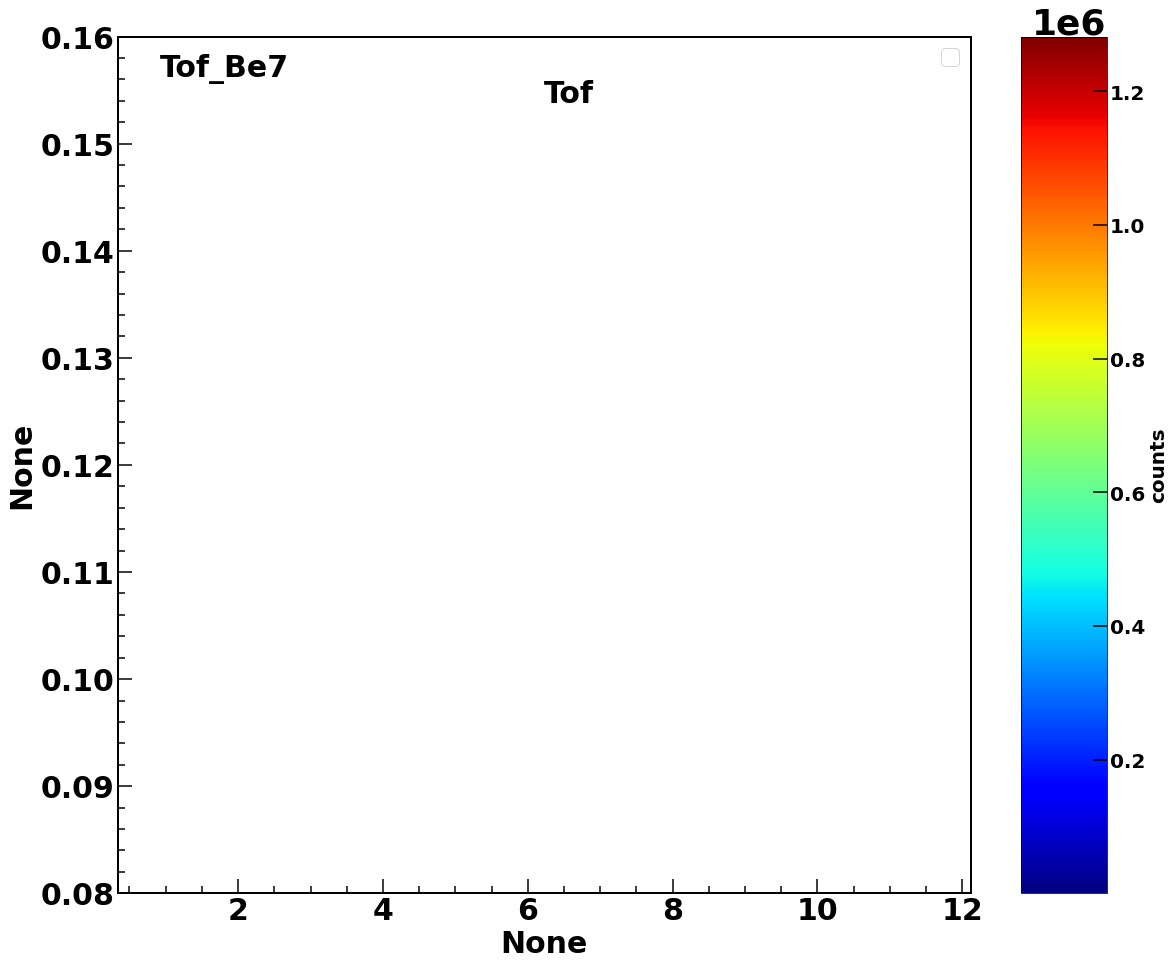

In [27]:
df = np.load(f'{filename_hist}')
detectors = ['Tof', 'NaF', 'Agl']
hist2d= {dec: {} for dec in detectors}
hist_counts2 = {dec: {} for dec in detectors}
isotopes = ['Be7', 'Be9', 'Be10']
for dec in detectors:
    for iso in isotopes:
        fig, ax1 = plt.subplots(1, 1, figsize=(17, 14))
        hist2d[dec][iso] = WeightedHistogram.from_file(df, f'{iso}MC_{dec}_truemass_atdec')   
        plot2dhist(fig, ax1, xbinning=hist2d[dec][iso].binnings[0].edges[1:-1],
                       ybinning=hist2d[dec][iso].binnings[1].edges[1:-1],
                       counts=hist2d[dec][iso].values[1:-1, 1:-1], 
                       xlabel=None, ylabel=None, zlabel="counts", zmin=None, zmax=None, 
                       setlogx=False, setlogy=False, setscilabelx=False, setscilabely=False,  setlogz=False)  
        ax1.text(0.05, 0.98, f"{dec}_{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left',transform=ax1.transAxes, color="black", fontweight="bold") 
        
        ax1.legend(fontsize=23)
        ax1.text(0.5, 0.95, f'{dec}', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
        ax1.set_ylim(ylimvalue[iso])
        savefig_tofile(fig, plotdir, f"masstrue_{dec}_{iso}_atdec", show=True)

In [28]:
hist_input_ratiobe9be7 = dict()
hist_input_ratiobe10be9 = dict()
graph_ratio_be9be7 = dict()
graph_ratio_be10be9 = dict()

for dec in detectors:
    hist_input_ratiobe9be7[dec], errbe9 = calc_ratio_and_err(hist_counts2[dec]['Be9'].values * 0.6, hist_counts2[dec]['Be7'].values, 
                                                          np.sqrt(hist_counts2[dec]['Be9'].values) * 0.6, np.sqrt(hist_counts2[dec]['Be7'].values))
    hist_input_ratiobe10be9[dec], errbe10 = calc_ratio_and_err(hist_counts2[dec]['Be10'].values * 0.2, hist_counts2[dec]['Be9'].values*0.6,
                                                               np.sqrt(hist_counts2[dec]['Be10'].values) * 0.2, np.sqrt(hist_counts2[dec]['Be9'].values * 0.6))
    graph_ratio_be9be7[dec] = MGraph(hist_counts2[dec]['Be9'].binnings[0].bin_centers, hist_input_ratiobe9be7[dec], errbe9)
    graph_ratio_be10be9[dec] = MGraph(hist_counts2[dec]['Be10'].binnings[0].bin_centers, hist_input_ratiobe10be9[dec], errbe10)
    graph_ratio_be9be7[dec] = slice_graph_by_value(graph_ratio_be9be7[dec], ANALYSIS_RANGE_EKIN[dec])
    graph_ratio_be10be9[dec] = slice_graph_by_value(graph_ratio_be10be9[dec], ANALYSIS_RANGE_EKIN[dec])
    print(graph_ratio_be9be7[dec])

    


KeyError: 'Be9'

In [29]:
detectors = ['Tof', 'NaF', 'Agl']
isotopes = ["Be7", "Be9", "Be10"]
x_binning = fbinning_energy()
#read jiahui flux                                                                                                                                                                                              
jiahui_fluxfile = {iso :f'/home/manbing/Documents/Data/jiahui/beflux_10yr/{iso}_raw.txt' for iso in isotopes}                                                                                          
graph_jiahui_flux = dict()                                                                                                                                                                                     
graph_jiahui_flux_totalerr = dict()                                                                                                                                                                            
for iso in isotopes:                                                                                                                                                                                   
    jiahuiflux = pd.read_csv(jiahui_fluxfile[iso], sep='\s+', header=0)                                                                                                                                        
    xjiahuiflux = 0.5*(jiahuiflux['Ek_low'] + jiahuiflux['Ek_high'])                                                                                                                                           
    graph_jiahui_flux[iso] = MGraph(xjiahuiflux, jiahuiflux['Flux'], jiahuiflux['Stat_err'])                                                                                                                   
    graph_jiahui_flux_totalerr[iso] = MGraph(xjiahuiflux, jiahuiflux['Flux'], jiahuiflux['Total_Err'])                                  


df_counts = np.load(f'{filename_counts}')
df_counts_compare = np.load(f'{filename_hist}')
isoax2lim = {"Be7": [0.9, 1.1], "Be9": [0.8, 1.2], "Be10": [0.8, 1.2]}
figSize = (22, 15)


graph_counts_fromfit = {dec: {} for dec in detectors}
graph_counts_compare = {dec: {} for dec in detectors}
graph_ratio_be9be7_fit = dict()
graph_ratio_be10be9_fit = dict()
graph_ratio_be9be7_input = dict()
graph_ratio_be10be9_input = dict()

hist_mass2d = {dec: {} for dec in detectors}
xbinning = Binning(fbinning_energy())
for dec in detectors:
    for iso in isotopes:
        graph_counts_fromfit[dec][iso] = MGraph.from_file(df_counts, f"graph_counts_{dec}_{iso}")
        graph_counts_fromfit[dec][iso] = slice_graph_by_value(graph_counts_fromfit[dec][iso], slicevalue[dec])
        hist_mass2d[dec][iso] = WeightedHistogram.from_file(df_counts_compare, f"{iso}MC_{dec}_mass_test")
        graph_counts_compare[dec][iso] = MGraph(xbinning.bin_centers[1:-1], np.sum(hist_mass2d[dec][iso].values[1:-1, 1:-1], axis=1), np.sqrt(np.sum(hist_mass2d[dec][iso].values[1:-1, 1:-1], axis=1)))
        #graph_counts_compare[dec][iso] = MGraph.from_file(df_counts_compare, f'{dec}_{iso}MC_counts')
        xstart = graph_counts_fromfit[dec][iso].xvalues[0]
        xend = graph_counts_fromfit[dec][iso].xvalues[-1]
        graph_counts_compare[dec][iso] = slice_graph_by_value(graph_counts_compare[dec][iso], np.array([xstart, xend]))
        

for dec in detectors:
    graph_ratio_be9be7_fit[dec] = graph_counts_fromfit[dec]['Be9']/graph_counts_fromfit[dec]['Be7']
    graph_ratio_be10be9_fit[dec] = graph_counts_fromfit[dec]['Be10']/graph_counts_fromfit[dec]['Be9']
    graph_ratio_be9be7_input[dec] = graph_counts_compare[dec]['Be9']/graph_counts_compare[dec]['Be7']
    graph_ratio_be10be9_input[dec] = graph_counts_compare[dec]['Be10']/graph_counts_compare[dec]['Be9']
    
for iso in isotopes: 
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.6, 0.4]}, figsize=(26, 16))                                                                                                            
    fig.subplots_adjust(left= 0.12, right=0.97, bottom=0.08, top=0.95) 
    for dec in detectors:
        plot_graph(fig, ax1, graph_counts_fromfit[dec][iso], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec} ')  
        plot_graph(fig, ax1, graph_counts_compare[dec][iso], color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec} input', markerfacecolor="none") 
        #if dec == "Agl" and iso == "Be9":                                                                                                                                                            
        #    print(dec, iso)                                                                                                                                                                          
        #    print(graph_counts_fromfit[dec][iso])  
        
        graph_ratio = graph_counts_fromfit[dec][iso]/graph_counts_compare[dec][iso]
        plot_graph(fig, ax2, graph_ratio, color=DETECTOR_COLOR[dec],  style="EP", xlog=True, ylog=False, scale=None, markersize=22, label=f'{dec}')  
        graph_syserr = MGraph(graph_jiahui_flux_totalerr[iso].xvalues, graph_jiahui_flux_totalerr[iso].yerrs/graph_jiahui_flux_totalerr[iso].yvalues, np.zeros_like(graph_jiahui_flux_totalerr[iso].xvalues))                                                                                                                                                                                                          
        #ax2.stairs(1 - graph_syserr.yvalues, x_binning,  color='grey', baseline=None)                                                                                                                          
        #ax2.stairs(1 + graph_syserr.yvalues, x_binning,  color='grey', baseline=None)  
    
    ax2.grid(axis='y')
    ax2.set_xlabel('Ekin/n (GeV/n)') 
    ax1.legend(loc="upper right", fontsize=30) 
    ax1.set_xticklabels([])
    plt.subplots_adjust(hspace=.0)   
    ax1.get_yticklabels()[0].set_visible(False)
    ax1.set_ylabel('counts')

    ax1.legend(loc="upper right", fontsize=30) 
    ax1.set_xticklabels([])

    plt.subplots_adjust(hspace=.0)   
    ax1.get_yticklabels()[0].set_visible(False)
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax2.set_ylabel('ratio', fontsize=32)
    
    ax2.set_ylim(isoax2lim[iso])
    #ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax2.set_xticks(np.array([2, 4, 10]))
    ax1.text(0.5, 0.9, f'{iso}', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black')
    #plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_1309/plots_1309'
    savefig_tofile(fig, plotdir, f"counts_fromfit_{iso}_MCP8", show=True) 
    

FileNotFoundError: [Errno 2] No such file or directory: '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/mcB1236_rebin/graph_counts_mcmix_rawmc.npz'

NameError: name 'graph_ratio_be10be9_input' is not defined

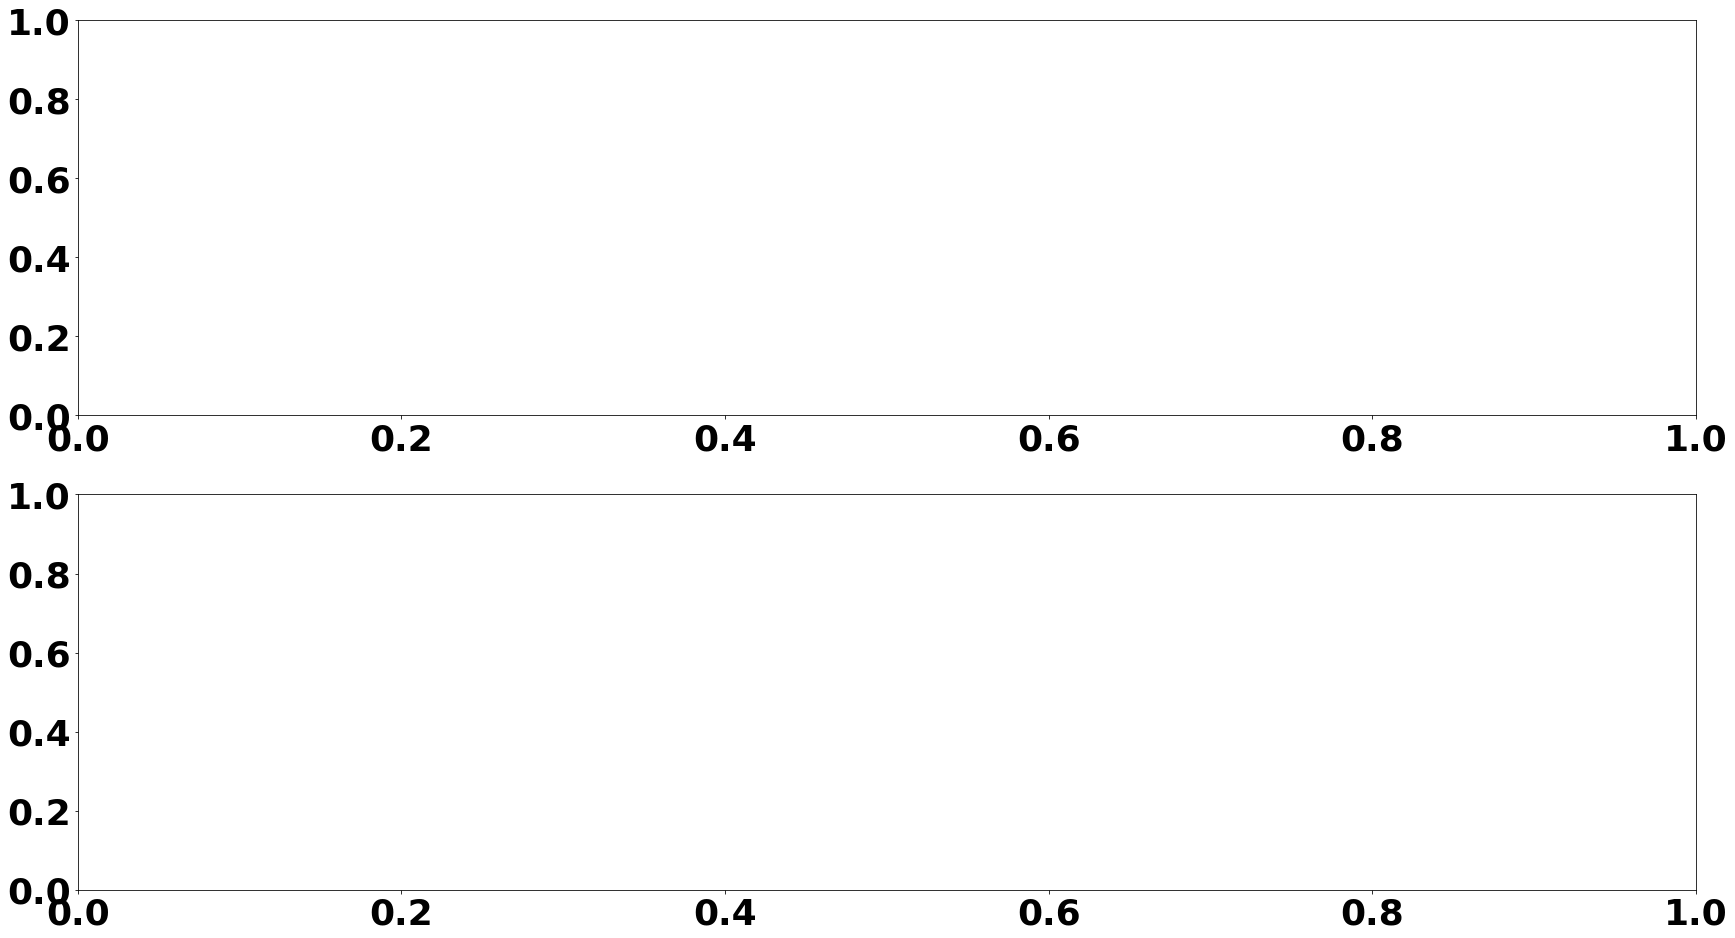

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(29, 16)) 
#ax1.text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold") 

for dec in detectors:
    plot_graph(fig, ax2, graph_ratio_be10be9_input[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, markersize=20, label='f{dec} input')
    plot_graph(fig, ax1, graph_ratio_be9be7_input[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, markersize=20, label=f'{dec} input')
    #plot_graph(fig, ax2, graph_ratio_be10be9_fit[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, markersize=20, label='f{dec} fit')
    #plot_graph(fig, ax1, graph_ratio_be9be7_fit[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, markersize=20, label=f'{dec} fit')
#ax2.set_ylim([0.1, 0.4])                                                                                                                             
#ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
ax2.set_ylabel(r"$\mathrm{N_{^{10}Be}/N_{^{9}Be}}$", fontsize=35)
ax1.set_ylabel(r"$\mathrm{N_{^{9}Be}/N_{^{7}Be}}$", fontsize=35)   
ax2.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)
ax1.legend(fontsize=20)

ax1.set_ylim([0.1, 1.0])                                                                                                                              
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax1.get_yticklabels()[0].set_visible(False)
set_plot_defaultstyle(ax1)    
set_plot_defaultstyle(ax2) 
ax1.set_xscale('log')
ax2.set_xscale('log')
#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_3008/plots_3008'
savefig_tofile(fig, plotdir, 'input_ratio_rawmcv1', 1)

NameError: name 'graph_ratio_be10be9_input' is not defined

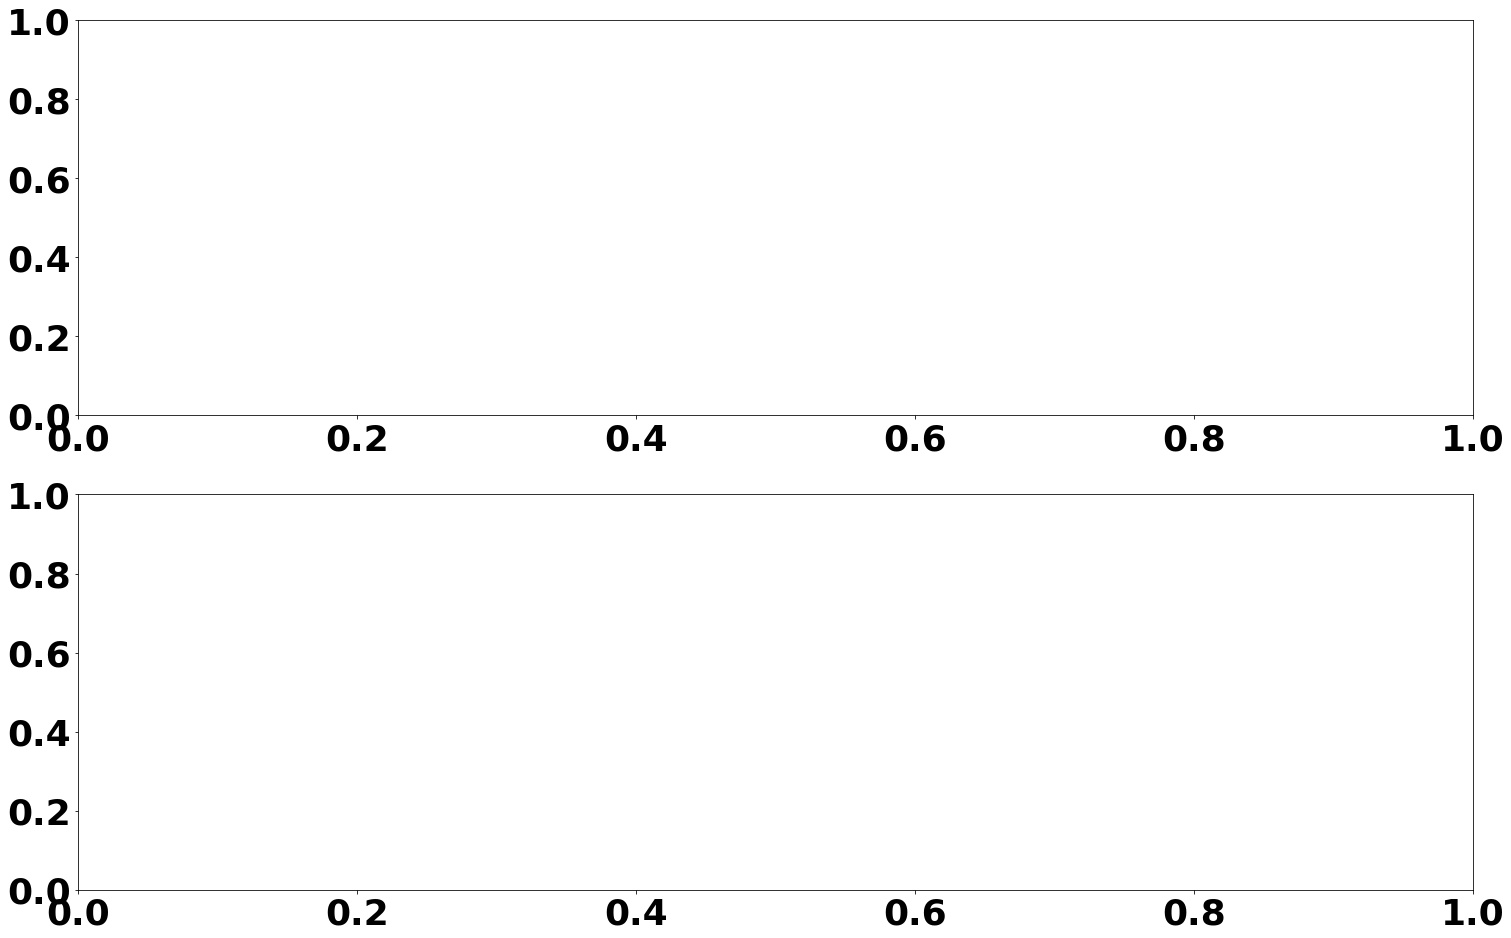

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.5, 0.5]}, figsize=(25, 16)) 
#ax1.text(0.5, 0.98, f"{iso}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax[i].transAxes, color="black", fontweight="bold") 

for dec in detectors:
    plot_graph(fig, ax2, graph_ratio_be10be9_input[dec], color='black', style="EP", xlog=False, ylog=False, markersize=20, label='f{dec} input')
    plot_graph(fig, ax1, graph_ratio_be9be7_input[dec], color='black', style="EP", xlog=False, ylog=False, markersize=20, label=f'{dec} input')
    plot_graph(fig, ax2, graph_ratio_be10be9_fit[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, markersize=20, label='f{dec} fit')
    plot_graph(fig, ax1, graph_ratio_be9be7_fit[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, markersize=20, label=f'{dec} fit')
ax2.set_ylim([0.2, 0.6])                                                                                                                             
#ax1.set_xticks([0.4, 1, 2, 3, 5, 10])                                                                                                                                                                      
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())                                                                                                                                   
ax2.set_ylabel(r"$\mathrm{N_{^{10}Be}/N_{^{9}Be}}$", fontsize=35)
ax1.set_ylabel(r"$\mathrm{N_{^{9}Be}/N_{^{7}Be}}$", fontsize=35)   
ax2.set_xlabel(r"$\mathrm{E_{k}}$ per neucleon (GeV/n)", fontsize=35)
ax1.legend(fontsize=20)

ax1.set_ylim([0.1, 0.8])                                                                                                                              
ax1.set_xticklabels([])
plt.subplots_adjust(hspace=.0)   
ax2.get_yticklabels()[0].set_visible(False)
set_plot_defaultstyle(ax1)    
set_plot_defaultstyle(ax2) 
ax1.set_xscale('log')
ax2.set_xscale('log')

savefig_tofile(fig, plotdir, 'fit_ratio_B1236', 1)

In [36]:
from tools.constants import ISOTOPES_MASS
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/mcB1236/df_ratio_mean_iter2.npz'
filename_tune = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v23_fix/df_ratio_mean_iter2.npz'
df_sigma_ratio = np.load(f'{filename}')
df_sigma_ratio_tune = np.load(f'{filename_tune}')
graph_mass_sigma_9to7 = dict()
graph_mass_sigma_10to7 = dict()
graph_mass_sigma_9to7_tune = dict()
graph_mass_sigma_10to7_tune = dict()
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/rawmc_v1'
for dec in detectors:
    graph_mass_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_9to7_{dec}")
    graph_mass_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_10to7_{dec}")
    graph_mass_sigma_9to7_tune[dec] = MGraph.from_file(df_sigma_ratio_tune, f"graph_mass_sigma_9to7_{dec}")
    graph_mass_sigma_10to7_tune[dec] = MGraph.from_file(df_sigma_ratio_tune, f"graph_mass_sigma_10to7_{dec}")


from tools.binnings_collection import mass_binning, fbinning_energy, get_bin_center
fig, ax1 = plt.subplots(1, 1, figsize= figSize)
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_dec = {'Tof':[0.7], 'NaF':[0.7], "Agl":[0.7]}
for dec in detectors: 
        if dec == 'Tof':
            plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be9}, p8}$")
            plot_graph(fig, ax1, graph_mass_sigma_9to7_tune[dec], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be9}, tune}$")
        else:
            plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
            plot_graph(fig, ax1, graph_mass_sigma_9to7_tune[dec], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=22)
            
        popt, pcov = curve_fit(poly, np.log(graph_mass_sigma_9to7[dec].xvalues), graph_mass_sigma_9to7[dec].yvalues, p0 = p0_dec[dec])  
        print(dec, "be9: ", popt, pcov)
        ax1.plot(graph_mass_sigma_9to7[dec].xvalues, poly(np.log(graph_mass_sigma_9to7[dec].xvalues), *popt), "-", color='black')
        plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        popt10, pcov10 = curve_fit(poly, np.log(graph_mass_sigma_10to7[dec].xvalues), graph_mass_sigma_10to7[dec].yvalues, p0 = [1.0, 0.1, 0.1])  

        ax1.text(xaxistext[dec], 0.98, f"Be MC {dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      

                                                                                                                                                                        
#ax2.legend(fontsize=20)                                                                                                                                                                          
                                                                                                                                                                        
ax2.grid()                                                                                                                                                                                       
set_plot_defaultstyle(ax1)                                                                                                                                                                       
set_plot_defaultstyle(ax2)                                                                                                                                                                                                                                                                                                                         
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax2.set_xlabel("Ekin/n (GeV/n)") 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.75, 0.8, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'], color='orange', linestyle='--') 

#ax1.axhline(y=1.0, color='orange', linestyle='--')  
#ax1.axhline(y=0.77869417, color='black', linestyle='--')  

ax1.set_ylim([0.765, 0.79])
ax1.set_xlabel('Ekin/N (GeV/n)')
ax1.set_ylabel(r'$\mathrm{\mu_{1/m} ~ ratio}$')
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=30)
print(plotdir)
#ax1.axhline(y=7.0/9.0, color='black', linestyle='--')
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_3008/plots_3008'
savefig_tofile(fig, plotdir, 'mass_mean_isoratio_be_rawmcv1', 1)


NameError: name 'figSize' is not defined

be10 [0.70226062]
be10 [0.70325002]
be10 [0.70243109]
/home/manbing/Documents/lithiumanalysis/slides/BeUpdate0410/plots_0410


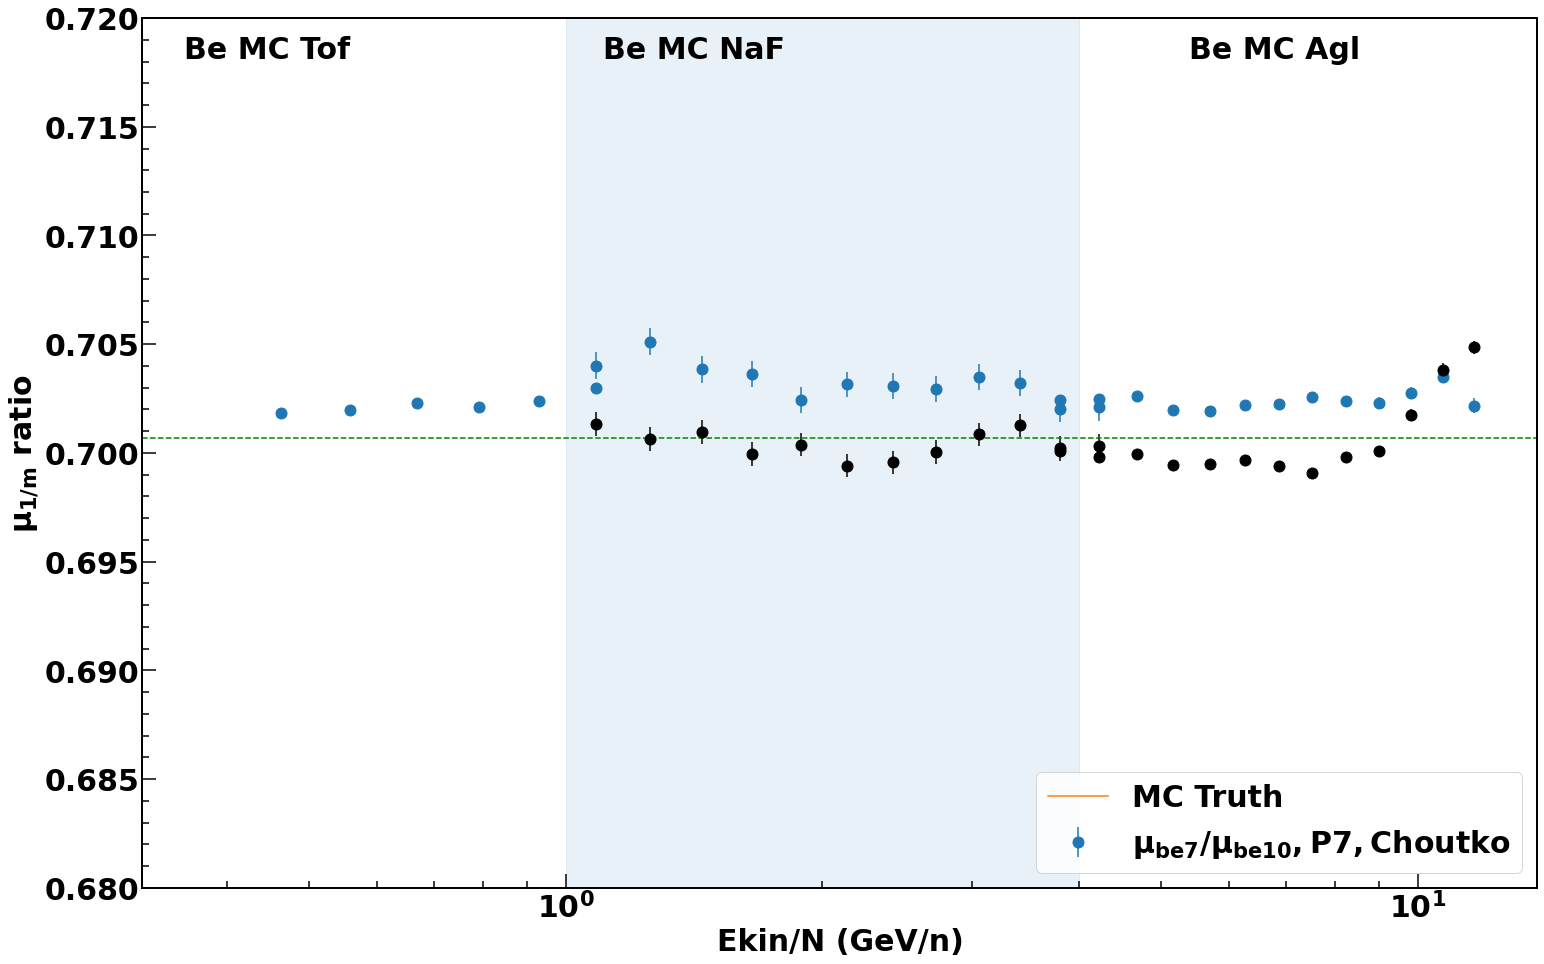

In [48]:
from tools.constants import ISOTOPES_MASS
filename_mc1236 = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/mcB1236/df_ratio_mean_iter2.npz'
filename_mc1220 = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/rawmc_v1/df_ratio_mean_iter2.npz'
filename_tune = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v23_fix/df_ratio_mean_iter2.npz'
#filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitBeryllium_v3/df_ratio_mean_iter2.npz'
#plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitBeryllium_v3'
#plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/rawmc_v1'
df_sigma_ratio_p8 = np.load(f'{filename_mc1236}')
df_sigma_ratio_p7 = np.load(f'{filename_mc1220}')
df_sigma_ratio_tune = np.load(f'{filename_tune}')
graph_mass_sigma_9to7_p8 = dict()
graph_mass_sigma_10to7_p8 = dict()
graph_mass_sigma_9to7_tune = dict()
graph_mass_sigma_10to7_tune = dict()
graph_mass_sigma_9to7_p7 = dict()
graph_mass_sigma_10to7_p7 = dict()
for dec in detectors:
    graph_mass_sigma_9to7_p8[dec] = MGraph.from_file(df_sigma_ratio_p8, f"graph_mass_sigma_9to7_{dec}")
    graph_mass_sigma_10to7_p8[dec] = MGraph.from_file(df_sigma_ratio_p8, f"graph_mass_sigma_10to7_{dec}")
    graph_mass_sigma_9to7_p7[dec] = MGraph.from_file(df_sigma_ratio_p7, f"graph_mass_sigma_9to7_{dec}")
    graph_mass_sigma_10to7_p7[dec] = MGraph.from_file(df_sigma_ratio_p7, f"graph_mass_sigma_10to7_{dec}")
    graph_mass_sigma_9to7_tune[dec] = MGraph.from_file(df_sigma_ratio_tune, f"graph_mass_sigma_9to7_{dec}")
    graph_mass_sigma_10to7_tune[dec] = MGraph.from_file(df_sigma_ratio_tune, f"graph_mass_sigma_10to7_{dec}")

from tools.binnings_collection import mass_binning, fbinning_energy, get_bin_center
fig, ax1 = plt.subplots(1, 1, figsize= (25, 16))
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
for dec in detectors: 
        if dec == 'Tof':
            #plot_graph(fig, ax1, graph_mass_sigma_10to7_p8[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be10}, P8, Choutko}$")
            plot_graph(fig, ax1, graph_mass_sigma_10to7_p7[dec], color='tab:blue', style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be10}, P7, Choutko}$")
            #plot_graph(fig, ax1, graph_mass_sigma_10to7_tune[dec], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be10}, P7, tuned}$")
            ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '-', color=DETECTOR_COLOR[dec], label='MC Truth')
        else:
            #plot_graph(fig, ax1, graph_mass_sigma_10to7_p8[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
            plot_graph(fig, ax1, graph_mass_sigma_10to7_p7[dec], color='tab:blue', style="EP", xlog=False, ylog=False, scale=None, markersize=22)
            plot_graph(fig, ax1, graph_mass_sigma_10to7_tune[dec], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=22)
            ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '-', color=DETECTOR_COLOR[dec])
        popt, pcov = curve_fit(poly, np.log(graph_mass_sigma_10to7_p7[dec].xvalues), graph_mass_sigma_10to7_p7[dec].yvalues, p0 = [0.7])  
        print('be10', popt)
        #ax1.plot(graph_mass_sigma_10to7_p7[dec].xvalues, poly(np.log(graph_mass_sigma_10to7_p7[dec].xvalues), *popt), "-", color='green')
        ax1.text(xaxistext[dec], 0.98, f"Be MC {dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      

                                                                                                                                                                                                                                                                                                                                                                                                                         
set_plot_defaultstyle(ax1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)")
ax1.fill_betweenx(np.linspace(0.6, 0.9, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'], color='green', linestyle='--')  


ax1.set_ylim([0.68, 0.72])

label_ref9 = mlines.Line2D([], [], linestyle='--', color=ISOTOPES_COLOR['Be9'], label='m7/m9')  
label_ref10 = mlines.Line2D([], [], linestyle='--', color=ISOTOPES_COLOR['Be10'], label='m7/m10') 
legend2 = ax1.legend(handles=[label_ref9, label_ref10], loc='upper left', bbox_to_anchor=(0.05, 0.2), fontsize=20)   
#ax1.add_artist(legend2)  
ax1.set_xlabel('Ekin/N (GeV/n)')
ax1.set_ylabel(r'$\mathrm{\mu_{1/m} ~ ratio}$')
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=30)
print(plotdir)
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate0410/plots_0410'
savefig_tofile(fig, plotdir, 'mass_mean_ratio_compare', 1)


be9 Tof [0.77877882]
be9 NaF [0.7798485]
be9 Agl [0.77929917]
/home/manbing/Documents/lithiumanalysis/slides/BeUpdate0410/plots_0410


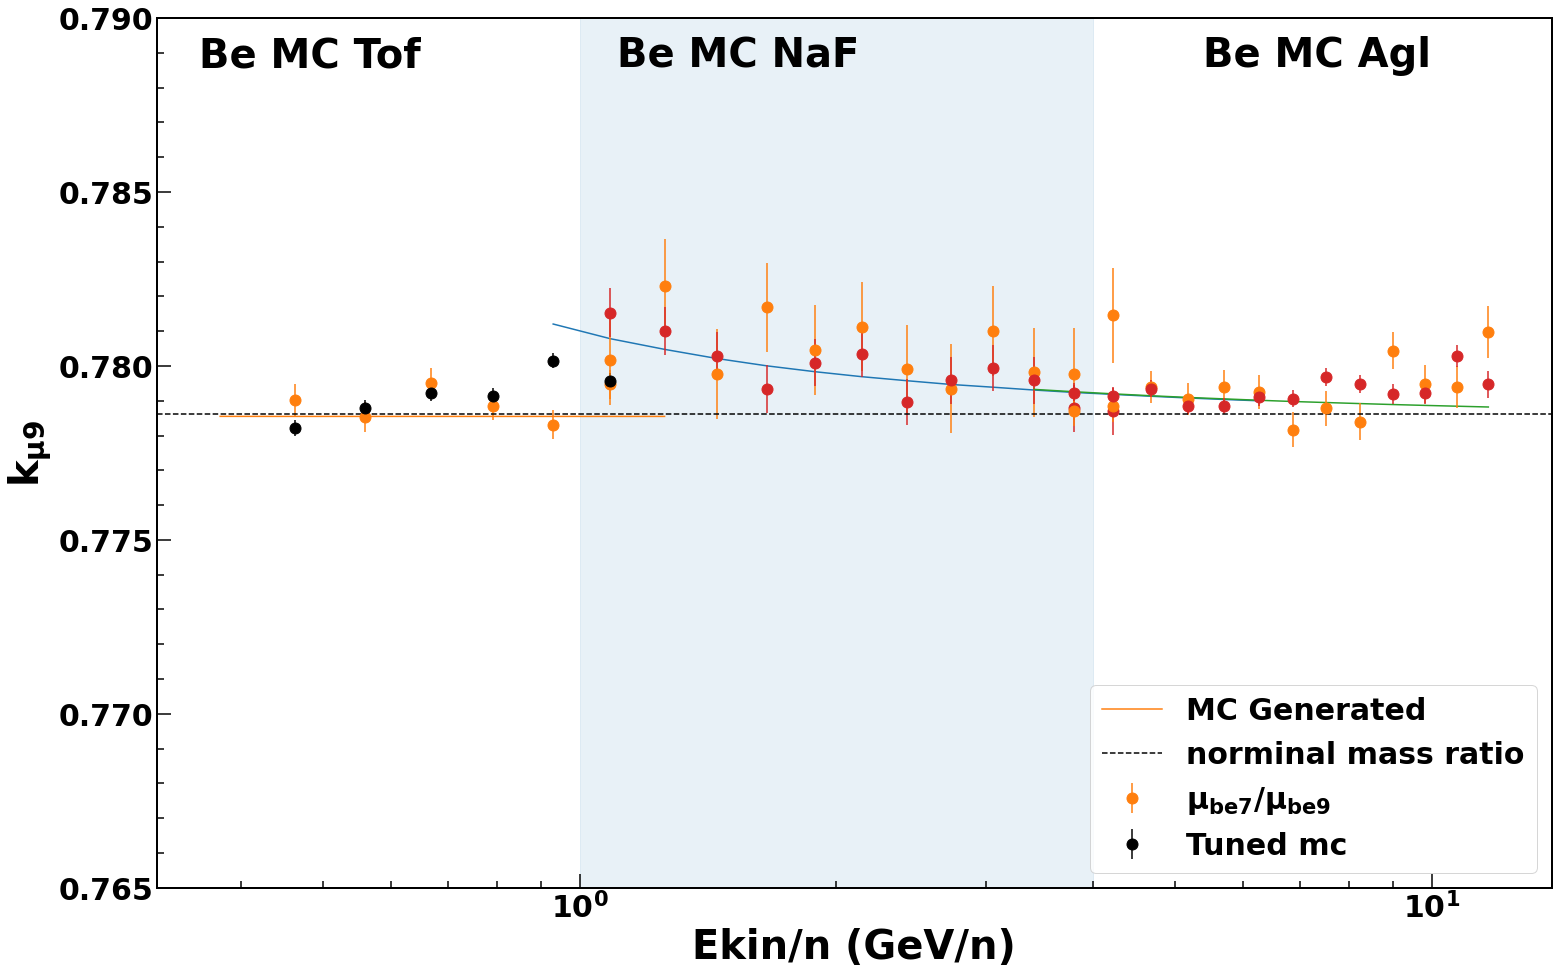

In [67]:
from tools.constants import ISOTOPES_MASS
filename_mc1236 = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/mcB1236/df_ratio_mean_iter2.npz'
filename_mc1220 = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/rawmc_v1/df_ratio_mean_iter2.npz'
filename_tune = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v23_fix/df_ratio_mean_iter2.npz'
#filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitBeryllium_v3/df_ratio_mean_iter2.npz'
#plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/fitBeryllium_v3'
#plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/rawmc_v1'
df_sigma_ratio_p8 = np.load(f'{filename_mc1236}')
df_sigma_ratio_p7 = np.load(f'{filename_mc1220}')
df_sigma_ratio_tune = np.load(f'{filename_tune}')
graph_mass_sigma_9to7_p8 = dict()
graph_mass_sigma_10to7_p8 = dict()
graph_mass_sigma_9to7_tune = dict()
graph_mass_sigma_10to7_tune = dict()
graph_mass_sigma_9to7_p7 = dict()
graph_mass_sigma_10to7_p7 = dict()
for dec in detectors:
    graph_mass_sigma_9to7_p8[dec] = MGraph.from_file(df_sigma_ratio_p8, f"graph_mass_sigma_9to7_{dec}")
    graph_mass_sigma_10to7_p8[dec] = MGraph.from_file(df_sigma_ratio_p8, f"graph_mass_sigma_10to7_{dec}")
    graph_mass_sigma_9to7_p7[dec] = MGraph.from_file(df_sigma_ratio_p7, f"graph_mass_sigma_9to7_{dec}")
    graph_mass_sigma_10to7_p7[dec] = MGraph.from_file(df_sigma_ratio_p7, f"graph_mass_sigma_10to7_{dec}")
    graph_mass_sigma_9to7_tune[dec] = MGraph.from_file(df_sigma_ratio_tune, f"graph_mass_sigma_9to7_{dec}")
    graph_mass_sigma_10to7_tune[dec] = MGraph.from_file(df_sigma_ratio_tune, f"graph_mass_sigma_10to7_{dec}")

from tools.binnings_collection import mass_binning, fbinning_energy, get_bin_center
fig, ax1 = plt.subplots(1, 1, figsize= (25, 16))
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
for dec in detectors: 
        if dec == 'Tof':
            plot_graph(fig, ax1, graph_mass_sigma_9to7_p8[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be9}}$")
            #plot_graph(fig, ax1, graph_mass_sigma_9to7_p7[dec], color='tab:red', style="EP", xlog=False, ylog=False, scale=None, markersize=22, label="Raw mc")
            plot_graph(fig, ax1, graph_mass_sigma_9to7_tune[dec], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=22, label="Tuned mc")
            ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '-', color=DETECTOR_COLOR[dec], label='MC Generated')
            #plot_graph(fig, ax1, graph_massratio_be9_gausfit[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label="")
        else:
            ax1.plot(graph_massratio_be9[dec].xvalues, graph_massratio_be9[dec].yvalues, '-', color=DETECTOR_COLOR[dec])
            plot_graph(fig, ax1, graph_mass_sigma_9to7_p8[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
            plot_graph(fig, ax1, graph_mass_sigma_9to7_p7[dec], color='tab:red', style="EP", xlog=False, ylog=False, scale=None, markersize=22)
            #plot_graph(fig, ax1, graph_mass_sigma_9to7_tune[dec], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        popt, pcov = curve_fit(poly, np.log(graph_mass_sigma_9to7_p7[dec].xvalues), graph_mass_sigma_9to7_p7[dec].yvalues, p0 = [0.7])  
        print('be9', dec, popt)
        #ax1.plot(graph_mass_sigma_10to7_p7[dec].xvalues, poly(np.log(graph_mass_sigma_10to7_p7[dec].xvalues), *popt), "-", color='green')
        ax1.text(xaxistext[dec], 0.98, f"Be MC {dec}", fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      

                                                                                                                                                                                                                                                                                                                                                                                                                         
set_plot_defaultstyle(ax1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax1.set_xlabel("Ekin/n (GeV/n)")
ax1.fill_betweenx(np.linspace(0.6, 0.9, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'] * 1.0001, color='black', linestyle='--', label='norminal mass ratio')  


ax1.set_ylim([0.765, 0.79])

label_ref9 = mlines.Line2D([], [], linestyle='--', color=ISOTOPES_COLOR['Be9'], label='m7/m9')  
label_ref10 = mlines.Line2D([], [], linestyle='--', color=ISOTOPES_COLOR['Be10'], label='m7/m10') 
legend2 = ax1.legend(handles=[label_ref9, label_ref10], loc='upper left', bbox_to_anchor=(0.05, 0.2), fontsize=20)   
#ax1.add_artist(legend2)  
ax1.set_xlabel('Ekin/n (GeV/n)', fontsize=40)
ax1.set_ylabel(r'$\mathrm{k_{\mu9}}$', fontsize=40)
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=30)
print(plotdir)
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/BeUpdate0410/plots_0410'
savefig_tofile(fig, plotdir, 'mass_mean_isoratio_be9v1', 1)


In [35]:
from tools.constants import ISOTOPES_MASS
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/mcB1236/df_ratio_sigma_iter2.npz'
filename_tune = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v23_fix/df_ratio_sigma_iter2.npz'
df_sigma_ratio = np.load(f'{filename}')
df_sigma_ratio_tune = np.load(f'{filename_tune}')
graph_mass_sigma_9to7 = dict()
graph_mass_sigma_10to7 = dict()
graph_mass_sigma_9to7_tune = dict()
graph_mass_sigma_10to7_tune = dict()
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/rawmc_v1'
for dec in detectors:
    graph_mass_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_9to7_{dec}")
    graph_mass_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_10to7_{dec}")
    graph_mass_sigma_9to7_tune[dec] = MGraph.from_file(df_sigma_ratio_tune, f"graph_mass_sigma_9to7_{dec}")
    graph_mass_sigma_10to7_tune[dec] = MGraph.from_file(df_sigma_ratio_tune, f"graph_mass_sigma_10to7_{dec}")


from tools.binnings_collection import mass_binning, fbinning_energy, get_bin_center
fig, ax1 = plt.subplots(1, 1, figsize= figSize)
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_dec = {'Tof':[0.7], 'NaF':[0.7, 0.1], "Agl":[0.7, 0.1, 0.1]}
for dec in detectors: 
        if dec == 'Tof':
            plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be9}}$")
            plot_graph(fig, ax1, graph_mass_sigma_9to7_tune[dec], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be9}, tune}$")
        else:
            plot_graph(fig, ax1, graph_mass_sigma_9to7[dec], color=ISOTOPES_COLOR["Be9"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
            plot_graph(fig, ax1, graph_mass_sigma_9to7_tune[dec], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=22)
            
        popt, pcov = curve_fit(poly, np.log(graph_mass_sigma_9to7[dec].xvalues), graph_mass_sigma_9to7[dec].yvalues, p0 = p0_dec[dec])  
        print(dec, "be9: ", popt, pcov)
        ax1.plot(graph_mass_sigma_9to7[dec].xvalues, poly(np.log(graph_mass_sigma_9to7[dec].xvalues), *popt), "-", color='black')
        #plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        popt10, pcov10 = curve_fit(poly, np.log(graph_mass_sigma_10to7[dec].xvalues), graph_mass_sigma_10to7[dec].yvalues, p0 = [1.0, 0.1, 0.1])  

        ax1.text(xaxistext[dec], 0.98, f"Be MC {dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      

                                                                                                                                                                        
#ax2.legend(fontsize=20)                                                                                                                                                                          
                                                                                                                                                                        
ax2.grid()                                                                                                                                                                                       
set_plot_defaultstyle(ax1)                                                                                                                                                                       
set_plot_defaultstyle(ax2)                                                                                                                                                                                                                                                                                                                         
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax2.set_xlabel("Ekin/n (GeV/n)") 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.7, 0.9, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be9'], color='orange', linestyle='--') 

#ax1.axhline(y=1.0, color='orange', linestyle='--')  
#ax1.axhline(y=0.77869417, color='black', linestyle='--')  

ax1.set_ylim([0.72, 0.83])
ax1.set_xlabel('Ekin/N (GeV/n)')
ax1.set_ylabel(r'$\mathrm{\sigma_{p, 1/m} ~ ratio}$')
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=30)
print(plotdir)
#ax1.axhline(y=6.53622/8.39479, color='black', linestyle='--')
#63: 6.53622, 64: 8.39479, 65: 9.32699
#plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_3008/plots_3008'
savefig_tofile(fig, plotdir, 'mass_sigma_isoratio_be9_rawmc', 1)


NameError: name 'figSize' is not defined

Tof be9:  [0.70549063] [[5.31597381e-07]]
NaF be9:  [0.70634945] [[7.18823575e-06]]
Agl be9:  [ 0.73555305 -0.03422274  0.01361761] [[ 1.13549182e-03 -1.21724717e-03  3.15868201e-04]
 [-1.21724717e-03  1.31612863e-03 -3.43992127e-04]
 [ 3.15868201e-04 -3.43992127e-04  9.05096634e-05]]
/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/rawmc_v1


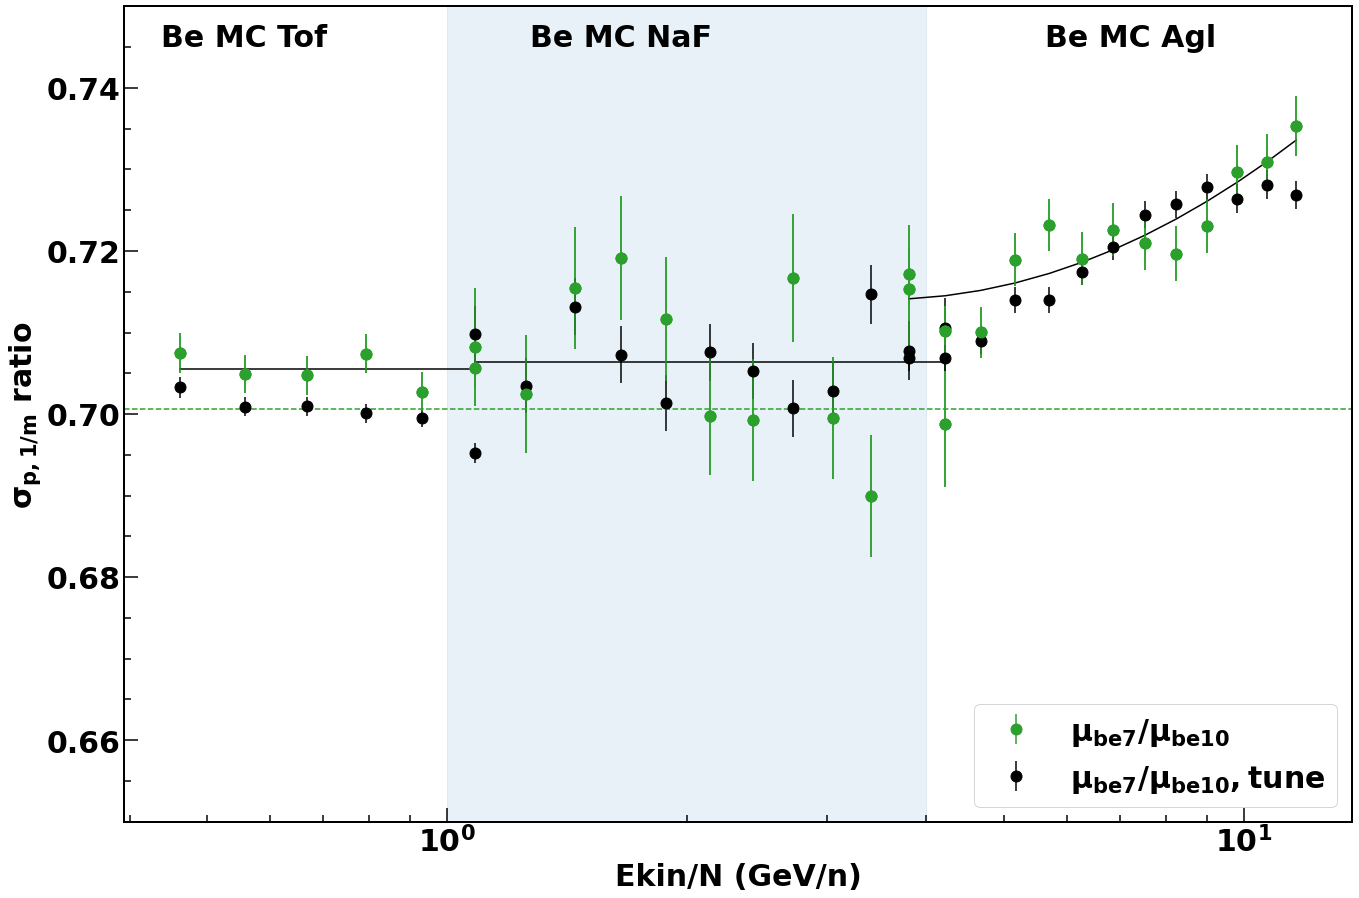

In [22]:
from tools.constants import ISOTOPES_MASS
filename = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/mcB1236/df_ratio_sigma_iter2.npz'
filename_tune = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/tunedmc_validate_v23_fix/df_ratio_sigma_iter2.npz'
df_sigma_ratio = np.load(f'{filename}')
df_sigma_ratio_tune = np.load(f'{filename_tune}')
graph_mass_sigma_9to7 = dict()
graph_mass_sigma_10to7 = dict()
graph_mass_sigma_9to7_tune = dict()
graph_mass_sigma_10to7_tune = dict()
plotdir = '/home/manbing/Documents/lithiumanalysis/scripts/plots/massfit/rawmc_v1'
for dec in detectors:
    graph_mass_sigma_9to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_9to7_{dec}")
    graph_mass_sigma_10to7[dec] = MGraph.from_file(df_sigma_ratio, f"graph_mass_sigma_10to7_{dec}")
    graph_mass_sigma_9to7_tune[dec] = MGraph.from_file(df_sigma_ratio_tune, f"graph_mass_sigma_9to7_{dec}")
    graph_mass_sigma_10to7_tune[dec] = MGraph.from_file(df_sigma_ratio_tune, f"graph_mass_sigma_10to7_{dec}")


from tools.binnings_collection import mass_binning, fbinning_energy, get_bin_center
fig, ax1 = plt.subplots(1, 1, figsize= figSize)
xaxistext = {"Tof": 0.03, "NaF": 0.33, "Agl": 0.75}
p0_dec = {'Tof':[0.7], 'NaF':[0.7], "Agl":[0.7, 0.1, 0.1]}
for dec in detectors: 
        if dec == 'Tof':
            plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be10}}$")
            plot_graph(fig, ax1, graph_mass_sigma_10to7_tune[dec], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=22, label=r"$\mathrm{\mu_{be7}/\mu_{be10}, tune}$")
        else:
            plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
            plot_graph(fig, ax1, graph_mass_sigma_10to7_tune[dec], color='black', style="EP", xlog=False, ylog=False, scale=None, markersize=22)
            
        popt, pcov = curve_fit(poly, np.log(graph_mass_sigma_10to7[dec].xvalues), graph_mass_sigma_10to7[dec].yvalues, p0 = p0_dec[dec])  
        print(dec, "be9: ", popt, pcov)
        ax1.plot(graph_mass_sigma_10to7[dec].xvalues, poly(np.log(graph_mass_sigma_10to7[dec].xvalues), *popt), "-", color='black')
        plot_graph(fig, ax1, graph_mass_sigma_10to7[dec], color=ISOTOPES_COLOR["Be10"], style="EP", xlog=False, ylog=False, scale=None, markersize=22)
        popt10, pcov10 = curve_fit(poly, np.log(graph_mass_sigma_10to7[dec].xvalues), graph_mass_sigma_10to7[dec].yvalues, p0 = [1.0, 0.1, 0.1])  

        ax1.text(xaxistext[dec], 0.98, f"Be MC {dec}", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      

                                                                                                                                                                        
#ax2.legend(fontsize=20)                                                                                                                                                                          
                                                                                                                                                                        
ax2.grid()                                                                                                                                                                                       
set_plot_defaultstyle(ax1)                                                                                                                                                                       
set_plot_defaultstyle(ax2)                                                                                                                                                                                                                                                                                                                         
plt.subplots_adjust(hspace=.0)                                                                                                                                                                   
#ax1.set_xticklabels([])                                                                                                                                                                          
ax2.set_xlabel("Ekin/n (GeV/n)") 
#ax1.set_xscale('log')
ax1.fill_betweenx(np.linspace(0.75, 0.8, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
ax1.axhline(y=ISOTOPES_MASS['Be7']/ISOTOPES_MASS['Be10'], color='tab:green', linestyle='--') 

#ax1.axhline(y=1.0, color='orange', linestyle='--')  
#ax1.axhline(y=0.77869417, color='black', linestyle='--')  

ax1.set_ylim([0.65, 0.75])
ax1.set_xlabel('Ekin/N (GeV/n)')
ax1.set_ylabel(r'$\mathrm{\sigma_{p, 1/m} ~ ratio}$')
ax1.set_xscale('log')
ax1.legend(loc='lower right', fontsize=30)
print(plotdir)
#ax1.axhline(y=7.0/9.0, color='black', linestyle='--')
ax1.fill_betweenx(np.linspace(0.6, 0.9, 100), 1.0, 4.0, alpha=0.1, color="tab:blue") 
plotdir = '/home/manbing/Documents/lithiumanalysis/slides/isotopes_3008/plots_3008'
savefig_tofile(fig, plotdir, 'mass_sigma_isoratio_be10_rawmc', 1)
